# Based
- https://www.kaggle.com/code/honganzhu/cmi-piu-competition?scriptVersionId=201912528 Version44 LB0.492

 If you find this notebook useful, please upvote this and the based one.

In [155]:
import numpy as np
import pandas as pd
import os
import re
from sklearn.base import clone
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import StratifiedKFold, ShuffleSplit
from scipy.optimize import minimize
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import polars as pl
import polars.selectors as cs
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, FormatStrFormatter, PercentFormatter
import seaborn as sns

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

from colorama import Fore, Style
from IPython.display import clear_output
import warnings
import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import VotingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
from pytorch_tabnet.tab_model import TabNetRegressor
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', None)

pl.Config.set_tbl_rows(-1)
pl.Config.set_tbl_cols(-1)
pl.Config.set_fmt_str_lengths(10000)

polars.config.Config

In [2]:
#from IPython.display import display as ipydisplay, HTML
#ipydisplay(HTML("<style>.jp-CodeCell.jp-mod-outputsScrolled .jp-Cell-outputArea { max-height: 80em; }</style>"))

In [3]:
SEED = 42
n_splits = 5

# Feature Engineering

- **Feature Selection**: The dataset contains features related to physical characteristics (e.g., BMI, Height, Weight), behavioral aspects (e.g., internet usage), and fitness data (e.g., endurance time). 
- **Categorical Feature Encoding**: Categorical features are mapped to numerical values using custom mappings for each unique category within the dataset. This ensures compatibility with machine learning algorithms that require numerical input.
- **Time Series Aggregation**: Time series statistics (e.g., mean, standard deviation) from the actigraphy data are computed and merged into the main dataset to create additional features for model training.


In [4]:
path = "I:/Kaggle/child-mind-institute-problematic-internet-use/"

In [5]:
train = pd.read_csv(path + 'train.csv', dtype={'id': str})
test = pd.read_csv(path + 'test.csv', dtype={'id': str})
sample = pd.read_csv(path + 'sample_submission.csv', dtype={'id': str})

In [6]:
print(train.shape)
train.head()

(3960, 82)


id Basic_Demos-Enroll_Season  Basic_Demos-Age  Basic_Demos-Sex  \
0  00008ff9                      Fall                5                0   
1  000fd460                    Summer                9                0   
2  00105258                    Summer               10                1   
3  00115b9f                    Winter                9                0   
4  0016bb22                    Spring               18                1   

  CGAS-Season  CGAS-CGAS_Score Physical-Season  Physical-BMI  Physical-Height  \
0      Winter             51.0            Fall     16.877316             46.0   
1         NaN              NaN            Fall     14.035590             48.0   
2        Fall             71.0            Fall     16.648696             56.5   
3        Fall             71.0          Summer     18.292347             56.0   
4      Summer              NaN             NaN           NaN              NaN   

   Physical-Weight  Physical-Waist_Circumference  Physical-Diastolic_BP  \
0             50.8                           NaN                    NaN   
1             46.0                          22.0                   75.0   
2             75.6                           NaN                   65.0   
3             81.6                           NaN                   60.0   
4              NaN                           NaN                    NaN   

   Physical-HeartRate  Physical-Systolic_BP Fitness_Endurance-Season  \
0                 NaN                   NaN                      NaN   
1                70.0                 122.0                      NaN   
2                94.0                 117.0                     Fall   
3                97.0                 117.0                   Summer   
4                 NaN                   NaN                      NaN   

   Fitness_Endurance-Max_Stage  Fitness_Endurance-Time_Mins  \
0                          NaN                          NaN   
1                          NaN                          NaN   
2                          5.0                          7.0   
3                          6.0                          9.0   
4                          NaN                          NaN   

   Fitness_Endurance-Time_Sec FGC-Season  FGC-FGC_CU  FGC-FGC_CU_Zone  \
0                         NaN       Fall         0.0              0.0   
1                         NaN       Fall         3.0              0.0   
2                        33.0       Fall        20.0              1.0   
3                        37.0     Summer        18.0              1.0   
4                         NaN        NaN         NaN              NaN   

   FGC-FGC_GSND  FGC-FGC_GSND_Zone  FGC-FGC_GSD  FGC-FGC_GSD_Zone  FGC-FGC_PU  \
0           NaN                NaN          NaN               NaN         0.0   
1           NaN                NaN          NaN               NaN         5.0   
2          10.2                1.0         14.7               2.0         7.0   
3           NaN                NaN          NaN               NaN         5.0   
4           NaN                NaN          NaN               NaN         NaN   

   FGC-FGC_PU_Zone  FGC-FGC_SRL  FGC-FGC_SRL_Zone  FGC-FGC_SRR  \
0              0.0          7.0               0.0          6.0   
1              0.0         11.0               1.0         11.0   
2              1.0         10.0               1.0         10.0   
3              0.0          7.0               0.0          7.0   
4              NaN          NaN               NaN          NaN   

   FGC-FGC_SRR_Zone  FGC-FGC_TL  FGC-FGC_TL_Zone BIA-Season  \
0               0.0         6.0              1.0       Fall   
1               1.0         3.0              0.0     Winter   
2               1.0         5.0              0.0        NaN   
3               0.0         7.0              1.0     Summer   
4               NaN         NaN              NaN        NaN   

   BIA-BIA_Activity_Level_num  BIA-BIA_BMC  BIA-BIA_BMI  BIA-BIA_BMR  \
0                         2.0     

In [7]:
print(test.shape)
test.head()

(20, 59)


id Basic_Demos-Enroll_Season  Basic_Demos-Age  Basic_Demos-Sex  \
0  00008ff9                      Fall                5                0   
1  000fd460                    Summer                9                0   
2  00105258                    Summer               10                1   
3  00115b9f                    Winter                9                0   
4  0016bb22                    Spring               18                1   

  CGAS-Season  CGAS-CGAS_Score Physical-Season  Physical-BMI  Physical-Height  \
0      Winter             51.0            Fall     16.877316             46.0   
1         NaN              NaN            Fall     14.035590             48.0   
2        Fall             71.0            Fall     16.648696             56.5   
3        Fall             71.0          Summer     18.292347             56.0   
4      Summer              NaN             NaN           NaN              NaN   

   Physical-Weight  Physical-Waist_Circumference  Physical-Diastolic_BP  \
0             50.8                           NaN                    NaN   
1             46.0                          22.0                   75.0   
2             75.6                           NaN                   65.0   
3             81.6                           NaN                   60.0   
4              NaN                           NaN                    NaN   

   Physical-HeartRate  Physical-Systolic_BP Fitness_Endurance-Season  \
0                 NaN                   NaN                      NaN   
1                70.0                 122.0                      NaN   
2                94.0                 117.0                     Fall   
3                97.0                 117.0                   Summer   
4                 NaN                   NaN                      NaN   

   Fitness_Endurance-Max_Stage  Fitness_Endurance-Time_Mins  \
0                          NaN                          NaN   
1                          NaN                          NaN   
2                          5.0                          7.0   
3                          6.0                          9.0   
4                          NaN                          NaN   

   Fitness_Endurance-Time_Sec FGC-Season  FGC-FGC_CU  FGC-FGC_CU_Zone  \
0                         NaN       Fall         0.0              0.0   
1                         NaN       Fall         3.0              0.0   
2                        33.0       Fall        20.0              1.0   
3                        37.0     Summer        18.0              1.0   
4                         NaN        NaN         NaN              NaN   

   FGC-FGC_GSND  FGC-FGC_GSND_Zone  FGC-FGC_GSD  FGC-FGC_GSD_Zone  FGC-FGC_PU  \
0           NaN                NaN          NaN               NaN         0.0   
1           NaN                NaN          NaN               NaN         5.0   
2          10.2                1.0         14.7               2.0         7.0   
3           NaN                NaN          NaN               NaN         5.0   
4           NaN                NaN          NaN               NaN         NaN   

   FGC-FGC_PU_Zone  FGC-FGC_SRL  FGC-FGC_SRL_Zone  FGC-FGC_SRR  \
0              0.0          7.0               0.0          6.0   
1              0.0         11.0               1.0         11.0   
2              1.0         10.0               1.0         10.0   
3              0.0          7.0               0.0          7.0   
4              NaN          NaN               NaN          NaN   

   FGC-FGC_SRR_Zone  FGC-FGC_TL  FGC-FGC_TL_Zone BIA-Season  \
0               0.0         6.0              1.0       Fall   
1               1.0         3.0              0.0     Winter   
2               1.0         5.0              0.0        NaN   
3               0.0         7.0              1.0     Summer   
4               NaN         NaN              NaN        NaN   

   BIA-BIA_Activity_Level_num  BIA-BIA_BMC  BIA-BIA_BMI  BIA-BIA_BMR  \
0                         2.0     

In [8]:
sample

id  sii
0   00008ff9    0
1   000fd460    1
2   00105258    2
3   00115b9f    3
4   0016bb22    0
5   001f3379    1
6   0038ba98    2
7   0068a485    3
8   0069fbed    0
9   0083e397    1
10  0087dd65    2
11  00abe655    3
12  00ae59c9    0
13  00af6387    1
14  00bd4359    2
15  00c0cd71    3
16  00d56d4b    0
17  00d9913d    1
18  00e6167c    2
19  00ebc35d    3

In [9]:
data_dict = pd.read_csv(path + 'data_dictionary.csv')
print(data_dict.shape)
data_dict

(81, 6)


Instrument  \
0                                      Identifier   
1                                    Demographics   
2                                    Demographics   
3                                    Demographics   
4              Children's Global Assessment Scale   
5              Children's Global Assessment Scale   
6                               Physical Measures   
7                               Physical Measures   
8                               Physical Measures   
9                               Physical Measures   
10                              Physical Measures   
11                              Physical Measures   
12                              Physical Measures   
13                              Physical Measures   
14               FitnessGram Vitals and Treadmill   
15               FitnessGram Vitals and Treadmill   
16               FitnessGram Vitals and Treadmill   
17               FitnessGram Vitals and Treadmill   
18                              FitnessGram Child   
19                              FitnessGram Child   
20                              FitnessGram Child   
21                              FitnessGram Child   
22                              FitnessGram Child   
23                              FitnessGram Child   
24                              FitnessGram Child   
25                              FitnessGram Child   
26                              FitnessGram Child   
27                              FitnessGram Child   
28                              FitnessGram Child   
29                              FitnessGram Child   
30                              FitnessGram Child   
31                              FitnessGram Child   
32                              FitnessGram Child   
33                Bio-electric Impedance Analysis   
34                Bio-electric Impedance Analysis   
35                Bio-electric Impedance Analysis   
36                Bio-electric Impedance Analysis   
37                Bio-electric Impedance Analysis   
38                Bio-electric Impedance Analysis   
39                Bio-electric Impedance Analysis   
40                Bio-electric Impedance Analysis   
41                Bio-electric Impedance Analysis   
42                Bio-electric Impedance Analysis   
43                Bio-electric Impedance Analysis   
44                Bio-electric Impedance Analysis   
45                Bio-electric Impedance Analysis   
46                Bio-electric Impedance Analysis   
47                Bio-electric Impedance Analysis   
48                Bio-electric Impedance Analysis   
49                Bio-electric Impedance Analysis   
50  Physical Activity Questionnaire (Adolescents)   
51  Physical Activity Questionnaire (Adolescents)   
52     Physical Activity Questionnaire (Children)   
53     Physical Activity Questionnaire (Children)   
54           Parent-Child Internet Addiction Test   
55           Parent-Child Internet Addiction Test   
56           Parent-Child Internet Addiction Test   
57           Parent-Child Internet Addiction Test   
58           Parent-Child Internet Addiction Test   
59           Parent-Child Internet Addiction Test   
60           Parent-Child Internet Addiction Test   
61           Parent-Child Internet Addiction Test   
62           Parent-Child Internet Addiction Test   
63           Parent-Child Internet Addiction Test   
64           Parent-Child Internet Addiction Test   
65           Parent-Child Internet Addiction Test   
66           Parent-Child Internet Addiction Test   
67           Parent-Child Internet Addiction Test   
68           Parent-Child Internet Addiction Test   
69           Parent-Child Internet Addiction Test   
70           Parent-Child Internet Addiction Test   
71           Parent-Child Internet Addiction Test   
72           Parent-Child Internet Addiction Test   
73           Parent-Child Internet Addiction Test   
74           Parent-Child Internet Addiction Test   
75         

In [10]:
train['id'].nunique()

3960

In [11]:
test['id'].nunique()

20

In [12]:
train_target = train[test.columns]

In [13]:
print(train_target.shape)
train_target.head()

(3960, 59)


id Basic_Demos-Enroll_Season  Basic_Demos-Age  Basic_Demos-Sex  \
0  00008ff9                      Fall                5                0   
1  000fd460                    Summer                9                0   
2  00105258                    Summer               10                1   
3  00115b9f                    Winter                9                0   
4  0016bb22                    Spring               18                1   

  CGAS-Season  CGAS-CGAS_Score Physical-Season  Physical-BMI  Physical-Height  \
0      Winter             51.0            Fall     16.877316             46.0   
1         NaN              NaN            Fall     14.035590             48.0   
2        Fall             71.0            Fall     16.648696             56.5   
3        Fall             71.0          Summer     18.292347             56.0   
4      Summer              NaN             NaN           NaN              NaN   

   Physical-Weight  Physical-Waist_Circumference  Physical-Diastolic_BP  \
0             50.8                           NaN                    NaN   
1             46.0                          22.0                   75.0   
2             75.6                           NaN                   65.0   
3             81.6                           NaN                   60.0   
4              NaN                           NaN                    NaN   

   Physical-HeartRate  Physical-Systolic_BP Fitness_Endurance-Season  \
0                 NaN                   NaN                      NaN   
1                70.0                 122.0                      NaN   
2                94.0                 117.0                     Fall   
3                97.0                 117.0                   Summer   
4                 NaN                   NaN                      NaN   

   Fitness_Endurance-Max_Stage  Fitness_Endurance-Time_Mins  \
0                          NaN                          NaN   
1                          NaN                          NaN   
2                          5.0                          7.0   
3                          6.0                          9.0   
4                          NaN                          NaN   

   Fitness_Endurance-Time_Sec FGC-Season  FGC-FGC_CU  FGC-FGC_CU_Zone  \
0                         NaN       Fall         0.0              0.0   
1                         NaN       Fall         3.0              0.0   
2                        33.0       Fall        20.0              1.0   
3                        37.0     Summer        18.0              1.0   
4                         NaN        NaN         NaN              NaN   

   FGC-FGC_GSND  FGC-FGC_GSND_Zone  FGC-FGC_GSD  FGC-FGC_GSD_Zone  FGC-FGC_PU  \
0           NaN                NaN          NaN               NaN         0.0   
1           NaN                NaN          NaN               NaN         5.0   
2          10.2                1.0         14.7               2.0         7.0   
3           NaN                NaN          NaN               NaN         5.0   
4           NaN                NaN          NaN               NaN         NaN   

   FGC-FGC_PU_Zone  FGC-FGC_SRL  FGC-FGC_SRL_Zone  FGC-FGC_SRR  \
0              0.0          7.0               0.0          6.0   
1              0.0         11.0               1.0         11.0   
2              1.0         10.0               1.0         10.0   
3              0.0          7.0               0.0          7.0   
4              NaN          NaN               NaN          NaN   

   FGC-FGC_SRR_Zone  FGC-FGC_TL  FGC-FGC_TL_Zone BIA-Season  \
0               0.0         6.0              1.0       Fall   
1               1.0         3.0              0.0     Winter   
2               1.0         5.0              0.0        NaN   
3               0.0         7.0              1.0     Summer   
4               NaN         NaN              NaN        NaN   

   BIA-BIA_Activity_Level_num  BIA-BIA_BMC  BIA-BIA_BMI  BIA-BIA_BMR  \
0                         2.0     

In [14]:
concat_df = pd.concat([train_target, test], ignore_index=True)
print(concat_df.shape)
concat_df.head()

(3980, 59)


id Basic_Demos-Enroll_Season  Basic_Demos-Age  Basic_Demos-Sex  \
0  00008ff9                      Fall                5                0   
1  000fd460                    Summer                9                0   
2  00105258                    Summer               10                1   
3  00115b9f                    Winter                9                0   
4  0016bb22                    Spring               18                1   

  CGAS-Season  CGAS-CGAS_Score Physical-Season  Physical-BMI  Physical-Height  \
0      Winter             51.0            Fall     16.877316             46.0   
1         NaN              NaN            Fall     14.035590             48.0   
2        Fall             71.0            Fall     16.648696             56.5   
3        Fall             71.0          Summer     18.292347             56.0   
4      Summer              NaN             NaN           NaN              NaN   

   Physical-Weight  Physical-Waist_Circumference  Physical-Diastolic_BP  \
0             50.8                           NaN                    NaN   
1             46.0                          22.0                   75.0   
2             75.6                           NaN                   65.0   
3             81.6                           NaN                   60.0   
4              NaN                           NaN                    NaN   

   Physical-HeartRate  Physical-Systolic_BP Fitness_Endurance-Season  \
0                 NaN                   NaN                      NaN   
1                70.0                 122.0                      NaN   
2                94.0                 117.0                     Fall   
3                97.0                 117.0                   Summer   
4                 NaN                   NaN                      NaN   

   Fitness_Endurance-Max_Stage  Fitness_Endurance-Time_Mins  \
0                          NaN                          NaN   
1                          NaN                          NaN   
2                          5.0                          7.0   
3                          6.0                          9.0   
4                          NaN                          NaN   

   Fitness_Endurance-Time_Sec FGC-Season  FGC-FGC_CU  FGC-FGC_CU_Zone  \
0                         NaN       Fall         0.0              0.0   
1                         NaN       Fall         3.0              0.0   
2                        33.0       Fall        20.0              1.0   
3                        37.0     Summer        18.0              1.0   
4                         NaN        NaN         NaN              NaN   

   FGC-FGC_GSND  FGC-FGC_GSND_Zone  FGC-FGC_GSD  FGC-FGC_GSD_Zone  FGC-FGC_PU  \
0           NaN                NaN          NaN               NaN         0.0   
1           NaN                NaN          NaN               NaN         5.0   
2          10.2                1.0         14.7               2.0         7.0   
3           NaN                NaN          NaN               NaN         5.0   
4           NaN                NaN          NaN               NaN         NaN   

   FGC-FGC_PU_Zone  FGC-FGC_SRL  FGC-FGC_SRL_Zone  FGC-FGC_SRR  \
0              0.0          7.0               0.0          6.0   
1              0.0         11.0               1.0         11.0   
2              1.0         10.0               1.0         10.0   
3              0.0          7.0               0.0          7.0   
4              NaN          NaN               NaN          NaN   

   FGC-FGC_SRR_Zone  FGC-FGC_TL  FGC-FGC_TL_Zone BIA-Season  \
0               0.0         6.0              1.0       Fall   
1               1.0         3.0              0.0     Winter   
2               1.0         5.0              0.0        NaN   
3               0.0         7.0              1.0     Summer   
4               NaN         NaN              NaN        NaN   

   BIA-BIA_Activity_Level_num  BIA-BIA_BMC  BIA-BIA_BMI  BIA-BIA_BMR  \
0                         2.0     

In [15]:
concat_df['total_num_nan'] = concat_df.isna().sum(axis=1)

In [16]:
concat_df['total_num_nan'].describe()

count    3980.000000
mean       26.142462
std        17.257902
min         3.000000
25%         9.000000
50%        24.000000
75%        41.000000
max        55.000000
Name: total_num_nan, dtype: float64

In [17]:
nan_df = concat_df[concat_df['total_num_nan'] == concat_df['total_num_nan'].max()]
print(nan_df.shape)
nan_df.head()

(199, 60)


id Basic_Demos-Enroll_Season  Basic_Demos-Age  Basic_Demos-Sex  \
42   023e1b6a                    Summer               13                0   
67   040d103f                    Spring                8                1   
84   04ccb838                    Summer                7                0   
107  05dc60ef                    Spring               12                1   
148  0882b065                    Summer               11                0   

    CGAS-Season  CGAS-CGAS_Score Physical-Season  Physical-BMI  \
42          NaN              NaN             NaN           NaN   
67          NaN              NaN             NaN           NaN   
84          NaN              NaN             NaN           NaN   
107         NaN              NaN             NaN           NaN   
148         NaN              NaN             NaN           NaN   

     Physical-Height  Physical-Weight  Physical-Waist_Circumference  \
42               NaN              NaN                           NaN   
67               NaN              NaN                           NaN   
84               NaN              NaN                           NaN   
107              NaN              NaN                           NaN   
148              NaN              NaN                           NaN   

     Physical-Diastolic_BP  Physical-HeartRate  Physical-Systolic_BP  \
42                     NaN                 NaN                   NaN   
67                     NaN                 NaN                   NaN   
84                     NaN                 NaN                   NaN   
107                    NaN                 NaN                   NaN   
148                    NaN                 NaN                   NaN   

    Fitness_Endurance-Season  Fitness_Endurance-Max_Stage  \
42                       NaN                          NaN   
67                       NaN                          NaN   
84                       NaN                          NaN   
107                      NaN                          NaN   
148                      NaN                          NaN   

     Fitness_Endurance-Time_Mins  Fitness_Endurance-Time_Sec FGC-Season  \
42                           NaN                         NaN        NaN   
67                           NaN                         NaN        NaN   
84                           NaN                         NaN        NaN   
107                          NaN                         NaN        NaN   
148                          NaN                         NaN        NaN   

     FGC-FGC_CU  FGC-FGC_CU_Zone  FGC-FGC_GSND  FGC-FGC_GSND_Zone  \
42          NaN              NaN           NaN                NaN   
67          NaN              NaN           NaN                NaN   
84          NaN              NaN           NaN                NaN   
107         NaN              NaN           NaN                NaN   
148         NaN              NaN           NaN                NaN   

     FGC-FGC_GSD  FGC-FGC_GSD_Zone  FGC-FGC_PU  FGC-FGC_PU_Zone  FGC-FGC_SRL  \
42           NaN               NaN         NaN              NaN          NaN   
67           NaN               NaN         NaN              NaN          NaN   
84           NaN               NaN         NaN              NaN          NaN   
107          NaN               NaN         NaN              NaN          NaN   
148          NaN               NaN         NaN              NaN          NaN   

     FGC-FGC_SRL_Zone  FGC-FGC_SRR  FGC-FGC_SRR_Zone  FGC-FGC_TL  \
42                NaN          NaN               NaN         NaN   
67                NaN          NaN               NaN         NaN   
84                NaN          NaN               NaN         NaN   
107               NaN          NaN               NaN         NaN   
148               NaN          NaN               NaN         NaN   

     FGC-FGC_TL_Zone BIA-Season  BIA-BIA_Activity_Level_num  BIA-BIA_BMC  \
42               NaN        NaN                         NaN          NaN   
67              

In [18]:
for col in concat_df.columns:
    if col == 'id':
        continue
    new_col_name = col + '_isnan'
    concat_df[new_col_name] = concat_df[col].isna().astype(int)

In [19]:
print(concat_df.shape)
concat_df.head()

(3980, 119)


id Basic_Demos-Enroll_Season  Basic_Demos-Age  Basic_Demos-Sex  \
0  00008ff9                      Fall                5                0   
1  000fd460                    Summer                9                0   
2  00105258                    Summer               10                1   
3  00115b9f                    Winter                9                0   
4  0016bb22                    Spring               18                1   

  CGAS-Season  CGAS-CGAS_Score Physical-Season  Physical-BMI  Physical-Height  \
0      Winter             51.0            Fall     16.877316             46.0   
1         NaN              NaN            Fall     14.035590             48.0   
2        Fall             71.0            Fall     16.648696             56.5   
3        Fall             71.0          Summer     18.292347             56.0   
4      Summer              NaN             NaN           NaN              NaN   

   Physical-Weight  Physical-Waist_Circumference  Physical-Diastolic_BP  \
0             50.8                           NaN                    NaN   
1             46.0                          22.0                   75.0   
2             75.6                           NaN                   65.0   
3             81.6                           NaN                   60.0   
4              NaN                           NaN                    NaN   

   Physical-HeartRate  Physical-Systolic_BP Fitness_Endurance-Season  \
0                 NaN                   NaN                      NaN   
1                70.0                 122.0                      NaN   
2                94.0                 117.0                     Fall   
3                97.0                 117.0                   Summer   
4                 NaN                   NaN                      NaN   

   Fitness_Endurance-Max_Stage  Fitness_Endurance-Time_Mins  \
0                          NaN                          NaN   
1                          NaN                          NaN   
2                          5.0                          7.0   
3                          6.0                          9.0   
4                          NaN                          NaN   

   Fitness_Endurance-Time_Sec FGC-Season  FGC-FGC_CU  FGC-FGC_CU_Zone  \
0                         NaN       Fall         0.0              0.0   
1                         NaN       Fall         3.0              0.0   
2                        33.0       Fall        20.0              1.0   
3                        37.0     Summer        18.0              1.0   
4                         NaN        NaN         NaN              NaN   

   FGC-FGC_GSND  FGC-FGC_GSND_Zone  FGC-FGC_GSD  FGC-FGC_GSD_Zone  FGC-FGC_PU  \
0           NaN                NaN          NaN               NaN         0.0   
1           NaN                NaN          NaN               NaN         5.0   
2          10.2                1.0         14.7               2.0         7.0   
3           NaN                NaN          NaN               NaN         5.0   
4           NaN                NaN          NaN               NaN         NaN   

   FGC-FGC_PU_Zone  FGC-FGC_SRL  FGC-FGC_SRL_Zone  FGC-FGC_SRR  \
0              0.0          7.0               0.0          6.0   
1              0.0         11.0               1.0         11.0   
2              1.0         10.0               1.0         10.0   
3              0.0          7.0               0.0          7.0   
4              NaN          NaN               NaN          NaN   

   FGC-FGC_SRR_Zone  FGC-FGC_TL  FGC-FGC_TL_Zone BIA-Season  \
0               0.0         6.0              1.0       Fall   
1               1.0         3.0              0.0     Winter   
2               1.0         5.0              0.0        NaN   
3               0.0         7.0              1.0     Summer   
4               NaN         NaN              NaN        NaN   

   BIA-BIA_Activity_Level_num  BIA-BIA_BMC  BIA-BIA_BMI  BIA-BIA_BMR  \
0                         2.0     

In [20]:
instruments = data_dict['Instrument'].unique().tolist()
instruments.remove('Identifier')
print(len(instruments))
instruments

11


['Demographics',
 "Children's Global Assessment Scale",
 'Physical Measures',
 'FitnessGram Vitals and Treadmill',
 'FitnessGram Child',
 'Bio-electric Impedance Analysis',
 'Physical Activity Questionnaire (Adolescents)',
 'Physical Activity Questionnaire (Children)',
 'Parent-Child Internet Addiction Test',
 'Sleep Disturbance Scale',
 'Internet Use']

In [21]:
for instrument in instruments:
    if 'Parent-Child Internet Addiction Test' == instrument:
        continue
    instrument_df = data_dict[data_dict['Instrument'] == instrument]
    field_list = instrument_df['Field'].unique().tolist()
    concat_df[instrument + '_num_nan'] = concat_df[field_list].isna().sum(axis=1)    

In [22]:
print(concat_df.shape)
concat_df.head()

(3980, 129)


id Basic_Demos-Enroll_Season  Basic_Demos-Age  Basic_Demos-Sex  \
0  00008ff9                      Fall                5                0   
1  000fd460                    Summer                9                0   
2  00105258                    Summer               10                1   
3  00115b9f                    Winter                9                0   
4  0016bb22                    Spring               18                1   

  CGAS-Season  CGAS-CGAS_Score Physical-Season  Physical-BMI  Physical-Height  \
0      Winter             51.0            Fall     16.877316             46.0   
1         NaN              NaN            Fall     14.035590             48.0   
2        Fall             71.0            Fall     16.648696             56.5   
3        Fall             71.0          Summer     18.292347             56.0   
4      Summer              NaN             NaN           NaN              NaN   

   Physical-Weight  Physical-Waist_Circumference  Physical-Diastolic_BP  \
0             50.8                           NaN                    NaN   
1             46.0                          22.0                   75.0   
2             75.6                           NaN                   65.0   
3             81.6                           NaN                   60.0   
4              NaN                           NaN                    NaN   

   Physical-HeartRate  Physical-Systolic_BP Fitness_Endurance-Season  \
0                 NaN                   NaN                      NaN   
1                70.0                 122.0                      NaN   
2                94.0                 117.0                     Fall   
3                97.0                 117.0                   Summer   
4                 NaN                   NaN                      NaN   

   Fitness_Endurance-Max_Stage  Fitness_Endurance-Time_Mins  \
0                          NaN                          NaN   
1                          NaN                          NaN   
2                          5.0                          7.0   
3                          6.0                          9.0   
4                          NaN                          NaN   

   Fitness_Endurance-Time_Sec FGC-Season  FGC-FGC_CU  FGC-FGC_CU_Zone  \
0                         NaN       Fall         0.0              0.0   
1                         NaN       Fall         3.0              0.0   
2                        33.0       Fall        20.0              1.0   
3                        37.0     Summer        18.0              1.0   
4                         NaN        NaN         NaN              NaN   

   FGC-FGC_GSND  FGC-FGC_GSND_Zone  FGC-FGC_GSD  FGC-FGC_GSD_Zone  FGC-FGC_PU  \
0           NaN                NaN          NaN               NaN         0.0   
1           NaN                NaN          NaN               NaN         5.0   
2          10.2                1.0         14.7               2.0         7.0   
3           NaN                NaN          NaN               NaN         5.0   
4           NaN                NaN          NaN               NaN         NaN   

   FGC-FGC_PU_Zone  FGC-FGC_SRL  FGC-FGC_SRL_Zone  FGC-FGC_SRR  \
0              0.0          7.0               0.0          6.0   
1              0.0         11.0               1.0         11.0   
2              1.0         10.0               1.0         10.0   
3              0.0          7.0               0.0          7.0   
4              NaN          NaN               NaN          NaN   

   FGC-FGC_SRR_Zone  FGC-FGC_TL  FGC-FGC_TL_Zone BIA-Season  \
0               0.0         6.0              1.0       Fall   
1               1.0         3.0              0.0     Winter   
2               1.0         5.0              0.0        NaN   
3               0.0         7.0              1.0     Summer   
4               NaN         NaN              NaN        NaN   

   BIA-BIA_Activity_Level_num  BIA-BIA_BMC  BIA-BIA_BMI  BIA-BIA_BMR  \
0                         2.0     

In [23]:
train_parquet_id_folders_list = os.listdir(path + 'series_train.parquet/')
print(len(train_parquet_id_folders_list))
train_parquet_id_folders_list

996


['id=00115b9f',
 'id=001f3379',
 'id=00f332d1',
 'id=01085eb3',
 'id=012cadd8',
 'id=012e3869',
 'id=029a19c9',
 'id=02cebf33',
 'id=02cf7384',
 'id=035c96dd',
 'id=03a9019b',
 'id=0417c91e',
 'id=045a0a94',
 'id=04afb6f9',
 'id=04bb1a76',
 'id=04cb2c30',
 'id=04d06a9c',
 'id=04f094a8',
 'id=051680a0',
 'id=055156e2',
 'id=059eed01',
 'id=05bbed1b',
 'id=05db1b9b',
 'id=05e94f88',
 'id=063b16fc',
 'id=064e8da5',
 'id=0668373f',
 'id=067b9287',
 'id=06c8b2fb',
 'id=06eb8adb',
 'id=070386b2',
 'id=07048067',
 'id=0720320e',
 'id=0745c390',
 'id=080698b7',
 'id=082df556',
 'id=08577722',
 'id=08660d12',
 'id=089a6b19',
 'id=09331bb8',
 'id=0983654b',
 'id=099e3614',
 'id=09b29113',
 'id=0a418b57',
 'id=0a431608',
 'id=0b4014f0',
 'id=0b50f3fa',
 'id=0b518637',
 'id=0b7d7aec',
 'id=0b7d9da6',
 'id=0bd89878',
 'id=0bfe4fc9',
 'id=0c4e2d68',
 'id=0c4eabac',
 'id=0c98f822',
 'id=0cbe4e54',
 'id=0d01bbf2',
 'id=0d279d77',
 'id=0d4800c8',
 'id=0d4fa8f4',
 'id=0d570d3e',
 'id=0d924604',
 'id=0e3

In [24]:
train_parquet_id_list = [v.replace('id=', '') for v in train_parquet_id_folders_list]
print(len(train_parquet_id_list))
train_parquet_id_list

996


['00115b9f',
 '001f3379',
 '00f332d1',
 '01085eb3',
 '012cadd8',
 '012e3869',
 '029a19c9',
 '02cebf33',
 '02cf7384',
 '035c96dd',
 '03a9019b',
 '0417c91e',
 '045a0a94',
 '04afb6f9',
 '04bb1a76',
 '04cb2c30',
 '04d06a9c',
 '04f094a8',
 '051680a0',
 '055156e2',
 '059eed01',
 '05bbed1b',
 '05db1b9b',
 '05e94f88',
 '063b16fc',
 '064e8da5',
 '0668373f',
 '067b9287',
 '06c8b2fb',
 '06eb8adb',
 '070386b2',
 '07048067',
 '0720320e',
 '0745c390',
 '080698b7',
 '082df556',
 '08577722',
 '08660d12',
 '089a6b19',
 '09331bb8',
 '0983654b',
 '099e3614',
 '09b29113',
 '0a418b57',
 '0a431608',
 '0b4014f0',
 '0b50f3fa',
 '0b518637',
 '0b7d7aec',
 '0b7d9da6',
 '0bd89878',
 '0bfe4fc9',
 '0c4e2d68',
 '0c4eabac',
 '0c98f822',
 '0cbe4e54',
 '0d01bbf2',
 '0d279d77',
 '0d4800c8',
 '0d4fa8f4',
 '0d570d3e',
 '0d924604',
 '0e3b0bd2',
 '0ec403df',
 '0ed2a3c8',
 '0eddd8e5',
 '0f6b71c4',
 '0fbb3ca5',
 '101774f0',
 '101c27f1',
 '108b8659',
 '10ad8c48',
 '10e46254',
 '113f5798',
 '11739de2',
 '119d7562',
 '119e181e',

In [25]:
test_parquet_id_folders_list = os.listdir(path + 'series_test.parquet/')
print(len(test_parquet_id_folders_list))
test_parquet_id_folders_list

2


['id=00115b9f', 'id=001f3379']

In [26]:
test_parquet_id_list = [v.replace('id=', '') for v in test_parquet_id_folders_list]
print(len(test_parquet_id_list))
test_parquet_id_list

2


['00115b9f', '001f3379']

In [27]:
train_temp_df = concat_df.head(train.shape[0])
print(train_temp_df.shape)
train_temp_df.head()

(3960, 129)


id Basic_Demos-Enroll_Season  Basic_Demos-Age  Basic_Demos-Sex  \
0  00008ff9                      Fall                5                0   
1  000fd460                    Summer                9                0   
2  00105258                    Summer               10                1   
3  00115b9f                    Winter                9                0   
4  0016bb22                    Spring               18                1   

  CGAS-Season  CGAS-CGAS_Score Physical-Season  Physical-BMI  Physical-Height  \
0      Winter             51.0            Fall     16.877316             46.0   
1         NaN              NaN            Fall     14.035590             48.0   
2        Fall             71.0            Fall     16.648696             56.5   
3        Fall             71.0          Summer     18.292347             56.0   
4      Summer              NaN             NaN           NaN              NaN   

   Physical-Weight  Physical-Waist_Circumference  Physical-Diastolic_BP  \
0             50.8                           NaN                    NaN   
1             46.0                          22.0                   75.0   
2             75.6                           NaN                   65.0   
3             81.6                           NaN                   60.0   
4              NaN                           NaN                    NaN   

   Physical-HeartRate  Physical-Systolic_BP Fitness_Endurance-Season  \
0                 NaN                   NaN                      NaN   
1                70.0                 122.0                      NaN   
2                94.0                 117.0                     Fall   
3                97.0                 117.0                   Summer   
4                 NaN                   NaN                      NaN   

   Fitness_Endurance-Max_Stage  Fitness_Endurance-Time_Mins  \
0                          NaN                          NaN   
1                          NaN                          NaN   
2                          5.0                          7.0   
3                          6.0                          9.0   
4                          NaN                          NaN   

   Fitness_Endurance-Time_Sec FGC-Season  FGC-FGC_CU  FGC-FGC_CU_Zone  \
0                         NaN       Fall         0.0              0.0   
1                         NaN       Fall         3.0              0.0   
2                        33.0       Fall        20.0              1.0   
3                        37.0     Summer        18.0              1.0   
4                         NaN        NaN         NaN              NaN   

   FGC-FGC_GSND  FGC-FGC_GSND_Zone  FGC-FGC_GSD  FGC-FGC_GSD_Zone  FGC-FGC_PU  \
0           NaN                NaN          NaN               NaN         0.0   
1           NaN                NaN          NaN               NaN         5.0   
2          10.2                1.0         14.7               2.0         7.0   
3           NaN                NaN          NaN               NaN         5.0   
4           NaN                NaN          NaN               NaN         NaN   

   FGC-FGC_PU_Zone  FGC-FGC_SRL  FGC-FGC_SRL_Zone  FGC-FGC_SRR  \
0              0.0          7.0               0.0          6.0   
1              0.0         11.0               1.0         11.0   
2              1.0         10.0               1.0         10.0   
3              0.0          7.0               0.0          7.0   
4              NaN          NaN               NaN          NaN   

   FGC-FGC_SRR_Zone  FGC-FGC_TL  FGC-FGC_TL_Zone BIA-Season  \
0               0.0         6.0              1.0       Fall   
1               1.0         3.0              0.0     Winter   
2               1.0         5.0              0.0        NaN   
3               0.0         7.0              1.0     Summer   
4               NaN         NaN              NaN        NaN   

   BIA-BIA_Activity_Level_num  BIA-BIA_BMC  BIA-BIA_BMI  BIA-BIA_BMR  \
0                         2.0     

In [28]:
test_temp_df = concat_df.tail(test.shape[0])
print(test_temp_df.shape)
test_temp_df.head()

(20, 129)


id Basic_Demos-Enroll_Season  Basic_Demos-Age  Basic_Demos-Sex  \
3960  00008ff9                      Fall                5                0   
3961  000fd460                    Summer                9                0   
3962  00105258                    Summer               10                1   
3963  00115b9f                    Winter                9                0   
3964  0016bb22                    Spring               18                1   

     CGAS-Season  CGAS-CGAS_Score Physical-Season  Physical-BMI  \
3960      Winter             51.0            Fall     16.877316   
3961         NaN              NaN            Fall     14.035590   
3962        Fall             71.0            Fall     16.648696   
3963        Fall             71.0          Summer     18.292347   
3964      Summer              NaN             NaN           NaN   

      Physical-Height  Physical-Weight  Physical-Waist_Circumference  \
3960             46.0             50.8                           NaN   
3961             48.0             46.0                          22.0   
3962             56.5             75.6                           NaN   
3963             56.0             81.6                           NaN   
3964              NaN              NaN                           NaN   

      Physical-Diastolic_BP  Physical-HeartRate  Physical-Systolic_BP  \
3960                    NaN                 NaN                   NaN   
3961                   75.0                70.0                 122.0   
3962                   65.0                94.0                 117.0   
3963                   60.0                97.0                 117.0   
3964                    NaN                 NaN                   NaN   

     Fitness_Endurance-Season  Fitness_Endurance-Max_Stage  \
3960                      NaN                          NaN   
3961                      NaN                          NaN   
3962                     Fall                          5.0   
3963                   Summer                          6.0   
3964                      NaN                          NaN   

      Fitness_Endurance-Time_Mins  Fitness_Endurance-Time_Sec FGC-Season  \
3960                          NaN                         NaN       Fall   
3961                          NaN                         NaN       Fall   
3962                          7.0                        33.0       Fall   
3963                          9.0                        37.0     Summer   
3964                          NaN                         NaN        NaN   

      FGC-FGC_CU  FGC-FGC_CU_Zone  FGC-FGC_GSND  FGC-FGC_GSND_Zone  \
3960         0.0              0.0           NaN                NaN   
3961         3.0              0.0           NaN                NaN   
3962        20.0              1.0          10.2                1.0   
3963        18.0              1.0           NaN                NaN   
3964         NaN              NaN           NaN                NaN   

      FGC-FGC_GSD  FGC-FGC_GSD_Zone  FGC-FGC_PU  FGC-FGC_PU_Zone  FGC-FGC_SRL  \
3960          NaN               NaN         0.0              0.0          7.0   
3961          NaN               NaN         5.0              0.0         11.0   
3962         14.7               2.0         7.0              1.0         10.0   
3963          NaN               NaN         5.0              0.0          7.0   
3964          NaN               NaN         NaN              NaN          NaN   

      FGC-FGC_SRL_Zone  FGC-FGC_SRR  FGC-FGC_SRR_Zone  FGC-FGC_TL  \
3960               0.0          6.0               0.0         6.0   
3961               1.0         11.0               1.0         3.0   
3962               1.0         10.0               1.0         5.0   
3963               0.0          7.0               0.0         7.0   
3964               NaN          NaN               NaN         NaN   

      FGC-FGC_TL_Zone BIA-Season  BIA-BIA_Activity_Level_num  BIA-BIA_BMC  \
3960              1.0       Fall      

In [29]:
train_temp_df['has_parquet'] = train_temp_df['id'].isin(train_parquet_id_list).astype(int)
print(train_temp_df.shape)
train_temp_df.head()

(3960, 130)


id Basic_Demos-Enroll_Season  Basic_Demos-Age  Basic_Demos-Sex  \
0  00008ff9                      Fall                5                0   
1  000fd460                    Summer                9                0   
2  00105258                    Summer               10                1   
3  00115b9f                    Winter                9                0   
4  0016bb22                    Spring               18                1   

  CGAS-Season  CGAS-CGAS_Score Physical-Season  Physical-BMI  Physical-Height  \
0      Winter             51.0            Fall     16.877316             46.0   
1         NaN              NaN            Fall     14.035590             48.0   
2        Fall             71.0            Fall     16.648696             56.5   
3        Fall             71.0          Summer     18.292347             56.0   
4      Summer              NaN             NaN           NaN              NaN   

   Physical-Weight  Physical-Waist_Circumference  Physical-Diastolic_BP  \
0             50.8                           NaN                    NaN   
1             46.0                          22.0                   75.0   
2             75.6                           NaN                   65.0   
3             81.6                           NaN                   60.0   
4              NaN                           NaN                    NaN   

   Physical-HeartRate  Physical-Systolic_BP Fitness_Endurance-Season  \
0                 NaN                   NaN                      NaN   
1                70.0                 122.0                      NaN   
2                94.0                 117.0                     Fall   
3                97.0                 117.0                   Summer   
4                 NaN                   NaN                      NaN   

   Fitness_Endurance-Max_Stage  Fitness_Endurance-Time_Mins  \
0                          NaN                          NaN   
1                          NaN                          NaN   
2                          5.0                          7.0   
3                          6.0                          9.0   
4                          NaN                          NaN   

   Fitness_Endurance-Time_Sec FGC-Season  FGC-FGC_CU  FGC-FGC_CU_Zone  \
0                         NaN       Fall         0.0              0.0   
1                         NaN       Fall         3.0              0.0   
2                        33.0       Fall        20.0              1.0   
3                        37.0     Summer        18.0              1.0   
4                         NaN        NaN         NaN              NaN   

   FGC-FGC_GSND  FGC-FGC_GSND_Zone  FGC-FGC_GSD  FGC-FGC_GSD_Zone  FGC-FGC_PU  \
0           NaN                NaN          NaN               NaN         0.0   
1           NaN                NaN          NaN               NaN         5.0   
2          10.2                1.0         14.7               2.0         7.0   
3           NaN                NaN          NaN               NaN         5.0   
4           NaN                NaN          NaN               NaN         NaN   

   FGC-FGC_PU_Zone  FGC-FGC_SRL  FGC-FGC_SRL_Zone  FGC-FGC_SRR  \
0              0.0          7.0               0.0          6.0   
1              0.0         11.0               1.0         11.0   
2              1.0         10.0               1.0         10.0   
3              0.0          7.0               0.0          7.0   
4              NaN          NaN               NaN          NaN   

   FGC-FGC_SRR_Zone  FGC-FGC_TL  FGC-FGC_TL_Zone BIA-Season  \
0               0.0         6.0              1.0       Fall   
1               1.0         3.0              0.0     Winter   
2               1.0         5.0              0.0        NaN   
3               0.0         7.0              1.0     Summer   
4               NaN         NaN              NaN        NaN   

   BIA-BIA_Activity_Level_num  BIA-BIA_BMC  BIA-BIA_BMI  BIA-BIA_BMR  \
0                         2.0     

In [30]:
test_temp_df['has_parquet'] = test_temp_df['id'].isin(test_parquet_id_list).astype(int)
print(test_temp_df.shape)
test_temp_df.head()

(20, 130)


id Basic_Demos-Enroll_Season  Basic_Demos-Age  Basic_Demos-Sex  \
3960  00008ff9                      Fall                5                0   
3961  000fd460                    Summer                9                0   
3962  00105258                    Summer               10                1   
3963  00115b9f                    Winter                9                0   
3964  0016bb22                    Spring               18                1   

     CGAS-Season  CGAS-CGAS_Score Physical-Season  Physical-BMI  \
3960      Winter             51.0            Fall     16.877316   
3961         NaN              NaN            Fall     14.035590   
3962        Fall             71.0            Fall     16.648696   
3963        Fall             71.0          Summer     18.292347   
3964      Summer              NaN             NaN           NaN   

      Physical-Height  Physical-Weight  Physical-Waist_Circumference  \
3960             46.0             50.8                           NaN   
3961             48.0             46.0                          22.0   
3962             56.5             75.6                           NaN   
3963             56.0             81.6                           NaN   
3964              NaN              NaN                           NaN   

      Physical-Diastolic_BP  Physical-HeartRate  Physical-Systolic_BP  \
3960                    NaN                 NaN                   NaN   
3961                   75.0                70.0                 122.0   
3962                   65.0                94.0                 117.0   
3963                   60.0                97.0                 117.0   
3964                    NaN                 NaN                   NaN   

     Fitness_Endurance-Season  Fitness_Endurance-Max_Stage  \
3960                      NaN                          NaN   
3961                      NaN                          NaN   
3962                     Fall                          5.0   
3963                   Summer                          6.0   
3964                      NaN                          NaN   

      Fitness_Endurance-Time_Mins  Fitness_Endurance-Time_Sec FGC-Season  \
3960                          NaN                         NaN       Fall   
3961                          NaN                         NaN       Fall   
3962                          7.0                        33.0       Fall   
3963                          9.0                        37.0     Summer   
3964                          NaN                         NaN        NaN   

      FGC-FGC_CU  FGC-FGC_CU_Zone  FGC-FGC_GSND  FGC-FGC_GSND_Zone  \
3960         0.0              0.0           NaN                NaN   
3961         3.0              0.0           NaN                NaN   
3962        20.0              1.0          10.2                1.0   
3963        18.0              1.0           NaN                NaN   
3964         NaN              NaN           NaN                NaN   

      FGC-FGC_GSD  FGC-FGC_GSD_Zone  FGC-FGC_PU  FGC-FGC_PU_Zone  FGC-FGC_SRL  \
3960          NaN               NaN         0.0              0.0          7.0   
3961          NaN               NaN         5.0              0.0         11.0   
3962         14.7               2.0         7.0              1.0         10.0   
3963          NaN               NaN         5.0              0.0          7.0   
3964          NaN               NaN         NaN              NaN          NaN   

      FGC-FGC_SRL_Zone  FGC-FGC_SRR  FGC-FGC_SRR_Zone  FGC-FGC_TL  \
3960               0.0          6.0               0.0         6.0   
3961               1.0         11.0               1.0         3.0   
3962               1.0         10.0               1.0         5.0   
3963               0.0          7.0               0.0         7.0   
3964               NaN          NaN               NaN         NaN   

      FGC-FGC_TL_Zone BIA-Season  BIA-BIA_Activity_Level_num  BIA-BIA_BMC  \
3960              1.0       Fall      

In [31]:
# https://www.kaggle.com/code/antoninadolgorukova/cmi-piu-actigraphy-data-eda
entropy = lambda x: -(x / x.sum() * np.log(x / x.sum() + 1e-9)).sum()

In [32]:
def feat_engi(df, target_cols):
    stats_df = df[target_cols].describe(percentiles=[0.01, 0.03] + [(i+1)*0.05 for i in range(19)] + [0.97, 0.99]).T
    count = stats_df['count'][0]
    stats_df.drop('count', axis=1, inplace=True)
    
    column_names_list = []
    for idx in stats_df.index:
        for col in stats_df.columns:
            column_names_list.append(str(idx) + '_' + str(col))

    reshaped_df = pd.DataFrame(stats_df.values.reshape(-1)).T.reset_index(drop=True)
    reshaped_df.columns = column_names_list

    reshaped_df['count'] = count

    return reshaped_df

In [33]:
def groupby_feat_engi(df, col_to_group, target_col):
    stats_df = pd.DataFrame(
        df.groupby(col_to_group)[target_col].describe(percentiles=[0.01, 0.03] + [(i+1)*0.05 for i in range(19)] + [0.97, 0.99])
    )

    stats_df['sum'] = df.groupby(col_to_group)[target_col].sum()
    stats_df['entropy'] = df.groupby(col_to_group)[target_col].apply(entropy)
    
    column_names_list = []
    for idx in stats_df.index:
        for col in stats_df.columns:
            column_names_list.append(target_col + '_' + col_to_group + '_' + str(idx) + '_' + str(col))

    reshaped_df = pd.DataFrame(stats_df.values.reshape(-1)).T.reset_index(drop=True)
    reshaped_df.columns = column_names_list

    return reshaped_df

In [34]:
def uncommon_groupby_feat_engi(df, col_to_group, target_col):
    stats_df = pd.DataFrame(
        df.groupby(col_to_group)[target_col].describe()
        #df.groupby(col_to_group)[target_col].describe(percentiles=[0.01, 0.03] + [(i+1)*0.05 for i in range(19)] + [0.97, 0.99])
    )

    stats_df['sum'] = df.groupby(col_to_group)[target_col].sum()
    stats_df['entropy'] = df.groupby(col_to_group)[target_col].apply(entropy)

    
    #stats_stats_df = stats_df.describe(percentiles=[0.01, 0.03] + [(i+1)*0.05 for i in range(19)] + [0.97, 0.99])
    stats_stats_df = stats_df.describe()
    stats_stats_count = stats_stats_df['count'][0]
    stats_stats_df.drop('count', axis=0, inplace=True)
    stats_stats_df = stats_stats_df.T
    
    column_names_list = []
    for idx in stats_stats_df.index:
        for col in stats_stats_df.columns:
            column_names_list.append(target_col + '_' + col_to_group + '_' + str(idx) + '_' + str(col))
    
    reshaped_df = pd.DataFrame(stats_stats_df.values.reshape(-1)).T.reset_index(drop=True)
    reshaped_df.columns = column_names_list

    current_cols = reshaped_df.columns.tolist()
    count_col_name = target_col + '_' + col_to_group + '_count'
    reshaped_df[count_col_name] = stats_stats_count

    reshaped_df = reshaped_df[[count_col_name] + current_cols]

    return reshaped_df

In [35]:
def read_parquet(dataset='train'):
    parquet_id_folders_list = os.listdir(path + 'series_' + dataset + '.parquet/')
    ts_list = []
    ts_features_list = []
    for id_folder in tqdm(parquet_id_folders_list):
        iid = id_folder.replace('id=', '')
    
        parquet_files_path = path + 'series_' + dataset + '.parquet/' + id_folder + '/'
        parquet_files_list = os.listdir(parquet_files_path)
    
        dfs_list = []
        for parquet_filename in parquet_files_list:
            if '.parquet' in parquet_filename:
                parquet_df = pd.read_parquet(parquet_files_path + parquet_filename)
                dfs_list.append(parquet_df)
        parquet_concat_df = pd.concat(dfs_list, ignore_index=True)
        current_cols = parquet_concat_df.columns.tolist()
        
        parquet_concat_df['id'] = iid
        
        parquet_concat_df = parquet_concat_df[['id'] + current_cols]
        
        parquet_concat_df['day_since_wear'] = (parquet_concat_df['relative_date_PCIAT'] - parquet_concat_df['relative_date_PCIAT'].min()).astype(int)
        parquet_concat_df['time_of_day_sec'] = parquet_concat_df['time_of_day'] / 1e9
        parquet_concat_df.drop('time_of_day', axis=1, inplace=True)
        parquet_concat_df['time_of_day_min'] = parquet_concat_df['time_of_day_sec'] / 60
        parquet_concat_df['time_of_day_hour'] = parquet_concat_df['time_of_day_min'] / 60
        parquet_concat_df['time_of_day_day'] = parquet_concat_df['time_of_day_hour'] / 24
        parquet_concat_df['time_of_day_hour_window'] = parquet_concat_df['time_of_day_hour'].astype(int)
        parquet_concat_df['time_of_day_min_window'] = parquet_concat_df['time_of_day_min'].astype(int)
        parquet_concat_df['time_of_day_15_min_window'] = (parquet_concat_df['time_of_day_min'] / 15).astype(int)
        parquet_concat_df['timestamp_day'] = parquet_concat_df['day_since_wear'] + parquet_concat_df['time_of_day_day']
    
        if parquet_concat_df['timestamp_day'].nunique() != parquet_concat_df.shape[0]:
            print('yes')
    
        parquet_concat_df['timestamp_hour'] = parquet_concat_df['timestamp_day'] * 24
        parquet_concat_df['timestamp_min'] = parquet_concat_df['timestamp_day'] * 24 * 60
        parquet_concat_df['timestamp_sec'] = parquet_concat_df['timestamp_day'] * 24 * 60 * 60
        parquet_concat_df['timestamp_15_min'] = parquet_concat_df['timestamp_day'] * 24 * (60/15)
    
        parquet_concat_df['timestamp_hour_window'] = parquet_concat_df['timestamp_hour'].astype(int)
        parquet_concat_df['timestamp_min_window'] = parquet_concat_df['timestamp_min'].astype(int)
        parquet_concat_df['timestamp_15_min_window'] = parquet_concat_df['timestamp_15_min'].astype(int)
    
        battery_voltage_start = parquet_concat_df['battery_voltage'][0]
        parquet_concat_df['battery_use_since_wear'] = -(parquet_concat_df['battery_voltage'] - battery_voltage_start)
        
    
        worn_df = parquet_concat_df[parquet_concat_df['non-wear_flag'] == 0].reset_index(drop=True)
    
        
        feature_cols = ['X', 'Y', 'Z', 'enmo', 'anglez', 'light', 'battery_use_since_wear']
    
        features_df = feat_engi(worn_df, feature_cols)
    
        groupby_cols = ['weekday', 'time_of_day_hour_window']#, 'time_of_day_15_min_window']
    
        groupby_df_list = []
        for groupby_col in groupby_cols:
            for feature_col in feature_cols:
                groupby_features_df = groupby_feat_engi(worn_df, groupby_col, feature_col)
                groupby_df_list.append(groupby_features_df)
    
        groupby_concat_df = pd.concat(groupby_df_list, axis=1)
    
        uncommon_groupby_cols = ['day_since_wear', 'timestamp_hour_window']#, 'timestamp_15_min_window']#, 'timestamp_min_window']
    
        uncommon_groupby_df_list = []
        for uncommon_groupby_col in uncommon_groupby_cols:
            for unc_feature_col in feature_cols:
                uncommon_groupby_df = uncommon_groupby_feat_engi(worn_df, uncommon_groupby_col, unc_feature_col)
                uncommon_groupby_df_list.append(uncommon_groupby_df)
    
        features_concat_df = pd.concat([features_df, groupby_concat_df, uncommon_groupby_df], axis=1)
        features_current_cols = features_concat_df.columns.tolist()
        features_concat_df['id'] = iid
        features_concat_df = features_concat_df[['id'] + features_current_cols]
    
        for q in [1,2,3,4]:
            if q in worn_df['quarter'].tolist():
                features_concat_df['data_collected_in_quarter_' + str(q)] = 1
            else:
                features_concat_df['data_collected_in_quarter_' + str(q)] = 0

        features_concat_df['id'] = features_concat_df['id'].astype(str)

        features_concat_df.to_csv(path + 'series_' + dataset + '.parquet/id=' + iid + '/features.csv', index=False)
        
        ts_list.append(parquet_concat_df)
        ts_features_list.append(features_concat_df)
    return ts_list, ts_features_list

In [36]:
#train_ts_list, train_ts_features_list = read_parquet()

In [37]:
#test_ts_list, test_ts_features_list = read_parquet(dataset='test')

In [38]:
def read_features_files():
    temp_dfs_list = []
    for temp_id_folder in tqdm(train_parquet_id_folders_list):
        temp_files_list = os.listdir(path + 'series_train.parquet/' + temp_id_folder + '/')
        for temp_filename in temp_files_list:
            if '.csv' in temp_filename:
                temp_df = pd.read_csv(path + 'series_train.parquet/' + temp_id_folder + '/' + temp_filename, dtype={'id': str})
                temp_dfs_list.append(temp_df)

    return temp_dfs_list

In [39]:
train_ts_features_list = read_features_files()

100%|████████████████████████████████████████████████████████████████████████████████| 996/996 [04:45<00:00,  3.49it/s]


In [40]:
len(train_ts_features_list)

996

In [41]:
#len(test_ts_features_list)

In [42]:
train_ts_features_concat_df = pd.concat(train_ts_features_list, ignore_index=True)
print(train_ts_features_concat_df.shape)
train_ts_features_concat_df.head()

(996, 6776)


id    X_mean     X_std     X_min      X_1%      X_3%      X_5%  \
0  00115b9f -0.316384  0.453665 -1.746094 -0.957459 -0.934769 -0.914427   
1  001f3379  0.047271  0.610522 -1.038711 -0.987389 -0.965308 -0.929665   
2  00f332d1  0.239004  0.528992 -1.952594 -0.937417 -0.885141 -0.828783   
3  01085eb3 -0.363822  0.514492 -2.284304 -0.993339 -0.979900 -0.966016   
4  012cadd8  0.018670  0.595251 -2.143912 -0.977178 -0.942561 -0.915178   

      X_10%     X_15%     X_20%     X_25%     X_30%     X_35%     X_40%  \
0 -0.871721 -0.811414 -0.745521 -0.684180 -0.625026 -0.567314 -0.508016   
1 -0.822527 -0.744080 -0.624830 -0.482846 -0.376047 -0.219380 -0.053169   
2 -0.619099 -0.376297 -0.178431 -0.063253  0.013506  0.065460  0.143172   
3 -0.931370 -0.890299 -0.849929 -0.795286 -0.743438 -0.688371 -0.631032   
4 -0.813863 -0.722694 -0.592835 -0.514300 -0.408334 -0.309016 -0.184722   

      X_45%     X_50%     X_55%     X_60%     X_65%     X_70%     X_75%  \
0 -0.437547 -0.366849 -0.306484 -0.255599 -0.193461 -0.108544 -0.010677   
1 -0.040168  0.052813  0.158746  0.274674  0.387562  0.494733  0.597837   
2  0.218311  0.291499  0.377403  0.451753  0.535908  0.610236  0.685092   
3 -0.571515 -0.503552 -0.419841 -0.334197 -0.249098 -0.145403 -0.024163   
4 -0.056190  0.036376  0.143034  0.247260  0.360007  0.444944  0.539581   

      X_80%     X_85%     X_90%     X_95%     X_97%     X_99%     X_max  \
0  0.046125  0.138923  0.380755  0.540839  0.687074  0.889449  1.507865   
1  0.694278  0.786812  0.862478  0.947284  0.978612  0.996103  1.034351   
2  0.752594  0.816693  0.886523  0.950107  0.974539  0.996652  1.666465   
3  0.140853  0.273915  0.454001  0.632677  0.766140  0.891769  1.000692   
4  0.634786  0.732723  0.825133  0.917491  0.953949  0.993068  3.341210   

     Y_mean     Y_std     Y_min      Y_1%      Y_3%      Y_5%     Y_10%  \
0  0.016009  0.502702 -2.905339 -0.977749 -0.928411 -0.877531 -0.730302   
1 -0.003308  0.454752 -1.522690 -0.897626 -0.823287 -0.765601 -0.611894   
2  0.067278  0.488057 -2.361866 -0.969803 -0.935022 -0.897576 -0.716495   
3 -0.057915  0.431997 -2.276082 -0.989564 -0.930472 -0.851888 -0.673733   
4  0.071660  0.508311 -3.373025 -1.048439 -0.918585 -0.826581 -0.649036   

      Y_15%     Y_20%     Y_25%     Y_30%     Y_35%     Y_40%     Y_45%  \
0 -0.584147 -0.430516 -0.309863 -0.224424 -0.136134 -0.054089 -0.010130   
1 -0.491171 -0.407455 -0.309514 -0.225133 -0.148145 -0.090263 -0.044995   
2 -0.487230 -0.318040 -0.211965 -0.118938 -0.036678  0.012682  0.064731   
3 -0.518658 -0.412982 -0.324336 -0.251998 -0.187119 -0.134176 -0.082795   
4 -0.480292 -0.346330 -0.254007 -0.181510 -0.096670 -0.036464  0.019013   

      Y_50%     Y_55%     Y_60%     Y_65%     Y_70%     Y_75%     Y_80%  \
0  0.024974  0.068776  0.122630  0.205260  0.309391  0.400677  0.495396   
1 -0.032031  0.017075  0.052635  0.125170  0.184959  0.257940  0.360792   
2  0.109878  0.157751  0.212424  0.272188  0.338519  0.400713  0.471606   
3 -0.034986  0.006740  0.053148  0.100025  0.154695  0.219121  0.291143   
4  0.096187  0.183083  0.233549  0.294277  0.357776  0.458349  0.544063   

      Y_85%     Y_90%     Y_95%     Y_97%     Y_99%     Y_max    Z_mean  \
0  0.593706  0.702779  0.812206  0.858177  0.934910  1.666354 -0.167890   
1  0.499812  0.678877  0.834630  0.907865  0.986683  1.946303  0.043286   
2  0.561150  0.691220  0.843300  0.909164  0.969124  1.016429  0.343440   
3  0.380603  0.501571  0.670905  0.757785  0.898741  1.011419 -0.300906   
4  0.634750  0.711058  0.828655  0.895826  0.972946  4.442658 -0.061682   

      Z_std     Z_min      Z_1%      Z_3%      Z_5%     Z_10%     Z_15%  \
0  0.585710 -1.048372 -1.010391 -0.993666 -0.957112 -0.897970 -0.821275   
1  0.623933 -1.018787 -1.009865 -1.008992 -1.007377 -0.944074 -0.788080   
2  0.515729 -1.016758 -0.988789 -0.857476 -0.733482 -0.457626 -0.252333   
3  0.520138 -1.022549 -0.987087 -0.970566 -0.954552 -0.915447 -0.871919   
4  0.578022 -1.003249 -0.9

In [43]:
'''test_ts_features_concat_df = pd.concat(test_ts_features_list, ignore_index=True)
print(test_ts_features_concat_df.shape)
test_ts_features_concat_df.head()'''

'test_ts_features_concat_df = pd.concat(test_ts_features_list, ignore_index=True)\nprint(test_ts_features_concat_df.shape)\ntest_ts_features_concat_df.head()'

In [44]:
train_ts_features_concat_df['id'].isin(train_parquet_id_list).sum()

996

In [45]:
#test_ts_features_concat_df['id'].isin(test_parquet_id_list).sum()

In [46]:
def remove_useless_cols(df):
    describe_df = df.describe()

    cols_to_drop = []
    for col in tqdm(describe_df.columns):
        if describe_df[col]['std'] == 0:
            cols_to_drop.append(col)

    print(len(cols_to_drop))
    
    df.drop(cols_to_drop, axis=1, inplace=True)

    return df

In [47]:
train_ts_features_concat_df = remove_useless_cols(train_ts_features_concat_df)
print(train_ts_features_concat_df.shape)
train_ts_features_concat_df.head()

100%|███████████████████████████████████████████████████████████████████████████| 6775/6775 [00:00<00:00, 78275.44it/s]


1
(996, 6775)


id    X_mean     X_std     X_min      X_1%      X_3%      X_5%  \
0  00115b9f -0.316384  0.453665 -1.746094 -0.957459 -0.934769 -0.914427   
1  001f3379  0.047271  0.610522 -1.038711 -0.987389 -0.965308 -0.929665   
2  00f332d1  0.239004  0.528992 -1.952594 -0.937417 -0.885141 -0.828783   
3  01085eb3 -0.363822  0.514492 -2.284304 -0.993339 -0.979900 -0.966016   
4  012cadd8  0.018670  0.595251 -2.143912 -0.977178 -0.942561 -0.915178   

      X_10%     X_15%     X_20%     X_25%     X_30%     X_35%     X_40%  \
0 -0.871721 -0.811414 -0.745521 -0.684180 -0.625026 -0.567314 -0.508016   
1 -0.822527 -0.744080 -0.624830 -0.482846 -0.376047 -0.219380 -0.053169   
2 -0.619099 -0.376297 -0.178431 -0.063253  0.013506  0.065460  0.143172   
3 -0.931370 -0.890299 -0.849929 -0.795286 -0.743438 -0.688371 -0.631032   
4 -0.813863 -0.722694 -0.592835 -0.514300 -0.408334 -0.309016 -0.184722   

      X_45%     X_50%     X_55%     X_60%     X_65%     X_70%     X_75%  \
0 -0.437547 -0.366849 -0.306484 -0.255599 -0.193461 -0.108544 -0.010677   
1 -0.040168  0.052813  0.158746  0.274674  0.387562  0.494733  0.597837   
2  0.218311  0.291499  0.377403  0.451753  0.535908  0.610236  0.685092   
3 -0.571515 -0.503552 -0.419841 -0.334197 -0.249098 -0.145403 -0.024163   
4 -0.056190  0.036376  0.143034  0.247260  0.360007  0.444944  0.539581   

      X_80%     X_85%     X_90%     X_95%     X_97%     X_99%     X_max  \
0  0.046125  0.138923  0.380755  0.540839  0.687074  0.889449  1.507865   
1  0.694278  0.786812  0.862478  0.947284  0.978612  0.996103  1.034351   
2  0.752594  0.816693  0.886523  0.950107  0.974539  0.996652  1.666465   
3  0.140853  0.273915  0.454001  0.632677  0.766140  0.891769  1.000692   
4  0.634786  0.732723  0.825133  0.917491  0.953949  0.993068  3.341210   

     Y_mean     Y_std     Y_min      Y_1%      Y_3%      Y_5%     Y_10%  \
0  0.016009  0.502702 -2.905339 -0.977749 -0.928411 -0.877531 -0.730302   
1 -0.003308  0.454752 -1.522690 -0.897626 -0.823287 -0.765601 -0.611894   
2  0.067278  0.488057 -2.361866 -0.969803 -0.935022 -0.897576 -0.716495   
3 -0.057915  0.431997 -2.276082 -0.989564 -0.930472 -0.851888 -0.673733   
4  0.071660  0.508311 -3.373025 -1.048439 -0.918585 -0.826581 -0.649036   

      Y_15%     Y_20%     Y_25%     Y_30%     Y_35%     Y_40%     Y_45%  \
0 -0.584147 -0.430516 -0.309863 -0.224424 -0.136134 -0.054089 -0.010130   
1 -0.491171 -0.407455 -0.309514 -0.225133 -0.148145 -0.090263 -0.044995   
2 -0.487230 -0.318040 -0.211965 -0.118938 -0.036678  0.012682  0.064731   
3 -0.518658 -0.412982 -0.324336 -0.251998 -0.187119 -0.134176 -0.082795   
4 -0.480292 -0.346330 -0.254007 -0.181510 -0.096670 -0.036464  0.019013   

      Y_50%     Y_55%     Y_60%     Y_65%     Y_70%     Y_75%     Y_80%  \
0  0.024974  0.068776  0.122630  0.205260  0.309391  0.400677  0.495396   
1 -0.032031  0.017075  0.052635  0.125170  0.184959  0.257940  0.360792   
2  0.109878  0.157751  0.212424  0.272188  0.338519  0.400713  0.471606   
3 -0.034986  0.006740  0.053148  0.100025  0.154695  0.219121  0.291143   
4  0.096187  0.183083  0.233549  0.294277  0.357776  0.458349  0.544063   

      Y_85%     Y_90%     Y_95%     Y_97%     Y_99%     Y_max    Z_mean  \
0  0.593706  0.702779  0.812206  0.858177  0.934910  1.666354 -0.167890   
1  0.499812  0.678877  0.834630  0.907865  0.986683  1.946303  0.043286   
2  0.561150  0.691220  0.843300  0.909164  0.969124  1.016429  0.343440   
3  0.380603  0.501571  0.670905  0.757785  0.898741  1.011419 -0.300906   
4  0.634750  0.711058  0.828655  0.895826  0.972946  4.442658 -0.061682   

      Z_std     Z_min      Z_1%      Z_3%      Z_5%     Z_10%     Z_15%  \
0  0.585710 -1.048372 -1.010391 -0.993666 -0.957112 -0.897970 -0.821275   
1  0.623933 -1.018787 -1.009865 -1.008992 -1.007377 -0.944074 -0.788080   
2  0.515729 -1.016758 -0.988789 -0.857476 -0.733482 -0.457626 -0.252333   
3  0.520138 -1.022549 -0.987087 -0.970566 -0.954552 -0.915447 -0.871919   
4  0.578022 -1.003249 -0.9

In [48]:
'''test_ts_features_concat_df = remove_useless_cols(test_ts_features_concat_df)
print(test_ts_features_concat_df.shape)
test_ts_features_concat_df.head()'''

'test_ts_features_concat_df = remove_useless_cols(test_ts_features_concat_df)\nprint(test_ts_features_concat_df.shape)\ntest_ts_features_concat_df.head()'

In [49]:
train_temp_df['sii'] = train['sii']

In [50]:
'''train_has_parquet_df = train_temp_df[train_temp_df['has_parquet'] == 1].reset_index(drop=True).drop('has_parquet', axis=1)
print(train_has_parquet_df.shape)
train_has_parquet_df.head()'''

"train_has_parquet_df = train_temp_df[train_temp_df['has_parquet'] == 1].reset_index(drop=True).drop('has_parquet', axis=1)\nprint(train_has_parquet_df.shape)\ntrain_has_parquet_df.head()"

In [51]:
train_nonan_df = train_temp_df[~train_temp_df['sii'].isna()].reset_index(drop=True)
print(train_nonan_df.shape)
train_nonan_df.head()

(2736, 131)


id Basic_Demos-Enroll_Season  Basic_Demos-Age  Basic_Demos-Sex  \
0  00008ff9                      Fall                5                0   
1  000fd460                    Summer                9                0   
2  00105258                    Summer               10                1   
3  00115b9f                    Winter                9                0   
4  001f3379                    Spring               13                1   

  CGAS-Season  CGAS-CGAS_Score Physical-Season  Physical-BMI  Physical-Height  \
0      Winter             51.0            Fall     16.877316             46.0   
1         NaN              NaN            Fall     14.035590             48.0   
2        Fall             71.0            Fall     16.648696             56.5   
3        Fall             71.0          Summer     18.292347             56.0   
4      Winter             50.0          Summer     22.279952             59.5   

   Physical-Weight  Physical-Waist_Circumference  Physical-Diastolic_BP  \
0             50.8                           NaN                    NaN   
1             46.0                          22.0                   75.0   
2             75.6                           NaN                   65.0   
3             81.6                           NaN                   60.0   
4            112.2                           NaN                   60.0   

   Physical-HeartRate  Physical-Systolic_BP Fitness_Endurance-Season  \
0                 NaN                   NaN                      NaN   
1                70.0                 122.0                      NaN   
2                94.0                 117.0                     Fall   
3                97.0                 117.0                   Summer   
4                73.0                 102.0                      NaN   

   Fitness_Endurance-Max_Stage  Fitness_Endurance-Time_Mins  \
0                          NaN                          NaN   
1                          NaN                          NaN   
2                          5.0                          7.0   
3                          6.0                          9.0   
4                          NaN                          NaN   

   Fitness_Endurance-Time_Sec FGC-Season  FGC-FGC_CU  FGC-FGC_CU_Zone  \
0                         NaN       Fall         0.0              0.0   
1                         NaN       Fall         3.0              0.0   
2                        33.0       Fall        20.0              1.0   
3                        37.0     Summer        18.0              1.0   
4                         NaN     Summer        12.0              0.0   

   FGC-FGC_GSND  FGC-FGC_GSND_Zone  FGC-FGC_GSD  FGC-FGC_GSD_Zone  FGC-FGC_PU  \
0           NaN                NaN          NaN               NaN         0.0   
1           NaN                NaN          NaN               NaN         5.0   
2          10.2                1.0         14.7               2.0         7.0   
3           NaN                NaN          NaN               NaN         5.0   
4          16.5                2.0         17.9               2.0         6.0   

   FGC-FGC_PU_Zone  FGC-FGC_SRL  FGC-FGC_SRL_Zone  FGC-FGC_SRR  \
0              0.0          7.0               0.0          6.0   
1              0.0         11.0               1.0         11.0   
2              1.0         10.0               1.0         10.0   
3              0.0          7.0               0.0          7.0   
4              0.0         10.0               1.0         11.0   

   FGC-FGC_SRR_Zone  FGC-FGC_TL  FGC-FGC_TL_Zone BIA-Season  \
0               0.0         6.0              1.0       Fall   
1               1.0         3.0              0.0     Winter   
2               1.0         5.0              0.0        NaN   
3               0.0         7.0              1.0     Summer   
4               1.0         8.0              0.0     Summer   

   BIA-BIA_Activity_Level_num  BIA-BIA_BMC  BIA-BIA_BMI  BIA-BIA_BMR  \
0                         2.0     

In [52]:
train_nonan_df.shape[1] + train_ts_features_concat_df.shape[1]

6906

In [53]:
train_nonan_df.isna().sum().sum()

51701

In [54]:
train_ts_features_concat_df.isna().sum().sum()

171248

In [55]:
train_nonan_df.isna().sum().sum() + train_ts_features_concat_df.isna().sum().sum()

222949

In [56]:
train_merge_df = train_nonan_df.merge(train_ts_features_concat_df, how='left', on='id')
print(train_merge_df.shape)
train_merge_df.head()

(2736, 6905)


id Basic_Demos-Enroll_Season  Basic_Demos-Age  Basic_Demos-Sex  \
0  00008ff9                      Fall                5                0   
1  000fd460                    Summer                9                0   
2  00105258                    Summer               10                1   
3  00115b9f                    Winter                9                0   
4  001f3379                    Spring               13                1   

  CGAS-Season  CGAS-CGAS_Score Physical-Season  Physical-BMI  Physical-Height  \
0      Winter             51.0            Fall     16.877316             46.0   
1         NaN              NaN            Fall     14.035590             48.0   
2        Fall             71.0            Fall     16.648696             56.5   
3        Fall             71.0          Summer     18.292347             56.0   
4      Winter             50.0          Summer     22.279952             59.5   

   Physical-Weight  Physical-Waist_Circumference  Physical-Diastolic_BP  \
0             50.8                           NaN                    NaN   
1             46.0                          22.0                   75.0   
2             75.6                           NaN                   65.0   
3             81.6                           NaN                   60.0   
4            112.2                           NaN                   60.0   

   Physical-HeartRate  Physical-Systolic_BP Fitness_Endurance-Season  \
0                 NaN                   NaN                      NaN   
1                70.0                 122.0                      NaN   
2                94.0                 117.0                     Fall   
3                97.0                 117.0                   Summer   
4                73.0                 102.0                      NaN   

   Fitness_Endurance-Max_Stage  Fitness_Endurance-Time_Mins  \
0                          NaN                          NaN   
1                          NaN                          NaN   
2                          5.0                          7.0   
3                          6.0                          9.0   
4                          NaN                          NaN   

   Fitness_Endurance-Time_Sec FGC-Season  FGC-FGC_CU  FGC-FGC_CU_Zone  \
0                         NaN       Fall         0.0              0.0   
1                         NaN       Fall         3.0              0.0   
2                        33.0       Fall        20.0              1.0   
3                        37.0     Summer        18.0              1.0   
4                         NaN     Summer        12.0              0.0   

   FGC-FGC_GSND  FGC-FGC_GSND_Zone  FGC-FGC_GSD  FGC-FGC_GSD_Zone  FGC-FGC_PU  \
0           NaN                NaN          NaN               NaN         0.0   
1           NaN                NaN          NaN               NaN         5.0   
2          10.2                1.0         14.7               2.0         7.0   
3           NaN                NaN          NaN               NaN         5.0   
4          16.5                2.0         17.9               2.0         6.0   

   FGC-FGC_PU_Zone  FGC-FGC_SRL  FGC-FGC_SRL_Zone  FGC-FGC_SRR  \
0              0.0          7.0               0.0          6.0   
1              0.0         11.0               1.0         11.0   
2              1.0         10.0               1.0         10.0   
3              0.0          7.0               0.0          7.0   
4              0.0         10.0               1.0         11.0   

   FGC-FGC_SRR_Zone  FGC-FGC_TL  FGC-FGC_TL_Zone BIA-Season  \
0               0.0         6.0              1.0       Fall   
1               1.0         3.0              0.0     Winter   
2               1.0         5.0              0.0        NaN   
3               0.0         7.0              1.0     Summer   
4               1.0         8.0              0.0     Summer   

   BIA-BIA_Activity_Level_num  BIA-BIA_BMC  BIA-BIA_BMI  BIA-BIA_BMR  \
0                         2.0     

In [57]:
train_merge_df.isna().sum().sum()

12009709

In [58]:
train_merge_sii = train_merge_df['sii']
train_merge_sii

0       2.0
1       0.0
2       0.0
3       1.0
4       1.0
       ... 
2731    0.0
2732    1.0
2733    1.0
2734    1.0
2735    0.0
Name: sii, Length: 2736, dtype: float64

In [59]:
train_merge_df.drop('sii', axis=1, inplace=True)
print(train_merge_df.shape)
train_merge_df.head()

(2736, 6904)


id Basic_Demos-Enroll_Season  Basic_Demos-Age  Basic_Demos-Sex  \
0  00008ff9                      Fall                5                0   
1  000fd460                    Summer                9                0   
2  00105258                    Summer               10                1   
3  00115b9f                    Winter                9                0   
4  001f3379                    Spring               13                1   

  CGAS-Season  CGAS-CGAS_Score Physical-Season  Physical-BMI  Physical-Height  \
0      Winter             51.0            Fall     16.877316             46.0   
1         NaN              NaN            Fall     14.035590             48.0   
2        Fall             71.0            Fall     16.648696             56.5   
3        Fall             71.0          Summer     18.292347             56.0   
4      Winter             50.0          Summer     22.279952             59.5   

   Physical-Weight  Physical-Waist_Circumference  Physical-Diastolic_BP  \
0             50.8                           NaN                    NaN   
1             46.0                          22.0                   75.0   
2             75.6                           NaN                   65.0   
3             81.6                           NaN                   60.0   
4            112.2                           NaN                   60.0   

   Physical-HeartRate  Physical-Systolic_BP Fitness_Endurance-Season  \
0                 NaN                   NaN                      NaN   
1                70.0                 122.0                      NaN   
2                94.0                 117.0                     Fall   
3                97.0                 117.0                   Summer   
4                73.0                 102.0                      NaN   

   Fitness_Endurance-Max_Stage  Fitness_Endurance-Time_Mins  \
0                          NaN                          NaN   
1                          NaN                          NaN   
2                          5.0                          7.0   
3                          6.0                          9.0   
4                          NaN                          NaN   

   Fitness_Endurance-Time_Sec FGC-Season  FGC-FGC_CU  FGC-FGC_CU_Zone  \
0                         NaN       Fall         0.0              0.0   
1                         NaN       Fall         3.0              0.0   
2                        33.0       Fall        20.0              1.0   
3                        37.0     Summer        18.0              1.0   
4                         NaN     Summer        12.0              0.0   

   FGC-FGC_GSND  FGC-FGC_GSND_Zone  FGC-FGC_GSD  FGC-FGC_GSD_Zone  FGC-FGC_PU  \
0           NaN                NaN          NaN               NaN         0.0   
1           NaN                NaN          NaN               NaN         5.0   
2          10.2                1.0         14.7               2.0         7.0   
3           NaN                NaN          NaN               NaN         5.0   
4          16.5                2.0         17.9               2.0         6.0   

   FGC-FGC_PU_Zone  FGC-FGC_SRL  FGC-FGC_SRL_Zone  FGC-FGC_SRR  \
0              0.0          7.0               0.0          6.0   
1              0.0         11.0               1.0         11.0   
2              1.0         10.0               1.0         10.0   
3              0.0          7.0               0.0          7.0   
4              0.0         10.0               1.0         11.0   

   FGC-FGC_SRR_Zone  FGC-FGC_TL  FGC-FGC_TL_Zone BIA-Season  \
0               0.0         6.0              1.0       Fall   
1               1.0         3.0              0.0     Winter   
2               1.0         5.0              0.0        NaN   
3               0.0         7.0              1.0     Summer   
4               1.0         8.0              0.0     Summer   

   BIA-BIA_Activity_Level_num  BIA-BIA_BMC  BIA-BIA_BMI  BIA-BIA_BMR  \
0                         2.0     

In [60]:
def remove_pciat_cols(df):
    cols_to_drop = []
    for col in df.columns:
        if 'PCIAT' in col:
            cols_to_drop.append(col)

    df.drop(cols_to_drop, axis=1, inplace=True)
    
    return df

In [61]:
train_merge_df = remove_pciat_cols(train_merge_df)
print(train_merge_df.shape)
train_merge_df.head()

(2736, 6904)


id Basic_Demos-Enroll_Season  Basic_Demos-Age  Basic_Demos-Sex  \
0  00008ff9                      Fall                5                0   
1  000fd460                    Summer                9                0   
2  00105258                    Summer               10                1   
3  00115b9f                    Winter                9                0   
4  001f3379                    Spring               13                1   

  CGAS-Season  CGAS-CGAS_Score Physical-Season  Physical-BMI  Physical-Height  \
0      Winter             51.0            Fall     16.877316             46.0   
1         NaN              NaN            Fall     14.035590             48.0   
2        Fall             71.0            Fall     16.648696             56.5   
3        Fall             71.0          Summer     18.292347             56.0   
4      Winter             50.0          Summer     22.279952             59.5   

   Physical-Weight  Physical-Waist_Circumference  Physical-Diastolic_BP  \
0             50.8                           NaN                    NaN   
1             46.0                          22.0                   75.0   
2             75.6                           NaN                   65.0   
3             81.6                           NaN                   60.0   
4            112.2                           NaN                   60.0   

   Physical-HeartRate  Physical-Systolic_BP Fitness_Endurance-Season  \
0                 NaN                   NaN                      NaN   
1                70.0                 122.0                      NaN   
2                94.0                 117.0                     Fall   
3                97.0                 117.0                   Summer   
4                73.0                 102.0                      NaN   

   Fitness_Endurance-Max_Stage  Fitness_Endurance-Time_Mins  \
0                          NaN                          NaN   
1                          NaN                          NaN   
2                          5.0                          7.0   
3                          6.0                          9.0   
4                          NaN                          NaN   

   Fitness_Endurance-Time_Sec FGC-Season  FGC-FGC_CU  FGC-FGC_CU_Zone  \
0                         NaN       Fall         0.0              0.0   
1                         NaN       Fall         3.0              0.0   
2                        33.0       Fall        20.0              1.0   
3                        37.0     Summer        18.0              1.0   
4                         NaN     Summer        12.0              0.0   

   FGC-FGC_GSND  FGC-FGC_GSND_Zone  FGC-FGC_GSD  FGC-FGC_GSD_Zone  FGC-FGC_PU  \
0           NaN                NaN          NaN               NaN         0.0   
1           NaN                NaN          NaN               NaN         5.0   
2          10.2                1.0         14.7               2.0         7.0   
3           NaN                NaN          NaN               NaN         5.0   
4          16.5                2.0         17.9               2.0         6.0   

   FGC-FGC_PU_Zone  FGC-FGC_SRL  FGC-FGC_SRL_Zone  FGC-FGC_SRR  \
0              0.0          7.0               0.0          6.0   
1              0.0         11.0               1.0         11.0   
2              1.0         10.0               1.0         10.0   
3              0.0          7.0               0.0          7.0   
4              0.0         10.0               1.0         11.0   

   FGC-FGC_SRR_Zone  FGC-FGC_TL  FGC-FGC_TL_Zone BIA-Season  \
0               0.0         6.0              1.0       Fall   
1               1.0         3.0              0.0     Winter   
2               1.0         5.0              0.0        NaN   
3               0.0         7.0              1.0     Summer   
4               1.0         8.0              0.0     Summer   

   BIA-BIA_Activity_Level_num  BIA-BIA_BMC  BIA-BIA_BMI  BIA-BIA_BMR  \
0                         2.0     

In [62]:
for col in train_merge_df.columns:
    if 'PCIAT' in col:
        print(col)

In [63]:
cat_cols = []
for i in range(data_dict.shape[0]):
    col = data_dict['Field'][i]
    if col == 'id':
        continue
    if (data_dict['Type'][i] == 'str') | ('categori' in data_dict['Type'][i]):
        cat_cols.append(col)

In [64]:
ordinal_variables = ['FGC-FGC_CU_Zone', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU_Zone',
                     'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL_Zone', 'BIA-BIA_Activity_Level_num', 'BIA-BIA_Frame_num',
                     'PreInt_EduHx-computerinternet_hoursday']

ordinal_variables += [col for col in cat_cols if (('PCIAT' in col)&('Season' not in col))]
print(len(ordinal_variables))
ordinal_variables

31


['FGC-FGC_CU_Zone',
 'FGC-FGC_CU_Zone',
 'FGC-FGC_GSND_Zone',
 'FGC-FGC_GSD_Zone',
 'FGC-FGC_PU_Zone',
 'FGC-FGC_SRL_Zone',
 'FGC-FGC_SRR_Zone',
 'FGC-FGC_TL_Zone',
 'BIA-BIA_Activity_Level_num',
 'BIA-BIA_Frame_num',
 'PreInt_EduHx-computerinternet_hoursday',
 'PCIAT-PCIAT_01',
 'PCIAT-PCIAT_02',
 'PCIAT-PCIAT_03',
 'PCIAT-PCIAT_04',
 'PCIAT-PCIAT_05',
 'PCIAT-PCIAT_06',
 'PCIAT-PCIAT_07',
 'PCIAT-PCIAT_08',
 'PCIAT-PCIAT_09',
 'PCIAT-PCIAT_10',
 'PCIAT-PCIAT_11',
 'PCIAT-PCIAT_12',
 'PCIAT-PCIAT_13',
 'PCIAT-PCIAT_14',
 'PCIAT-PCIAT_15',
 'PCIAT-PCIAT_16',
 'PCIAT-PCIAT_17',
 'PCIAT-PCIAT_18',
 'PCIAT-PCIAT_19',
 'PCIAT-PCIAT_20']

In [65]:
cat_cols = list(set(cat_cols) - set(ordinal_variables))
cat_cols = [col for col in cat_cols if 'PCIAT' not in col]
print(len(cat_cols))
cat_cols

11


['BIA-Season',
 'Physical-Season',
 'Basic_Demos-Enroll_Season',
 'SDS-Season',
 'Fitness_Endurance-Season',
 'PAQ_A-Season',
 'Basic_Demos-Sex',
 'PreInt_EduHx-Season',
 'PAQ_C-Season',
 'FGC-Season',
 'CGAS-Season']

In [66]:
for col in cat_cols:
    if col in train_merge_df.columns.tolist():
        print(col)

BIA-Season
Physical-Season
Basic_Demos-Enroll_Season
SDS-Season
Fitness_Endurance-Season
PAQ_A-Season
Basic_Demos-Sex
PreInt_EduHx-Season
PAQ_C-Season
FGC-Season
CGAS-Season


In [67]:
train_one_hot_df = train_merge_df.copy()

In [68]:
def one_hot_cat_cols(df):
    for col in tqdm(cat_cols):
        df[col] = df[col].fillna('Missing').apply(str)
        unique_list = sorted(df[col].unique().tolist())

        for v in unique_list:
            new_col_name = col + '_' + v
            df[new_col_name] = (df[col] == v).astype(int)
    
    df = df.drop(cat_cols, axis=1)

    return df

In [69]:
train_one_hot_df = one_hot_cat_cols(train_one_hot_df)
print(train_one_hot_df.shape)
train_one_hot_df.head()

100%|█████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 305.60it/s]

(2736, 6944)


id  Basic_Demos-Age  CGAS-CGAS_Score  Physical-BMI  Physical-Height  \
0  00008ff9                5             51.0     16.877316             46.0   
1  000fd460                9              NaN     14.035590             48.0   
2  00105258               10             71.0     16.648696             56.5   
3  00115b9f                9             71.0     18.292347             56.0   
4  001f3379               13             50.0     22.279952             59.5   

   Physical-Weight  Physical-Waist_Circumference  Physical-Diastolic_BP  \
0             50.8                           NaN                    NaN   
1             46.0                          22.0                   75.0   
2             75.6                           NaN                   65.0   
3             81.6                           NaN                   60.0   
4            112.2                           NaN                   60.0   

   Physical-HeartRate  Physical-Systolic_BP  Fitness_Endurance-Max_Stage  \
0                 NaN                   NaN                          NaN   
1                70.0                 122.0                          NaN   
2                94.0                 117.0                          5.0   
3                97.0                 117.0                          6.0   
4                73.0                 102.0                          NaN   

   Fitness_Endurance-Time_Mins  Fitness_Endurance-Time_Sec  FGC-FGC_CU  \
0                          NaN                         NaN         0.0   
1                          NaN                         NaN         3.0   
2                          7.0                        33.0        20.0   
3                          9.0                        37.0        18.0   
4                          NaN                         NaN        12.0   

   FGC-FGC_CU_Zone  FGC-FGC_GSND  FGC-FGC_GSND_Zone  FGC-FGC_GSD  \
0              0.0           NaN                NaN          NaN   
1              0.0           NaN                NaN          NaN   
2              1.0          10.2                1.0         14.7   
3              1.0           NaN                NaN          NaN   
4              0.0          16.5                2.0         17.9   

   FGC-FGC_GSD_Zone  FGC-FGC_PU  FGC-FGC_PU_Zone  FGC-FGC_SRL  \
0               NaN         0.0              0.0          7.0   
1               NaN         5.0              0.0         11.0   
2               2.0         7.0              1.0         10.0   
3               NaN         5.0              0.0          7.0   
4               2.0         6.0              0.0         10.0   

   FGC-FGC_SRL_Zone  FGC-FGC_SRR  FGC-FGC_SRR_Zone  FGC-FGC_TL  \
0               0.0          6.0               0.0         6.0   
1               1.0         11.0               1.0         3.0   
2               1.0         10.0               1.0         5.0   
3               0.0          7.0               0.0         7.0   
4               1.0         11.0               1.0         8.0   

   FGC-FGC_TL_Zone  BIA-BIA_Activity_Level_num  BIA-BIA_BMC  BIA-BIA_BMI  \
0              1.0                         2.0      2.66855      16.8792   
1              0.0                         2.0      2.57949      14.0371   
2              0.0                         NaN          NaN          NaN   
3              1.0                         3.0      3.84191      18.2943   
4              0.0                         2.0      4.33036      30.1865   

   BIA-BIA_BMR  BIA-BIA_DEE  BIA-BIA_ECW  BIA-BIA_FFM  BIA-BIA_FFMI  \
0      932.498      1492.00      8.25598      41.5862       13.8177   
1      936.656      1498.65      6.01993      42.0291       12.8254   
2          NaN          NaN          NaN          NaN           NaN   
3     1131.430      1923.44     15.59250      62.7757       14.0740   
4     1330.970      1996.45     30.21240      84.0285       16.6877   

   BIA-BIA_FMI  BIA-BIA_Fat  BIA-BIA_Frame_num  BIA-BIA_ICW  BIA-BIA_LDM  \
0      3.06143    

In [70]:
# 테스트랑 같이할것

In [71]:
# https://www.kaggle.com/code/ichigoe/lb0-494-with-tabnet
def feature_engineering(df):
    df['BMI_Age'] = df['Physical-BMI'] * df['Basic_Demos-Age']
    df['Internet_Hours_Age'] = df['PreInt_EduHx-computerinternet_hoursday'] * df['Basic_Demos-Age']
    df['BMI_Internet_Hours'] = df['Physical-BMI'] * df['PreInt_EduHx-computerinternet_hoursday']
    df['BFP_BMI'] = df['BIA-BIA_Fat'] / df['BIA-BIA_BMI']
    df['FFMI_BFP'] = df['BIA-BIA_FFMI'] / df['BIA-BIA_Fat']
    df['FMI_BFP'] = df['BIA-BIA_FMI'] / df['BIA-BIA_Fat']
    df['LST_TBW'] = df['BIA-BIA_LST'] / df['BIA-BIA_TBW']
    df['BFP_BMR'] = df['BIA-BIA_Fat'] * df['BIA-BIA_BMR']
    df['BFP_DEE'] = df['BIA-BIA_Fat'] * df['BIA-BIA_DEE']
    df['BMR_Weight'] = df['BIA-BIA_BMR'] / df['Physical-Weight']
    df['DEE_Weight'] = df['BIA-BIA_DEE'] / df['Physical-Weight']
    df['SMM_Height'] = df['BIA-BIA_SMM'] / df['Physical-Height']
    df['Muscle_to_Fat'] = df['BIA-BIA_SMM'] / df['BIA-BIA_FMI']
    df['Hydration_Status'] = df['BIA-BIA_TBW'] / df['Physical-Weight']
    df['ICW_TBW'] = df['BIA-BIA_ICW'] / df['BIA-BIA_TBW']
    
    return df

In [72]:
train_one_hot_df = feature_engineering(train_one_hot_df)
print(train_one_hot_df.shape)
train_one_hot_df.head()

(2736, 6959)


id  Basic_Demos-Age  CGAS-CGAS_Score  Physical-BMI  Physical-Height  \
0  00008ff9                5             51.0     16.877316             46.0   
1  000fd460                9              NaN     14.035590             48.0   
2  00105258               10             71.0     16.648696             56.5   
3  00115b9f                9             71.0     18.292347             56.0   
4  001f3379               13             50.0     22.279952             59.5   

   Physical-Weight  Physical-Waist_Circumference  Physical-Diastolic_BP  \
0             50.8                           NaN                    NaN   
1             46.0                          22.0                   75.0   
2             75.6                           NaN                   65.0   
3             81.6                           NaN                   60.0   
4            112.2                           NaN                   60.0   

   Physical-HeartRate  Physical-Systolic_BP  Fitness_Endurance-Max_Stage  \
0                 NaN                   NaN                          NaN   
1                70.0                 122.0                          NaN   
2                94.0                 117.0                          5.0   
3                97.0                 117.0                          6.0   
4                73.0                 102.0                          NaN   

   Fitness_Endurance-Time_Mins  Fitness_Endurance-Time_Sec  FGC-FGC_CU  \
0                          NaN                         NaN         0.0   
1                          NaN                         NaN         3.0   
2                          7.0                        33.0        20.0   
3                          9.0                        37.0        18.0   
4                          NaN                         NaN        12.0   

   FGC-FGC_CU_Zone  FGC-FGC_GSND  FGC-FGC_GSND_Zone  FGC-FGC_GSD  \
0              0.0           NaN                NaN          NaN   
1              0.0           NaN                NaN          NaN   
2              1.0          10.2                1.0         14.7   
3              1.0           NaN                NaN          NaN   
4              0.0          16.5                2.0         17.9   

   FGC-FGC_GSD_Zone  FGC-FGC_PU  FGC-FGC_PU_Zone  FGC-FGC_SRL  \
0               NaN         0.0              0.0          7.0   
1               NaN         5.0              0.0         11.0   
2               2.0         7.0              1.0         10.0   
3               NaN         5.0              0.0          7.0   
4               2.0         6.0              0.0         10.0   

   FGC-FGC_SRL_Zone  FGC-FGC_SRR  FGC-FGC_SRR_Zone  FGC-FGC_TL  \
0               0.0          6.0               0.0         6.0   
1               1.0         11.0               1.0         3.0   
2               1.0         10.0               1.0         5.0   
3               0.0          7.0               0.0         7.0   
4               1.0         11.0               1.0         8.0   

   FGC-FGC_TL_Zone  BIA-BIA_Activity_Level_num  BIA-BIA_BMC  BIA-BIA_BMI  \
0              1.0                         2.0      2.66855      16.8792   
1              0.0                         2.0      2.57949      14.0371   
2              0.0                         NaN          NaN          NaN   
3              1.0                         3.0      3.84191      18.2943   
4              0.0                         2.0      4.33036      30.1865   

   BIA-BIA_BMR  BIA-BIA_DEE  BIA-BIA_ECW  BIA-BIA_FFM  BIA-BIA_FFMI  \
0      932.498      1492.00      8.25598      41.5862       13.8177   
1      936.656      1498.65      6.01993      42.0291       12.8254   
2          NaN          NaN          NaN          NaN           NaN   
3     1131.430      1923.44     15.59250      62.7757       14.0740   
4     1330.970      1996.45     30.21240      84.0285       16.6877   

   BIA-BIA_FMI  BIA-BIA_Fat  BIA-BIA_Frame_num  BIA-BIA_ICW  BIA-BIA_LDM  \
0      3.06143    

In [73]:
no_id_cols = [col for col in train_one_hot_df.columns if col != 'id']
print(len(no_id_cols))
no_id_cols[:5]

6958


['Basic_Demos-Age',
 'CGAS-CGAS_Score',
 'Physical-BMI',
 'Physical-Height',
 'Physical-Weight']

In [74]:
if np.any(np.isinf(train_one_hot_df[no_id_cols])):
    print('inf in data')
    train_one_hot_df[no_id_cols] = train_one_hot_df[no_id_cols].replace([np.inf, -np.inf], np.nan)

In [75]:
imputer = KNNImputer(n_neighbors=5)
train_one_hot_df[no_id_cols] = imputer.fit_transform(train_one_hot_df[no_id_cols])

In [76]:
train_one_hot_df.isna().sum().sum()

0

In [77]:
train_one_hot_df = remove_useless_cols(train_one_hot_df)
print(train_one_hot_df.shape)
train_one_hot_df.head()

100%|███████████████████████████████████████████████████████████████████████████| 6958/6958 [00:00<00:00, 76598.74it/s]


5
(2736, 6954)


id  Basic_Demos-Age  CGAS-CGAS_Score  Physical-BMI  Physical-Height  \
0  00008ff9              5.0             51.0     16.877316             46.0   
1  000fd460              9.0             63.2     14.035590             48.0   
2  00105258             10.0             71.0     16.648696             56.5   
3  00115b9f              9.0             71.0     18.292347             56.0   
4  001f3379             13.0             50.0     22.279952             59.5   

   Physical-Weight  Physical-Waist_Circumference  Physical-Diastolic_BP  \
0             50.8                          24.0                   74.0   
1             46.0                          22.0                   75.0   
2             75.6                          26.6                   65.0   
3             81.6                          27.6                   60.0   
4            112.2                          28.8                   60.0   

   Physical-HeartRate  Physical-Systolic_BP  Fitness_Endurance-Max_Stage  \
0                80.6                 126.2                          4.8   
1                70.0                 122.0                          5.8   
2                94.0                 117.0                          5.0   
3                97.0                 117.0                          6.0   
4                73.0                 102.0                          5.0   

   Fitness_Endurance-Time_Mins  Fitness_Endurance-Time_Sec  FGC-FGC_CU  \
0                          7.2                        22.4         0.0   
1                          9.0                        14.4         3.0   
2                          7.0                        33.0        20.0   
3                          9.0                        37.0        18.0   
4                          6.6                        38.8        12.0   

   FGC-FGC_CU_Zone  FGC-FGC_GSND  FGC-FGC_GSND_Zone  FGC-FGC_GSD  \
0              0.0         22.04                1.8        23.22   
1              0.0         21.86                1.8        23.60   
2              1.0         10.20                1.0        14.70   
3              1.0         15.10                1.2        16.38   
4              0.0         16.50                2.0        17.90   

   FGC-FGC_GSD_Zone  FGC-FGC_PU  FGC-FGC_PU_Zone  FGC-FGC_SRL  \
0               1.8         0.0              0.0          7.0   
1               1.8         5.0              0.0         11.0   
2               2.0         7.0              1.0         10.0   
3               1.4         5.0              0.0          7.0   
4               2.0         6.0              0.0         10.0   

   FGC-FGC_SRL_Zone  FGC-FGC_SRR  FGC-FGC_SRR_Zone  FGC-FGC_TL  \
0               0.0          6.0               0.0         6.0   
1               1.0         11.0               1.0         3.0   
2               1.0         10.0               1.0         5.0   
3               0.0          7.0               0.0         7.0   
4               1.0         11.0               1.0         8.0   

   FGC-FGC_TL_Zone  BIA-BIA_Activity_Level_num  BIA-BIA_BMC  BIA-BIA_BMI  \
0              1.0                         2.0      2.66855     16.87920   
1              0.0                         2.0      2.57949     14.03710   
2              0.0                         2.4      5.41788     16.85172   
3              1.0                         3.0      3.84191     18.29430   
4              0.0                         2.0      4.33036     30.18650   

   BIA-BIA_BMR  BIA-BIA_DEE  BIA-BIA_ECW  BIA-BIA_FFM  BIA-BIA_FFMI  \
0     932.4980      1492.00      8.25598     41.58620      13.81770   
1     936.6560      1498.65      6.01993     42.02910      12.82540   
2    1467.2444      2453.97     28.91255     98.54372      24.13322   
3    1131.4300      1923.44     15.59250     62.77570      14.07400   
4    1330.9700      1996.45     30.21240     84.02850      16.68770   

   BIA-BIA_FMI  BIA-BIA_Fat  BIA-BIA_Frame_num  BIA-BIA_ICW  BIA-BIA_LDM  \
0     3.061430    

In [78]:
train_one_hot_df['sii'] = train_merge_sii

In [79]:
train_final_df = train_one_hot_df.copy()

In [80]:
# https://www.kaggle.com/code/ichigoe/lb0-494-with-tabnet
def quadratic_weighted_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

def threshold_Rounder(oof_non_rounded, thresholds):
    return np.where(oof_non_rounded < thresholds[0], 0,
                    np.where(oof_non_rounded < thresholds[1], 1,
                             np.where(oof_non_rounded < thresholds[2], 2, 3)))

def evaluate_predictions(thresholds, y_true, oof_non_rounded):
    rounded_p = threshold_Rounder(oof_non_rounded, thresholds)
    return -quadratic_weighted_kappa(y_true, rounded_p)

In [293]:
# https://www.kaggle.com/code/ichigoe/lb0-494-with-tabnet
# Edited by Max (Jongyun Han)
def TrainML(model_class, train_data):#, test_data):
    X = train_data.drop(['id', 'sii'], axis=1)
    y = train_data['sii']

    SKF = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    
    train_S = []
    test_S = []
    
    oof_non_rounded = np.zeros(len(y), dtype=float) 
    oof_rounded = np.zeros(len(y), dtype=int) 
    #test_preds = np.zeros((len(test_data), n_splits))

    models_list = []

    #for fold, (train_idx, test_idx) in enumerate(tqdm(SKF.split(X, y), desc="Training Folds", total=n_splits)):
    for fold, (train_idx, test_idx) in enumerate(SKF.split(X, y)):
        X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]

        model = clone(model_class)
        model.fit(X_train, y_train, eval_set=(X_val, y_val), plot=True)

        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)

        oof_non_rounded[test_idx] = y_val_pred
        y_val_pred_rounded = y_val_pred.round(0).astype(int)
        oof_rounded[test_idx] = y_val_pred_rounded

        train_KappaOPtimizer = minimize(evaluate_predictions,
                                  x0=[0.5, 1.5, 2.5], args=(y_train, y_train_pred), 
                                  method='Nelder-Mead')
        assert train_KappaOPtimizer.success, "Train Optimization did not converge."

        train_pred_tuned = threshold_Rounder(y_train_pred, train_KappaOPtimizer.x)
        train_Kappa = quadratic_weighted_kappa(y_train, train_pred_tuned)

        print(f"----> || Train Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {train_Kappa:.3f}{Style.RESET_ALL}")

        val_KappaOPtimizer = minimize(evaluate_predictions,
                                  x0=[0.5, 1.5, 2.5], args=(y_val, y_val_pred), 
                                  method='Nelder-Mead')
        assert val_KappaOPtimizer.success, "Val Optimization did not converge."

        val_pred_tuned = threshold_Rounder(y_val_pred, val_KappaOPtimizer.x)
        val_Kappa = quadratic_weighted_kappa(y_val, val_pred_tuned)

        print(f"----> || Val Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {val_Kappa:.3f}{Style.RESET_ALL}")

        train_optimized_val_pred_tuned = threshold_Rounder(y_val_pred, train_KappaOPtimizer.x)
        train_optimized_val_Kappa = quadratic_weighted_kappa(y_val, train_optimized_val_pred_tuned)

        print(f"----> || Train Optimized Val QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {train_optimized_val_Kappa:.3f}{Style.RESET_ALL}")

        val_optimized_train_pred_tuned = threshold_Rounder(y_train_pred, val_KappaOPtimizer.x)
        val_optimized_train_Kappa = quadratic_weighted_kappa(y_train, val_optimized_train_pred_tuned)

        print(f"----> || Val Optimized Train QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {val_optimized_train_Kappa:.3f}{Style.RESET_ALL}")

        rounded_train_kappa = quadratic_weighted_kappa(y_train, y_train_pred.round(0).astype(int))
        rounded_val_kappa = quadratic_weighted_kappa(y_val, y_val_pred_rounded)        

        train_S.append(train_Kappa)
        test_S.append(val_Kappa)
        
        #test_preds[:, fold] = model.predict(test_data)
        
        print(f"Fold {fold+1} - Rounded Train QWK: {rounded_train_kappa:.4f}, Rounded Validation QWK: {rounded_val_kappa:.4f}")
        #clear_output(wait=True)

        models_list.append(model)

    print(f"Mean Train QWK --> {np.mean(train_S):.4f}")
    print(f"Mean Validation QWK ---> {np.mean(test_S):.4f}")

    KappaOPtimizer = minimize(evaluate_predictions,
                              x0=[0.5, 1.5, 2.5], args=(y, oof_non_rounded), 
                              method='Nelder-Mead')
    assert KappaOPtimizer.success, "Optimization did not converge."
    
    oof_tuned = threshold_Rounder(oof_non_rounded, KappaOPtimizer.x)
    tKappa = quadratic_weighted_kappa(y, oof_tuned)

    print(f"----> || Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {tKappa:.3f}{Style.RESET_ALL}")

    #tpm = test_preds.mean(axis=1)
    #tpTuned = threshold_Rounder(tpm, KappaOPtimizer.x)
    
    '''submission = pd.DataFrame({
        'id': sample['id'],
        'sii': tpTuned
    })'''

    return models_list #submission

In [196]:
#Light = LGBMRegressor(**Params7, random_state=SEED, verbose=1, n_estimators=200)

In [197]:
Params7 = {
    #'learning_rate': 0.03884249148676395,
    #'max_depth': 12,
    #'num_leaves': 413,
    #'min_data_in_leaf': 14,
    #'feature_fraction': 0.7987976913702801,
    #'bagging_fraction': 0.7602261703576205,
    #'bagging_freq': 2,
    #'lambda_l1': 4.735462555910575,
    #'lambda_l2': 4.735028557007343e-06
} # CV : 0.4094 | LB : 0.471

In [198]:
Light = LGBMRegressor(n_estimators=200)

In [199]:
RandomForestRegressor(random_state=SEED)

RandomForestRegressor(random_state=42)

In [215]:
catboost_params = {
    'learning_rate': 0.02,
    'depth': 6,
    'iterations': 2000,
    'random_seed': SEED,
    'verbose': 0,
    'l2_leaf_reg': 50,  # Increase this value
    'task_type': 'GPU',
    'use_best_model': True,
    'early_stopping_rounds': 20,
    #'colsample_bylevel': 0.8
    'boosting_type': 'Plain'
}

CatBoost_Model = CatBoostRegressor(
    **catboost_params
)

catboost_models_list = TrainML(CatBoost_Model, train_final_df)#, test_final)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

----> || Train Optimized QWK SCORE ::  0.637
----> || Val Optimized QWK SCORE ::  0.356
----> || Train Optimized Val QWK SCORE ::  0.418
----> || Val Optimized Train QWK SCORE ::  0.503
Fold 1 - Rounded Train QWK: 0.5010, Rounded Validation QWK: 0.3462


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

----> || Train Optimized QWK SCORE ::  0.701
----> || Val Optimized QWK SCORE ::  0.483
----> || Train Optimized Val QWK SCORE ::  0.499
----> || Val Optimized Train QWK SCORE ::  0.693
Fold 2 - Rounded Train QWK: 0.5633, Rounded Validation QWK: 0.3901


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

----> || Train Optimized QWK SCORE ::  0.715
----> || Val Optimized QWK SCORE ::  0.475
----> || Train Optimized Val QWK SCORE ::  0.466
----> || Val Optimized Train QWK SCORE ::  0.713
Fold 3 - Rounded Train QWK: 0.5825, Rounded Validation QWK: 0.3304


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

----> || Train Optimized QWK SCORE ::  0.674
----> || Val Optimized QWK SCORE ::  0.458
----> || Train Optimized Val QWK SCORE ::  0.445
----> || Val Optimized Train QWK SCORE ::  0.664
Fold 4 - Rounded Train QWK: 0.5385, Rounded Validation QWK: 0.3827


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

----> || Train Optimized QWK SCORE ::  0.637
----> || Val Optimized QWK SCORE ::  0.358
----> || Train Optimized Val QWK SCORE ::  0.423
----> || Val Optimized Train QWK SCORE ::  0.515
Fold 5 - Rounded Train QWK: 0.5121, Rounded Validation QWK: 0.3399
Mean Train QWK --> 0.6730
Mean Validation QWK ---> 0.4260
----> || Optimized QWK SCORE ::  0.456


In [216]:
def show_model_performances(models_list, data):
    X = data.drop(['id', 'sii'], axis=1)
    y = data['sii']
    
    for model in models_list:
        preds = model.predict(X)

        KappaOPtimizer = minimize(evaluate_predictions,
                              x0=[0.5, 1.5, 2.5], args=(y, preds),
                              method='Nelder-Mead')
        assert KappaOPtimizer.success, "Optimization did not converge."
        
        preds_tuned = threshold_Rounder(preds, KappaOPtimizer.x)
        tKappa = quadratic_weighted_kappa(y, preds_tuned)
    
        print(f"----> || Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {tKappa:.3f}{Style.RESET_ALL}")            

In [217]:
show_model_performances(catboost_models_list, train_final_df)

----> || Optimized QWK SCORE ::  0.597
----> || Optimized QWK SCORE ::  0.664
----> || Optimized QWK SCORE ::  0.668
----> || Optimized QWK SCORE ::  0.628
----> || Optimized QWK SCORE ::  0.597


In [234]:
def feature_importance(models_list, X):

    feature_names = X.columns
    feature_importance_list = []
    for model in models_list:
        feature_importance = model.get_feature_importance(type='FeatureImportance')
        feature_importance_list.append(feature_importance)

    importance_mean = np.mean(feature_importance_list, axis=0)
        
    # Create a DataFrame for better visualization
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance_mean
    }).sort_values(by='Importance', ascending=False)
    
    return importance_df

In [236]:
catboost_importance_df = feature_importance(catboost_models_list, train_final_df.drop(['id', 'sii'], axis=1))
print(catboost_importance_df.shape)
catboost_importance_df

(6953, 2)


Feature  Importance
6939                   Internet_Hours_Age    9.075967
44                      SDS-SDS_Total_Raw    7.571546
45                        SDS-SDS_Total_T    6.356419
0                         Basic_Demos-Age    5.492480
3                         Physical-Height    3.235426
...                                   ...         ...
2236     X_time_of_day_hour_window_15_45%    0.000000
692                     Y_weekday_7_count    0.000000
4461  enmo_time_of_day_hour_window_17_70%    0.000000
689                       Y_weekday_6_max    0.000000
796                       Z_weekday_3_45%    0.000000

[6953 rows x 2 columns]

In [237]:
zero_importance_df = catboost_importance_df[catboost_importance_df['Importance'] == 0]
print(zero_importance_df.shape)
zero_importance_df

(2883, 2)


Feature  Importance
5791  light_time_of_day_hour_window_13_entropy         0.0
5768       light_time_of_day_hour_window_13_5%         0.0
5367     anglez_time_of_day_hour_window_23_97%         0.0
5612     light_time_of_day_hour_window_8_count         0.0
1968           X_time_of_day_hour_window_6_55%         0.0
...                                        ...         ...
2236          X_time_of_day_hour_window_15_45%         0.0
692                          Y_weekday_7_count         0.0
4461       enmo_time_of_day_hour_window_17_70%         0.0
689                            Y_weekday_6_max         0.0
796                            Z_weekday_3_45%         0.0

[2883 rows x 2 columns]

In [238]:
zero_importance_cols = zero_importance_df['Feature'].tolist()
print(len(zero_importance_cols))
zero_importance_cols[:5]

2883


['light_time_of_day_hour_window_13_entropy',
 'light_time_of_day_hour_window_13_5%',
 'anglez_time_of_day_hour_window_23_97%',
 'light_time_of_day_hour_window_8_count',
 'X_time_of_day_hour_window_6_55%']

In [239]:
selected_df = train_final_df.drop(zero_importance_cols, axis=1)
print(selected_df.shape)
selected_df.head()

(2736, 4072)


id  Basic_Demos-Age  CGAS-CGAS_Score  Physical-BMI  Physical-Height  \
0  00008ff9              5.0             51.0     16.877316             46.0   
1  000fd460              9.0             63.2     14.035590             48.0   
2  00105258             10.0             71.0     16.648696             56.5   
3  00115b9f              9.0             71.0     18.292347             56.0   
4  001f3379             13.0             50.0     22.279952             59.5   

   Physical-Weight  Physical-Waist_Circumference  Physical-Diastolic_BP  \
0             50.8                          24.0                   74.0   
1             46.0                          22.0                   75.0   
2             75.6                          26.6                   65.0   
3             81.6                          27.6                   60.0   
4            112.2                          28.8                   60.0   

   Physical-HeartRate  Physical-Systolic_BP  Fitness_Endurance-Max_Stage  \
0                80.6                 126.2                          4.8   
1                70.0                 122.0                          5.8   
2                94.0                 117.0                          5.0   
3                97.0                 117.0                          6.0   
4                73.0                 102.0                          5.0   

   FGC-FGC_CU  FGC-FGC_GSND  FGC-FGC_GSND_Zone  FGC-FGC_GSD  FGC-FGC_GSD_Zone  \
0         0.0         22.04                1.8        23.22               1.8   
1         3.0         21.86                1.8        23.60               1.8   
2        20.0         10.20                1.0        14.70               2.0   
3        18.0         15.10                1.2        16.38               1.4   
4        12.0         16.50                2.0        17.90               2.0   

   FGC-FGC_PU  FGC-FGC_PU_Zone  FGC-FGC_SRL  FGC-FGC_SRL_Zone  FGC-FGC_SRR  \
0         0.0              0.0          7.0               0.0          6.0   
1         5.0              0.0         11.0               1.0         11.0   
2         7.0              1.0         10.0               1.0         10.0   
3         5.0              0.0          7.0               0.0          7.0   
4         6.0              0.0         10.0               1.0         11.0   

   FGC-FGC_SRR_Zone  FGC-FGC_TL  BIA-BIA_Activity_Level_num  BIA-BIA_BMC  \
0               0.0         6.0                         2.0      2.66855   
1               1.0         3.0                         2.0      2.57949   
2               1.0         5.0                         2.4      5.41788   
3               0.0         7.0                         3.0      3.84191   
4               1.0         8.0                         2.0      4.33036   

   BIA-BIA_BMI  BIA-BIA_BMR  BIA-BIA_DEE  BIA-BIA_ECW  BIA-BIA_FFM  \
0     16.87920     932.4980      1492.00      8.25598     41.58620   
1     14.03710     936.6560      1498.65      6.01993     42.02910   
2     16.85172    1467.2444      2453.97     28.91255     98.54372   
3     18.29430    1131.4300      1923.44     15.59250     62.77570   
4     30.18650    1330.9700      1996.45     30.21240     84.02850   

   BIA-BIA_FFMI  BIA-BIA_Fat  BIA-BIA_Frame_num  BIA-BIA_ICW  BIA-BIA_LDM  \
0      13.81770     9.213770                1.0     24.43490      8.89536   
1      12.82540     3.970850                1.0     21.03520     14.97400   
2      24.13322   -31.703718                1.4     42.82784     26.80338   
3      14.07400    18.824300                2.0     30.40410     16.77900   
4      16.68770    67.971500                2.0     32.91410     20.90200   

   BIA-BIA_LST  BIA-BIA_SMM  BIA-BIA_TBW  PAQ_A-PAQ_A_Total  \
0     38.91770     19.54130     32.69090              1.474   
1     39.44970     15.41070     27.05520              1.912   
2     93.12578     58.78814     71.74042              2.358   
3     58.93380     26.47980     45.99660              1.836   
4     79

In [242]:
catboost_params = {
    'learning_rate': 0.02,
    'depth': 7,
    'iterations': 2000,
    'random_seed': SEED,
    'verbose': 0,
    'l2_leaf_reg': 50,  # Increase this value
    'task_type': 'GPU',
    'use_best_model': True,
    'early_stopping_rounds': 20,
    #'colsample_bylevel': 0.8
    'boosting_type': 'Plain'
}

CatBoost_Model = CatBoostRegressor(
    **catboost_params
)

catboost_models_list = TrainML(CatBoost_Model, selected_df)#, test_final)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

----> || Train Optimized QWK SCORE ::  0.747
----> || Val Optimized QWK SCORE ::  0.410
----> || Train Optimized Val QWK SCORE ::  0.470
----> || Val Optimized Train QWK SCORE ::  0.630
Fold 1 - Rounded Train QWK: 0.6160, Rounded Validation QWK: 0.3956


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

----> || Train Optimized QWK SCORE ::  0.753
----> || Val Optimized QWK SCORE ::  0.373
----> || Train Optimized Val QWK SCORE ::  0.442
----> || Val Optimized Train QWK SCORE ::  0.620
Fold 2 - Rounded Train QWK: 0.6360, Rounded Validation QWK: 0.3485


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

----> || Train Optimized QWK SCORE ::  0.695
----> || Val Optimized QWK SCORE ::  0.424
----> || Train Optimized Val QWK SCORE ::  0.356
----> || Val Optimized Train QWK SCORE ::  0.661
Fold 3 - Rounded Train QWK: 0.5667, Rounded Validation QWK: 0.3071


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

----> || Train Optimized QWK SCORE ::  0.750
----> || Val Optimized QWK SCORE ::  0.487
----> || Train Optimized Val QWK SCORE ::  0.478
----> || Val Optimized Train QWK SCORE ::  0.718
Fold 4 - Rounded Train QWK: 0.6184, Rounded Validation QWK: 0.4219


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

----> || Train Optimized QWK SCORE ::  0.777
----> || Val Optimized QWK SCORE ::  0.517
----> || Train Optimized Val QWK SCORE ::  0.471
----> || Val Optimized Train QWK SCORE ::  0.764
Fold 5 - Rounded Train QWK: 0.6563, Rounded Validation QWK: 0.3684
Mean Train QWK --> 0.7445
Mean Validation QWK ---> 0.4420
----> || Optimized QWK SCORE ::  0.457


In [243]:
catboost_importance_df = feature_importance(catboost_models_list, selected_df.drop(['id', 'sii'], axis=1))
print(catboost_importance_df.shape)
catboost_importance_df

(4070, 2)


Feature  Importance
4056                       Internet_Hours_Age    7.085816
39                          SDS-SDS_Total_Raw    6.500657
40                            SDS-SDS_Total_T    5.321343
0                             Basic_Demos-Age    3.024684
41     PreInt_EduHx-computerinternet_hoursday    2.481208
...                                       ...         ...
375                           Y_weekday_6_97%    0.000000
378                          Y_weekday_7_mean    0.000000
3174  anglez_time_of_day_hour_window_22_count    0.000000
113                                anglez_50%    0.000000
2653  enmo_time_of_day_hour_window_17_entropy    0.000000

[4070 rows x 2 columns]

In [244]:
zero_importance_df = catboost_importance_df[catboost_importance_df['Importance'] == 0]
zero_importance_cols = zero_importance_df['Feature'].tolist()
selected_df = selected_df.drop(zero_importance_cols, axis=1)
print(selected_df.shape)
selected_df.head()

(2736, 3765)


id  Basic_Demos-Age  CGAS-CGAS_Score  Physical-BMI  Physical-Height  \
0  00008ff9              5.0             51.0     16.877316             46.0   
1  000fd460              9.0             63.2     14.035590             48.0   
2  00105258             10.0             71.0     16.648696             56.5   
3  00115b9f              9.0             71.0     18.292347             56.0   
4  001f3379             13.0             50.0     22.279952             59.5   

   Physical-Weight  Physical-Waist_Circumference  Physical-Diastolic_BP  \
0             50.8                          24.0                   74.0   
1             46.0                          22.0                   75.0   
2             75.6                          26.6                   65.0   
3             81.6                          27.6                   60.0   
4            112.2                          28.8                   60.0   

   Physical-HeartRate  Physical-Systolic_BP  Fitness_Endurance-Max_Stage  \
0                80.6                 126.2                          4.8   
1                70.0                 122.0                          5.8   
2                94.0                 117.0                          5.0   
3                97.0                 117.0                          6.0   
4                73.0                 102.0                          5.0   

   FGC-FGC_CU  FGC-FGC_GSND  FGC-FGC_GSND_Zone  FGC-FGC_GSD  FGC-FGC_GSD_Zone  \
0         0.0         22.04                1.8        23.22               1.8   
1         3.0         21.86                1.8        23.60               1.8   
2        20.0         10.20                1.0        14.70               2.0   
3        18.0         15.10                1.2        16.38               1.4   
4        12.0         16.50                2.0        17.90               2.0   

   FGC-FGC_PU  FGC-FGC_PU_Zone  FGC-FGC_SRL  FGC-FGC_SRL_Zone  FGC-FGC_SRR  \
0         0.0              0.0          7.0               0.0          6.0   
1         5.0              0.0         11.0               1.0         11.0   
2         7.0              1.0         10.0               1.0         10.0   
3         5.0              0.0          7.0               0.0          7.0   
4         6.0              0.0         10.0               1.0         11.0   

   FGC-FGC_SRR_Zone  FGC-FGC_TL  BIA-BIA_Activity_Level_num  BIA-BIA_BMC  \
0               0.0         6.0                         2.0      2.66855   
1               1.0         3.0                         2.0      2.57949   
2               1.0         5.0                         2.4      5.41788   
3               0.0         7.0                         3.0      3.84191   
4               1.0         8.0                         2.0      4.33036   

   BIA-BIA_BMI  BIA-BIA_BMR  BIA-BIA_DEE  BIA-BIA_ECW  BIA-BIA_FFM  \
0     16.87920     932.4980      1492.00      8.25598     41.58620   
1     14.03710     936.6560      1498.65      6.01993     42.02910   
2     16.85172    1467.2444      2453.97     28.91255     98.54372   
3     18.29430    1131.4300      1923.44     15.59250     62.77570   
4     30.18650    1330.9700      1996.45     30.21240     84.02850   

   BIA-BIA_FFMI  BIA-BIA_Fat  BIA-BIA_Frame_num  BIA-BIA_ICW  BIA-BIA_LDM  \
0      13.81770     9.213770                1.0     24.43490      8.89536   
1      12.82540     3.970850                1.0     21.03520     14.97400   
2      24.13322   -31.703718                1.4     42.82784     26.80338   
3      14.07400    18.824300                2.0     30.40410     16.77900   
4      16.68770    67.971500                2.0     32.91410     20.90200   

   BIA-BIA_LST  BIA-BIA_SMM  BIA-BIA_TBW  PAQ_A-PAQ_A_Total  \
0     38.91770     19.54130     32.69090              1.474   
1     39.44970     15.41070     27.05520              1.912   
2     93.12578     58.78814     71.74042              2.358   
3     58.93380     26.47980     45.99660              1.836   
4     79

In [245]:
catboost_params = {
    'learning_rate': 0.01,
    'depth': 7,
    'iterations': 2000,
    'random_seed': SEED,
    'verbose': 0,
    'l2_leaf_reg': 50,  # Increase this value
    'task_type': 'GPU',
    'use_best_model': True,
    'early_stopping_rounds': 20,
    #'colsample_bylevel': 0.8
    'boosting_type': 'Plain'
}

CatBoost_Model = CatBoostRegressor(
    **catboost_params
)

catboost_models_list = TrainML(CatBoost_Model, selected_df)#, test_final)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

----> || Train Optimized QWK SCORE ::  0.704
----> || Val Optimized QWK SCORE ::  0.523
----> || Train Optimized Val QWK SCORE ::  0.505
----> || Val Optimized Train QWK SCORE ::  0.694
Fold 1 - Rounded Train QWK: 0.5624, Rounded Validation QWK: 0.4009


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

----> || Train Optimized QWK SCORE ::  0.691
----> || Val Optimized QWK SCORE ::  0.427
----> || Train Optimized Val QWK SCORE ::  0.415
----> || Val Optimized Train QWK SCORE ::  0.676
Fold 2 - Rounded Train QWK: 0.5484, Rounded Validation QWK: 0.3470


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

----> || Train Optimized QWK SCORE ::  0.779
----> || Val Optimized QWK SCORE ::  0.494
----> || Train Optimized Val QWK SCORE ::  0.429
----> || Val Optimized Train QWK SCORE ::  0.740
Fold 3 - Rounded Train QWK: 0.6626, Rounded Validation QWK: 0.3770


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

----> || Train Optimized QWK SCORE ::  0.719
----> || Val Optimized QWK SCORE ::  0.379
----> || Train Optimized Val QWK SCORE ::  0.453
----> || Val Optimized Train QWK SCORE ::  0.571
Fold 4 - Rounded Train QWK: 0.5812, Rounded Validation QWK: 0.3672


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

----> || Train Optimized QWK SCORE ::  0.719
----> || Val Optimized QWK SCORE ::  0.361
----> || Train Optimized Val QWK SCORE ::  0.465
----> || Val Optimized Train QWK SCORE ::  0.587
Fold 5 - Rounded Train QWK: 0.5707, Rounded Validation QWK: 0.3409
Mean Train QWK --> 0.7225
Mean Validation QWK ---> 0.4366
----> || Optimized QWK SCORE ::  0.470


In [246]:
catboost_importance_df = feature_importance(catboost_models_list, selected_df.drop(['id', 'sii'], axis=1))
print(catboost_importance_df.shape)
catboost_importance_df

(3763, 2)


Feature  Importance
39                                       SDS-SDS_Total_Raw    7.004340
3749                                    Internet_Hours_Age    6.493780
40                                         SDS-SDS_Total_T    5.712971
0                                          Basic_Demos-Age    4.176881
3                                          Physical-Height    2.903029
...                                                    ...         ...
3438  battery_use_since_wear_time_of_day_hour_window_2_min    0.000000
2898                 anglez_time_of_day_hour_window_18_60%    0.000000
2550                  enmo_time_of_day_hour_window_23_mean    0.000000
1065                       X_time_of_day_hour_window_9_20%    0.000000
779                                    light_weekday_7_90%    0.000000

[3763 rows x 2 columns]

In [248]:
zero_importance_df = catboost_importance_df[catboost_importance_df['Importance'] == 0]
zero_importance_cols = zero_importance_df['Feature'].tolist()
selected_df = selected_df.drop(zero_importance_cols, axis=1)
print(selected_df.shape)
selected_df.head()

(2736, 3703)


id  Basic_Demos-Age  CGAS-CGAS_Score  Physical-BMI  Physical-Height  \
0  00008ff9              5.0             51.0     16.877316             46.0   
1  000fd460              9.0             63.2     14.035590             48.0   
2  00105258             10.0             71.0     16.648696             56.5   
3  00115b9f              9.0             71.0     18.292347             56.0   
4  001f3379             13.0             50.0     22.279952             59.5   

   Physical-Weight  Physical-Waist_Circumference  Physical-Diastolic_BP  \
0             50.8                          24.0                   74.0   
1             46.0                          22.0                   75.0   
2             75.6                          26.6                   65.0   
3             81.6                          27.6                   60.0   
4            112.2                          28.8                   60.0   

   Physical-HeartRate  Physical-Systolic_BP  Fitness_Endurance-Max_Stage  \
0                80.6                 126.2                          4.8   
1                70.0                 122.0                          5.8   
2                94.0                 117.0                          5.0   
3                97.0                 117.0                          6.0   
4                73.0                 102.0                          5.0   

   FGC-FGC_CU  FGC-FGC_GSND  FGC-FGC_GSND_Zone  FGC-FGC_GSD  FGC-FGC_GSD_Zone  \
0         0.0         22.04                1.8        23.22               1.8   
1         3.0         21.86                1.8        23.60               1.8   
2        20.0         10.20                1.0        14.70               2.0   
3        18.0         15.10                1.2        16.38               1.4   
4        12.0         16.50                2.0        17.90               2.0   

   FGC-FGC_PU  FGC-FGC_PU_Zone  FGC-FGC_SRL  FGC-FGC_SRL_Zone  FGC-FGC_SRR  \
0         0.0              0.0          7.0               0.0          6.0   
1         5.0              0.0         11.0               1.0         11.0   
2         7.0              1.0         10.0               1.0         10.0   
3         5.0              0.0          7.0               0.0          7.0   
4         6.0              0.0         10.0               1.0         11.0   

   FGC-FGC_SRR_Zone  FGC-FGC_TL  BIA-BIA_Activity_Level_num  BIA-BIA_BMC  \
0               0.0         6.0                         2.0      2.66855   
1               1.0         3.0                         2.0      2.57949   
2               1.0         5.0                         2.4      5.41788   
3               0.0         7.0                         3.0      3.84191   
4               1.0         8.0                         2.0      4.33036   

   BIA-BIA_BMI  BIA-BIA_BMR  BIA-BIA_DEE  BIA-BIA_ECW  BIA-BIA_FFM  \
0     16.87920     932.4980      1492.00      8.25598     41.58620   
1     14.03710     936.6560      1498.65      6.01993     42.02910   
2     16.85172    1467.2444      2453.97     28.91255     98.54372   
3     18.29430    1131.4300      1923.44     15.59250     62.77570   
4     30.18650    1330.9700      1996.45     30.21240     84.02850   

   BIA-BIA_FFMI  BIA-BIA_Fat  BIA-BIA_Frame_num  BIA-BIA_ICW  BIA-BIA_LDM  \
0      13.81770     9.213770                1.0     24.43490      8.89536   
1      12.82540     3.970850                1.0     21.03520     14.97400   
2      24.13322   -31.703718                1.4     42.82784     26.80338   
3      14.07400    18.824300                2.0     30.40410     16.77900   
4      16.68770    67.971500                2.0     32.91410     20.90200   

   BIA-BIA_LST  BIA-BIA_SMM  BIA-BIA_TBW  PAQ_A-PAQ_A_Total  \
0     38.91770     19.54130     32.69090              1.474   
1     39.44970     15.41070     27.05520              1.912   
2     93.12578     58.78814     71.74042              2.358   
3     58.93380     26.47980     45.99660              1.836   
4     79

In [249]:
catboost_params = {
    'learning_rate': 0.007,
    'depth': 7,
    'iterations': 2000,
    'random_seed': SEED,
    'verbose': 0,
    'l2_leaf_reg': 50,  # Increase this value
    'task_type': 'GPU',
    'use_best_model': True,
    'early_stopping_rounds': 20,
    #'colsample_bylevel': 0.8
    'boosting_type': 'Plain'
}

CatBoost_Model = CatBoostRegressor(
    **catboost_params
)

catboost_models_list = TrainML(CatBoost_Model, selected_df)#, test_final)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

----> || Train Optimized QWK SCORE ::  0.727
----> || Val Optimized QWK SCORE ::  0.380
----> || Train Optimized Val QWK SCORE ::  0.474
----> || Val Optimized Train QWK SCORE ::  0.589
Fold 1 - Rounded Train QWK: 0.5865, Rounded Validation QWK: 0.3795


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

----> || Train Optimized QWK SCORE ::  0.695
----> || Val Optimized QWK SCORE ::  0.531
----> || Train Optimized Val QWK SCORE ::  0.509
----> || Val Optimized Train QWK SCORE ::  0.691
Fold 2 - Rounded Train QWK: 0.5518, Rounded Validation QWK: 0.3979


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

----> || Train Optimized QWK SCORE ::  0.716
----> || Val Optimized QWK SCORE ::  0.481
----> || Train Optimized Val QWK SCORE ::  0.458
----> || Val Optimized Train QWK SCORE ::  0.704
Fold 3 - Rounded Train QWK: 0.5660, Rounded Validation QWK: 0.3559


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

----> || Train Optimized QWK SCORE ::  0.697
----> || Val Optimized QWK SCORE ::  0.369
----> || Train Optimized Val QWK SCORE ::  0.432
----> || Val Optimized Train QWK SCORE ::  0.550
Fold 4 - Rounded Train QWK: 0.5662, Rounded Validation QWK: 0.3561


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

----> || Train Optimized QWK SCORE ::  0.688
----> || Val Optimized QWK SCORE ::  0.336
----> || Train Optimized Val QWK SCORE ::  0.337
----> || Val Optimized Train QWK SCORE ::  0.549
Fold 5 - Rounded Train QWK: 0.5385, Rounded Validation QWK: 0.3281
Mean Train QWK --> 0.7045
Mean Validation QWK ---> 0.4192
----> || Optimized QWK SCORE ::  0.452


In [250]:
catboost_importance_df = feature_importance(catboost_models_list, selected_df.drop(['id', 'sii'], axis=1))
print(catboost_importance_df.shape)
catboost_importance_df

(3701, 2)


Feature  Importance
3687                                     Internet_Hours_Age    8.478955
39                                        SDS-SDS_Total_Raw    7.012463
40                                          SDS-SDS_Total_T    6.112909
0                                           Basic_Demos-Age    4.342081
3                                           Physical-Height    2.749397
...                                                     ...         ...
3414   battery_use_since_wear_time_of_day_hour_window_3_95%    0.000000
1175                       X_time_of_day_hour_window_19_std    0.000000
676                                     light_weekday_2_70%    0.000000
1173                       X_time_of_day_hour_window_18_sum    0.000000
3485  battery_use_since_wear_time_of_day_hour_window_10_25%    0.000000

[3701 rows x 2 columns]

<Axes: xlabel='Importance', ylabel='Count'>

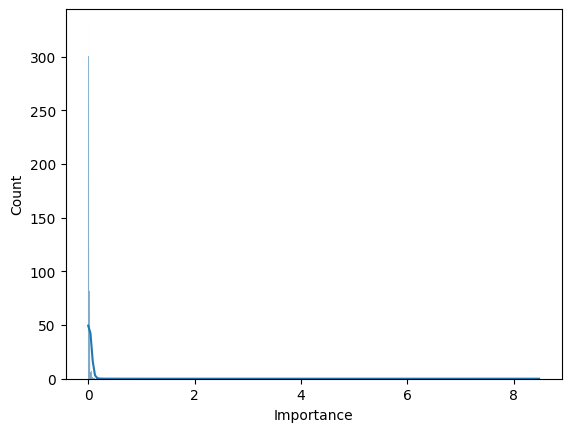

In [251]:
sns.histplot(catboost_importance_df['Importance'], kde=True)

In [253]:
1/20

0.05

In [254]:
catboost_importance_df['Importance'].describe(percentiles=[0.01, 0.03] + [(i+1)/20 for i in range(20)] + [0.97, 0.99])

count    3701.000000
mean        0.027020
std         0.234362
min         0.000000
1%          0.000030
3%          0.001085
5%          0.001644
10%         0.002854
15%         0.003907
20%         0.004876
25%         0.005954
30%         0.006972
35%         0.007830
40%         0.008859
45%         0.009737
50%         0.010860
55%         0.012213
60%         0.013468
65%         0.014817
70%         0.016446
75%         0.018762
80%         0.021521
85%         0.025191
90%         0.030639
95%         0.042513
97%         0.056209
99%         0.144565
100%        8.478955
max         8.478955
Name: Importance, dtype: float64

In [255]:
catboost_importance_df['Importance'].quantile(0.5)

0.010859836443667184

In [256]:
unimportant_df = catboost_importance_df[catboost_importance_df['Importance'] <= catboost_importance_df['Importance'].quantile(0.5)]
print(unimportant_df.shape)
unimportant_df

(1851, 2)


Feature  Importance
3439   battery_use_since_wear_time_of_day_hour_window_6_97%    0.010860
285                                         Y_weekday_3_97%    0.010859
576                                    anglez_weekday_3_70%    0.010858
845                     battery_use_since_wear_weekday_5_5%    0.010852
1754                        Z_time_of_day_hour_window_3_std    0.010842
...                                                     ...         ...
3414   battery_use_since_wear_time_of_day_hour_window_3_95%    0.000000
1175                       X_time_of_day_hour_window_19_std    0.000000
676                                     light_weekday_2_70%    0.000000
1173                       X_time_of_day_hour_window_18_sum    0.000000
3485  battery_use_since_wear_time_of_day_hour_window_10_25%    0.000000

[1851 rows x 2 columns]

In [257]:
unimportance_cols = unimportant_df['Feature'].tolist()
selected_df = selected_df.drop(unimportance_cols, axis=1)
print(selected_df.shape)
selected_df.head()

(2736, 1852)


id  Basic_Demos-Age  CGAS-CGAS_Score  Physical-BMI  Physical-Height  \
0  00008ff9              5.0             51.0     16.877316             46.0   
1  000fd460              9.0             63.2     14.035590             48.0   
2  00105258             10.0             71.0     16.648696             56.5   
3  00115b9f              9.0             71.0     18.292347             56.0   
4  001f3379             13.0             50.0     22.279952             59.5   

   Physical-Weight  Physical-Waist_Circumference  Physical-Diastolic_BP  \
0             50.8                          24.0                   74.0   
1             46.0                          22.0                   75.0   
2             75.6                          26.6                   65.0   
3             81.6                          27.6                   60.0   
4            112.2                          28.8                   60.0   

   Physical-HeartRate  Physical-Systolic_BP  Fitness_Endurance-Max_Stage  \
0                80.6                 126.2                          4.8   
1                70.0                 122.0                          5.8   
2                94.0                 117.0                          5.0   
3                97.0                 117.0                          6.0   
4                73.0                 102.0                          5.0   

   FGC-FGC_CU  FGC-FGC_GSND  FGC-FGC_GSD  FGC-FGC_PU  FGC-FGC_PU_Zone  \
0         0.0         22.04        23.22         0.0              0.0   
1         3.0         21.86        23.60         5.0              0.0   
2        20.0         10.20        14.70         7.0              1.0   
3        18.0         15.10        16.38         5.0              0.0   
4        12.0         16.50        17.90         6.0              0.0   

   FGC-FGC_SRL  FGC-FGC_SRR  FGC-FGC_TL  BIA-BIA_BMC  BIA-BIA_BMR  \
0          7.0          6.0         6.0      2.66855     932.4980   
1         11.0         11.0         3.0      2.57949     936.6560   
2         10.0         10.0         5.0      5.41788    1467.2444   
3          7.0          7.0         7.0      3.84191    1131.4300   
4         10.0         11.0         8.0      4.33036    1330.9700   

   BIA-BIA_DEE  BIA-BIA_ECW  BIA-BIA_FFM  BIA-BIA_FFMI  BIA-BIA_Fat  \
0      1492.00      8.25598     41.58620      13.81770     9.213770   
1      1498.65      6.01993     42.02910      12.82540     3.970850   
2      2453.97     28.91255     98.54372      24.13322   -31.703718   
3      1923.44     15.59250     62.77570      14.07400    18.824300   
4      1996.45     30.21240     84.02850      16.68770    67.971500   

   BIA-BIA_ICW  BIA-BIA_LDM  BIA-BIA_LST  BIA-BIA_SMM  BIA-BIA_TBW  \
0     24.43490      8.89536     38.91770     19.54130     32.69090   
1     21.03520     14.97400     39.44970     15.41070     27.05520   
2     42.82784     26.80338     93.12578     58.78814     71.74042   
3     30.40410     16.77900     58.93380     26.47980     45.99660   
4     32.91410     20.90200     79.69820     35.38040     63.12650   

   PAQ_A-PAQ_A_Total  PAQ_C-PAQ_C_Total  SDS-SDS_Total_Raw  SDS-SDS_Total_T  \
0              1.474              2.456               41.6             58.6   
1              1.912              2.340               46.0             64.0   
2              2.358              2.170               38.0             54.0   
3              1.836              2.451               31.0             45.0   
4              1.896              4.110               40.0             56.0   

   PreInt_EduHx-computerinternet_hoursday  Physical-Waist_Circumference_isnan  \
0                                     3.0                                 1.0   
1                                     0.0                                 0.0   
2                                     2.0                                 1.0   
3                                     0.0                                 1.0   
4                                     

In [259]:
catboost_params = {
    'learning_rate': 0.01,
    'depth': 8,
    'iterations': 2000,
    'random_seed': SEED,
    'verbose': 0,
    'l2_leaf_reg': 50,  # Increase this value
    'task_type': 'GPU',
    'use_best_model': True,
    'early_stopping_rounds': 20,
    #'colsample_bylevel': 0.8
    'boosting_type': 'Plain'
}

CatBoost_Model = CatBoostRegressor(
    **catboost_params
)

catboost_models_list = TrainML(CatBoost_Model, selected_df)#, test_final)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

----> || Train Optimized QWK SCORE ::  0.800
----> || Val Optimized QWK SCORE ::  0.520
----> || Train Optimized Val QWK SCORE ::  0.512
----> || Val Optimized Train QWK SCORE ::  0.795
Fold 1 - Rounded Train QWK: 0.6696, Rounded Validation QWK: 0.4186


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

----> || Train Optimized QWK SCORE ::  0.782
----> || Val Optimized QWK SCORE ::  0.406
----> || Train Optimized Val QWK SCORE ::  0.434
----> || Val Optimized Train QWK SCORE ::  0.670
Fold 2 - Rounded Train QWK: 0.6548, Rounded Validation QWK: 0.3726


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

----> || Train Optimized QWK SCORE ::  0.745
----> || Val Optimized QWK SCORE ::  0.352
----> || Train Optimized Val QWK SCORE ::  0.380
----> || Val Optimized Train QWK SCORE ::  0.671
Fold 3 - Rounded Train QWK: 0.5816, Rounded Validation QWK: 0.3154


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

----> || Train Optimized QWK SCORE ::  0.768
----> || Val Optimized QWK SCORE ::  0.459
----> || Train Optimized Val QWK SCORE ::  0.482
----> || Val Optimized Train QWK SCORE ::  0.687
Fold 4 - Rounded Train QWK: 0.6351, Rounded Validation QWK: 0.3982


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

----> || Train Optimized QWK SCORE ::  0.761
----> || Val Optimized QWK SCORE ::  0.378
----> || Train Optimized Val QWK SCORE ::  0.449
----> || Val Optimized Train QWK SCORE ::  0.613
Fold 5 - Rounded Train QWK: 0.6164, Rounded Validation QWK: 0.3707
Mean Train QWK --> 0.7712
Mean Validation QWK ---> 0.4231
----> || Optimized QWK SCORE ::  0.456


In [260]:
catboost_importance_df = feature_importance(catboost_models_list, selected_df.drop(['id', 'sii'], axis=1))
print(catboost_importance_df.shape)
catboost_importance_df

(1850, 2)


Feature  Importance
1836                     Internet_Hours_Age    6.547602
32                        SDS-SDS_Total_Raw    6.539306
33                          SDS-SDS_Total_T    5.477559
0                           Basic_Demos-Age    3.051050
3                           Physical-Height    2.319828
...                                     ...         ...
1379  anglez_time_of_day_hour_window_12_85%    0.003487
911        Z_time_of_day_hour_window_11_45%    0.003000
753        Y_time_of_day_hour_window_19_max    0.002740
829         Z_time_of_day_hour_window_2_97%    0.001867
479         X_time_of_day_hour_window_6_15%    0.001327

[1850 rows x 2 columns]

<Axes: xlabel='Importance', ylabel='Count'>

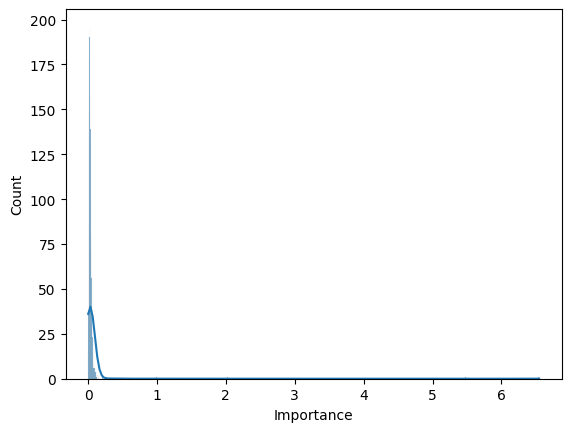

In [261]:
sns.histplot(catboost_importance_df['Importance'], kde=True)

In [263]:
catboost_importance_df['Importance'].describe(percentiles=[0.01, 0.03] + [(i+1)/20 for i in range(19)] + [0.97, 0.99])

count    1850.000000
mean        0.054054
std         0.280447
min         0.001327
1%          0.005835
3%          0.008773
5%          0.010749
10%         0.013327
15%         0.015490
20%         0.017529
25%         0.019255
30%         0.021104
35%         0.022710
40%         0.024509
45%         0.026136
50%         0.028349
55%         0.030649
60%         0.032705
65%         0.035257
70%         0.037700
75%         0.041339
80%         0.045498
85%         0.050574
90%         0.059874
95%         0.079052
97%         0.101909
99%         0.409216
max         6.547602
Name: Importance, dtype: float64

In [265]:
unimportant_df = catboost_importance_df[catboost_importance_df['Importance'] <= catboost_importance_df['Importance'].quantile(0.5)]
unimportance_cols = unimportant_df['Feature'].tolist()
selected_df = selected_df.drop(unimportance_cols, axis=1)
print(selected_df.shape)
selected_df.head()

(2736, 927)


id  Basic_Demos-Age  CGAS-CGAS_Score  Physical-BMI  Physical-Height  \
0  00008ff9              5.0             51.0     16.877316             46.0   
1  000fd460              9.0             63.2     14.035590             48.0   
2  00105258             10.0             71.0     16.648696             56.5   
3  00115b9f              9.0             71.0     18.292347             56.0   
4  001f3379             13.0             50.0     22.279952             59.5   

   Physical-Weight  Physical-Waist_Circumference  Physical-Diastolic_BP  \
0             50.8                          24.0                   74.0   
1             46.0                          22.0                   75.0   
2             75.6                          26.6                   65.0   
3             81.6                          27.6                   60.0   
4            112.2                          28.8                   60.0   

   Physical-HeartRate  Physical-Systolic_BP  FGC-FGC_CU  FGC-FGC_GSND  \
0                80.6                 126.2         0.0         22.04   
1                70.0                 122.0         3.0         21.86   
2                94.0                 117.0        20.0         10.20   
3                97.0                 117.0        18.0         15.10   
4                73.0                 102.0        12.0         16.50   

   FGC-FGC_GSD  FGC-FGC_PU  FGC-FGC_PU_Zone  FGC-FGC_SRL  FGC-FGC_SRR  \
0        23.22         0.0              0.0          7.0          6.0   
1        23.60         5.0              0.0         11.0         11.0   
2        14.70         7.0              1.0         10.0         10.0   
3        16.38         5.0              0.0          7.0          7.0   
4        17.90         6.0              0.0         10.0         11.0   

   FGC-FGC_TL  BIA-BIA_BMC  BIA-BIA_BMR  BIA-BIA_DEE  BIA-BIA_ECW  \
0         6.0      2.66855     932.4980      1492.00      8.25598   
1         3.0      2.57949     936.6560      1498.65      6.01993   
2         5.0      5.41788    1467.2444      2453.97     28.91255   
3         7.0      3.84191    1131.4300      1923.44     15.59250   
4         8.0      4.33036    1330.9700      1996.45     30.21240   

   BIA-BIA_FFM  BIA-BIA_FFMI  BIA-BIA_Fat  BIA-BIA_ICW  BIA-BIA_LDM  \
0     41.58620      13.81770     9.213770     24.43490      8.89536   
1     42.02910      12.82540     3.970850     21.03520     14.97400   
2     98.54372      24.13322   -31.703718     42.82784     26.80338   
3     62.77570      14.07400    18.824300     30.40410     16.77900   
4     84.02850      16.68770    67.971500     32.91410     20.90200   

   BIA-BIA_LST  BIA-BIA_SMM  BIA-BIA_TBW  PAQ_A-PAQ_A_Total  \
0     38.91770     19.54130     32.69090              1.474   
1     39.44970     15.41070     27.05520              1.912   
2     93.12578     58.78814     71.74042              2.358   
3     58.93380     26.47980     45.99660              1.836   
4     79.69820     35.38040     63.12650              1.896   

   PAQ_C-PAQ_C_Total  SDS-SDS_Total_Raw  SDS-SDS_Total_T  \
0              2.456               41.6             58.6   
1              2.340               46.0             64.0   
2              2.170               38.0             54.0   
3              2.451               31.0             45.0   
4              4.110               40.0             56.0   

   PreInt_EduHx-computerinternet_hoursday  Physical-Waist_Circumference_isnan  \
0                                     3.0                                 1.0   
1                                     0.0                                 0.0   
2                                     2.0                                 1.0   
3                                     0.0                                 1.0   
4                                     0.0                                 1.0   

      X_max     Y_std     Y_95%     Y_99%     Z_std     Z_97%  enmo_std  \
0  1.317400  0.453602  0.819044  0.965336  0.550372  0.

In [267]:
catboost_params = {
    'learning_rate': 0.01,
    'depth': 8,
    'iterations': 2000,
    'random_seed': SEED,
    'verbose': 0,
    'l2_leaf_reg': 50,  # Increase this value
    'task_type': 'GPU',
    'use_best_model': True,
    'early_stopping_rounds': 30,
    #'colsample_bylevel': 0.8
    'boosting_type': 'Ordered'
}

CatBoost_Model = CatBoostRegressor(
    **catboost_params
)

catboost_models_list = TrainML(CatBoost_Model, selected_df)#, test_final)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

----> || Train Optimized QWK SCORE ::  0.643
----> || Val Optimized QWK SCORE ::  0.506
----> || Train Optimized Val QWK SCORE ::  0.506
----> || Val Optimized Train QWK SCORE ::  0.639
Fold 1 - Rounded Train QWK: 0.5602, Rounded Validation QWK: 0.3920


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

----> || Train Optimized QWK SCORE ::  0.599
----> || Val Optimized QWK SCORE ::  0.484
----> || Train Optimized Val QWK SCORE ::  0.482
----> || Val Optimized Train QWK SCORE ::  0.544
Fold 2 - Rounded Train QWK: 0.5030, Rounded Validation QWK: 0.4190


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

----> || Train Optimized QWK SCORE ::  0.731
----> || Val Optimized QWK SCORE ::  0.423
----> || Train Optimized Val QWK SCORE ::  0.450
----> || Val Optimized Train QWK SCORE ::  0.680
Fold 3 - Rounded Train QWK: 0.6638, Rounded Validation QWK: 0.4179


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

----> || Train Optimized QWK SCORE ::  0.752
----> || Val Optimized QWK SCORE ::  0.474
----> || Train Optimized Val QWK SCORE ::  0.484
----> || Val Optimized Train QWK SCORE ::  0.675
Fold 4 - Rounded Train QWK: 0.6686, Rounded Validation QWK: 0.4698


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

----> || Train Optimized QWK SCORE ::  0.630
----> || Val Optimized QWK SCORE ::  0.360
----> || Train Optimized Val QWK SCORE ::  0.399
----> || Val Optimized Train QWK SCORE ::  0.532
Fold 5 - Rounded Train QWK: 0.5157, Rounded Validation QWK: 0.3273
Mean Train QWK --> 0.6708
Mean Validation QWK ---> 0.4493
----> || Optimized QWK SCORE ::  0.471


In [268]:
catboost_importance_df = feature_importance(catboost_models_list, selected_df.drop(['id', 'sii'], axis=1))
print(catboost_importance_df.shape)
catboost_importance_df

(925, 2)


Feature  Importance
912               Internet_Hours_Age    9.224933
31                 SDS-SDS_Total_Raw    8.960541
32                   SDS-SDS_Total_T    7.179762
0                    Basic_Demos-Age    5.181796
3                    Physical-Height    3.310143
..                               ...         ...
272  Y_time_of_day_hour_window_0_95%    0.002281
55                   X_weekday_3_97%    0.002093
167              light_weekday_5_15%    0.001019
270  Y_time_of_day_hour_window_0_80%    0.000400
13                   FGC-FGC_PU_Zone    0.000000

[925 rows x 2 columns]

<Axes: xlabel='Importance', ylabel='Count'>

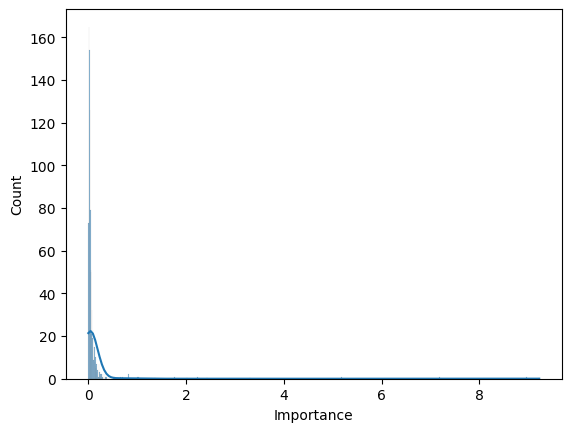

In [269]:
sns.histplot(catboost_importance_df['Importance'], kde=True)

In [270]:
unimportant_df = catboost_importance_df[catboost_importance_df['Importance'] <= catboost_importance_df['Importance'].quantile(0.5)]
unimportance_cols = unimportant_df['Feature'].tolist()
selected_df2 = selected_df.drop(unimportance_cols, axis=1)
print(selected_df2.shape)
selected_df2.head()

(2736, 464)


id  Basic_Demos-Age  CGAS-CGAS_Score  Physical-BMI  Physical-Height  \
0  00008ff9              5.0             51.0     16.877316             46.0   
1  000fd460              9.0             63.2     14.035590             48.0   
2  00105258             10.0             71.0     16.648696             56.5   
3  00115b9f              9.0             71.0     18.292347             56.0   
4  001f3379             13.0             50.0     22.279952             59.5   

   Physical-Weight  Physical-Waist_Circumference  Physical-HeartRate  \
0             50.8                          24.0                80.6   
1             46.0                          22.0                70.0   
2             75.6                          26.6                94.0   
3             81.6                          27.6                97.0   
4            112.2                          28.8                73.0   

   Physical-Systolic_BP  FGC-FGC_CU  FGC-FGC_GSND  FGC-FGC_GSD  FGC-FGC_PU  \
0                 126.2         0.0         22.04        23.22         0.0   
1                 122.0         3.0         21.86        23.60         5.0   
2                 117.0        20.0         10.20        14.70         7.0   
3                 117.0        18.0         15.10        16.38         5.0   
4                 102.0        12.0         16.50        17.90         6.0   

   FGC-FGC_SRR  FGC-FGC_TL  BIA-BIA_BMC  BIA-BIA_BMR  BIA-BIA_DEE  \
0          6.0         6.0      2.66855     932.4980      1492.00   
1         11.0         3.0      2.57949     936.6560      1498.65   
2         10.0         5.0      5.41788    1467.2444      2453.97   
3          7.0         7.0      3.84191    1131.4300      1923.44   
4         11.0         8.0      4.33036    1330.9700      1996.45   

   BIA-BIA_ECW  BIA-BIA_FFM  BIA-BIA_ICW  BIA-BIA_LDM  BIA-BIA_LST  \
0      8.25598     41.58620     24.43490      8.89536     38.91770   
1      6.01993     42.02910     21.03520     14.97400     39.44970   
2     28.91255     98.54372     42.82784     26.80338     93.12578   
3     15.59250     62.77570     30.40410     16.77900     58.93380   
4     30.21240     84.02850     32.91410     20.90200     79.69820   

   BIA-BIA_SMM  BIA-BIA_TBW  SDS-SDS_Total_Raw  SDS-SDS_Total_T  \
0     19.54130     32.69090               41.6             58.6   
1     15.41070     27.05520               46.0             64.0   
2     58.78814     71.74042               38.0             54.0   
3     26.47980     45.99660               31.0             45.0   
4     35.38040     63.12650               40.0             56.0   

   PreInt_EduHx-computerinternet_hoursday  Physical-Waist_Circumference_isnan  \
0                                     3.0                                 1.0   
1                                     0.0                                 0.0   
2                                     2.0                                 1.0   
3                                     0.0                                 1.0   
4                                     0.0                                 1.0   

      Y_std     Z_std  enmo_std  enmo_97%  enmo_99%  anglez_95%  anglez_97%  \
0  0.453602  0.550372  0.091819  0.243180  0.435339   61.945976   68.108751   
1  0.513454  0.589627  0.120810  0.318934  0.607297   69.131664   74.714546   
2  0.472145  0.565789  0.142927  0.309369  0.688840   61.211522   68.894517   
3  0.502702  0.585710  0.106351  0.254348  0.485119   74.499702   83.422098   
4  0.454752  0.623933  0.040610  0.099575  0.176236   69.333694   75.295980   

   anglez_99%    light_max  X_weekday_3_min  Y_weekday_1_mean  \
0   78.189699  2360.559985        -1.181594          0.043603   
1   82.146591  1677.273306        -1.175764          0.082675   
2   80.908972  2602.789990        -1.384442         -0.022088   
3   87.039652  2633.250000        -0.973490          0.060860   
4   84.212067  2597.800049        -1.015088         -0.233639   

   Y_weekday_1_20%  Y_weekday_1_25

In [305]:
catboost_params = {
    'learning_rate': 0.02,
    'depth': 9,
    'iterations': 2000,
    'random_seed': SEED,
    'verbose': 0,
    'l2_leaf_reg': 50,  # Increase this value
    'task_type': 'GPU',
    'use_best_model': True,
    'early_stopping_rounds': 30,
    #'subsample': 0.8,
    'boosting_type': 'Ordered'
}

CatBoost_Model = CatBoostRegressor(
    **catboost_params
)

catboost_models_list2 = TrainML(CatBoost_Model, selected_df2)#, test_final)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

----> || Train Optimized QWK SCORE ::  0.740
----> || Val Optimized QWK SCORE ::  0.503
----> || Train Optimized Val QWK SCORE ::  0.477
----> || Val Optimized Train QWK SCORE ::  0.735
Fold 1 - Rounded Train QWK: 0.6649, Rounded Validation QWK: 0.3898


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

----> || Train Optimized QWK SCORE ::  0.755
----> || Val Optimized QWK SCORE ::  0.479
----> || Train Optimized Val QWK SCORE ::  0.511
----> || Val Optimized Train QWK SCORE ::  0.682
Fold 2 - Rounded Train QWK: 0.6881, Rounded Validation QWK: 0.4680


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

----> || Train Optimized QWK SCORE ::  0.667
----> || Val Optimized QWK SCORE ::  0.504
----> || Train Optimized Val QWK SCORE ::  0.493
----> || Val Optimized Train QWK SCORE ::  0.657
Fold 3 - Rounded Train QWK: 0.5785, Rounded Validation QWK: 0.4204


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

----> || Train Optimized QWK SCORE ::  0.624
----> || Val Optimized QWK SCORE ::  0.373
----> || Train Optimized Val QWK SCORE ::  0.420
----> || Val Optimized Train QWK SCORE ::  0.536
Fold 4 - Rounded Train QWK: 0.5453, Rounded Validation QWK: 0.3554


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

----> || Train Optimized QWK SCORE ::  0.764
----> || Val Optimized QWK SCORE ::  0.426
----> || Train Optimized Val QWK SCORE ::  0.413
----> || Val Optimized Train QWK SCORE ::  0.705
Fold 5 - Rounded Train QWK: 0.7030, Rounded Validation QWK: 0.4201
Mean Train QWK --> 0.7101
Mean Validation QWK ---> 0.4570
----> || Optimized QWK SCORE ::  0.471


In [322]:
catboost_importance_df = feature_importance(catboost_models_list2, selected_df2.drop(['id', 'sii'], axis=1))
print(catboost_importance_df.shape)
catboost_importance_df

(462, 2)


Feature  Importance
24                                       SDS-SDS_Total_Raw    8.067017
451                                     Internet_Hours_Age    6.797055
25                                         SDS-SDS_Total_T    6.483509
0                                          Basic_Demos-Age    5.967511
3                                          Physical-Height    3.480979
452                                     BMI_Internet_Hours    3.063766
20                                             BIA-BIA_LDM    2.236663
26                  PreInt_EduHx-computerinternet_hoursday    1.980441
448                                      Basic_Demos-Sex_0    1.819053
449                                      Basic_Demos-Sex_1    1.657604
11                                              FGC-FGC_PU    0.977613
16                                             BIA-BIA_DEE    0.795162
91                                     light_weekday_4_max    0.790676
454                                                FMI_BFP    0.781106
8                                               FGC-FGC_CU    0.777832
459                                             SMM_Height    0.732210
19                                             BIA-BIA_ICW    0.721391
450                                                BMI_Age    0.711778
5                             Physical-Waist_Circumference    0.682405
4                                          Physical-Weight    0.592884
397                   light_time_of_day_hour_window_10_max    0.567881
168                       Y_time_of_day_hour_window_15_min    0.557024
287                    enmo_time_of_day_hour_window_13_99%    0.551314
27                      Physical-Waist_Circumference_isnan    0.519088
22                                             BIA-BIA_SMM    0.466235
9                                             FGC-FGC_GSND    0.418389
410                   light_time_of_day_hour_window_15_max    0.418186
310                    enmo_time_of_day_hour_window_15_max    0.416861
178                       Y_time_of_day_hour_window_19_90%    0.409741
271                    enmo_time_of_day_hour_window_10_65%    0.389344
128                       X_time_of_day_hour_window_15_max    0.381831
23                                             BIA-BIA_TBW    0.381556
457                                             BMR_Weight    0.379879
350                  anglez_time_of_day_hour_window_11_15%    0.377871
1                                          CGAS-CGAS_Score    0.363695
391                    light_time_of_day_hour_window_7_max    0.362709
74                                    anglez_weekday_1_45%    0.343334
184                       Y_time_of_day_hour_window_20_15%    0.302081
32                                                enmo_99%    0.299885
33                                              anglez_95%    0.293859
349                  anglez_time_of_day_hour_window_11_10%    0.291183
93                                     light_weekday_5_99%    0.290368
415                   light_time_of_day_hour_window_17_35%    0.284045
222                       Z_time_of_day_hour_window_16_max    0.268854
149                        Y_time_of_day_hour_window_4_65%    0.257926
239                       Z_time_of_day_hour_window_23_min    0.256519
393                    light_time_of_day_hour_window_8_std    0.255721
34                                              anglez_97%    0.250317
320                    enmo_time_of_day_hour_window_18_max    0.249749
78                                    anglez_weekday_4_99%    0.249601
213                        Z_time_of_day_hour_window_8_97%    0.249280
109                   battery_use_since_wear_weekday_5_max    0.247319
392                   light_time_of_day_hour_window_8_mean    0.245812
256                    enmo_time_of_day_hour_window_8_mean    0.242723
228                        Z_time_of_day_hour_window_20_1%    0.237052
122                        X_time_of_day_hour_window_6_65%    0.234199
347 

<Axes: xlabel='Importance', ylabel='Count'>

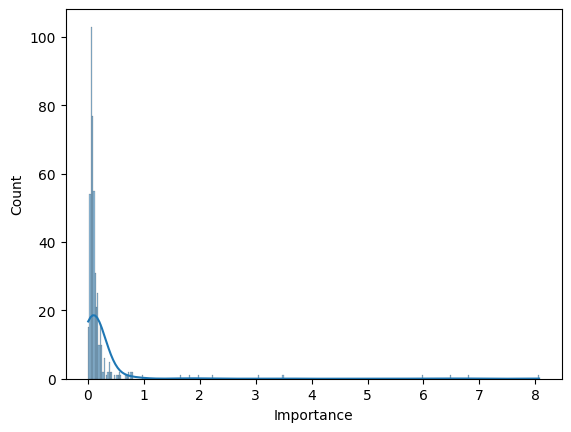

In [323]:
sns.histplot(catboost_importance_df['Importance'], kde=True)

In [324]:
catboost_importance_df['Importance'].describe(percentiles=[0.01, 0.03] + [(i+1)/20 for i in range(19)] + [0.97, 0.99])

count    462.000000
mean       0.216450
std        0.688913
min        0.006162
1%         0.016021
3%         0.028355
5%         0.034552
10%        0.042953
15%        0.051987
20%        0.057058
25%        0.061408
30%        0.066931
35%        0.072390
40%        0.076952
45%        0.084154
50%        0.090820
55%        0.099455
60%        0.108009
65%        0.119652
70%        0.136868
75%        0.149695
80%        0.174979
85%        0.215679
90%        0.255180
95%        0.516446
97%        0.778389
99%        3.226479
max        8.067017
Name: Importance, dtype: float64

In [325]:
unimportant_df = catboost_importance_df[catboost_importance_df['Importance'] <= catboost_importance_df['Importance'].quantile(0.5)]

<Axes: xlabel='Importance', ylabel='Count'>

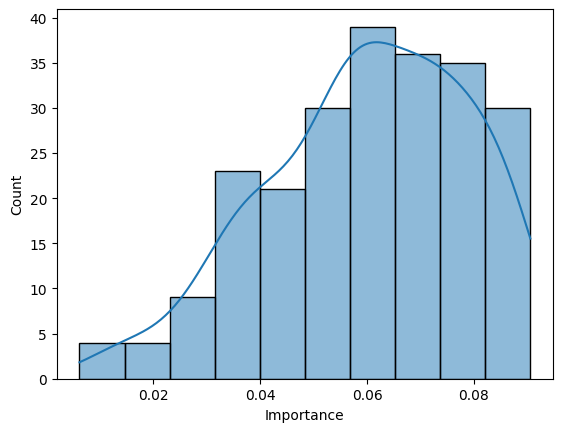

In [326]:
sns.histplot(unimportant_df['Importance'], kde=True)

In [327]:
unimportance_cols = unimportant_df['Feature'].tolist()
selected_df3 = selected_df2.drop(unimportance_cols, axis=1)
print(selected_df3.shape)
selected_df3.head()

(2736, 233)


id  Basic_Demos-Age  CGAS-CGAS_Score  Physical-BMI  Physical-Height  \
0  00008ff9              5.0             51.0     16.877316             46.0   
1  000fd460              9.0             63.2     14.035590             48.0   
2  00105258             10.0             71.0     16.648696             56.5   
3  00115b9f              9.0             71.0     18.292347             56.0   
4  001f3379             13.0             50.0     22.279952             59.5   

   Physical-Weight  Physical-Waist_Circumference  Physical-HeartRate  \
0             50.8                          24.0                80.6   
1             46.0                          22.0                70.0   
2             75.6                          26.6                94.0   
3             81.6                          27.6                97.0   
4            112.2                          28.8                73.0   

   Physical-Systolic_BP  FGC-FGC_CU  FGC-FGC_GSND  FGC-FGC_GSD  FGC-FGC_PU  \
0                 126.2         0.0         22.04        23.22         0.0   
1                 122.0         3.0         21.86        23.60         5.0   
2                 117.0        20.0         10.20        14.70         7.0   
3                 117.0        18.0         15.10        16.38         5.0   
4                 102.0        12.0         16.50        17.90         6.0   

   FGC-FGC_SRR  BIA-BIA_BMC  BIA-BIA_BMR  BIA-BIA_DEE  BIA-BIA_FFM  \
0          6.0      2.66855     932.4980      1492.00     41.58620   
1         11.0      2.57949     936.6560      1498.65     42.02910   
2         10.0      5.41788    1467.2444      2453.97     98.54372   
3          7.0      3.84191    1131.4300      1923.44     62.77570   
4         11.0      4.33036    1330.9700      1996.45     84.02850   

   BIA-BIA_ICW  BIA-BIA_LDM  BIA-BIA_LST  BIA-BIA_SMM  BIA-BIA_TBW  \
0     24.43490      8.89536     38.91770     19.54130     32.69090   
1     21.03520     14.97400     39.44970     15.41070     27.05520   
2     42.82784     26.80338     93.12578     58.78814     71.74042   
3     30.40410     16.77900     58.93380     26.47980     45.99660   
4     32.91410     20.90200     79.69820     35.38040     63.12650   

   SDS-SDS_Total_Raw  SDS-SDS_Total_T  PreInt_EduHx-computerinternet_hoursday  \
0               41.6             58.6                                     3.0   
1               46.0             64.0                                     0.0   
2               38.0             54.0                                     2.0   
3               31.0             45.0                                     0.0   
4               40.0             56.0                                     0.0   

   Physical-Waist_Circumference_isnan     Z_std  enmo_std  enmo_99%  \
0                                 1.0  0.550372  0.091819  0.435339   
1                                 0.0  0.589627  0.120810  0.607297   
2                                 1.0  0.565789  0.142927  0.688840   
3                                 1.0  0.585710  0.106351  0.485119   
4                                 1.0  0.623933  0.040610  0.176236   

   anglez_95%  anglez_97%  anglez_99%  X_weekday_3_min  Y_weekday_1_45%  \
0   61.945976   68.108751   78.189699        -1.181594        -0.006635   
1   69.131664   74.714546   82.146591        -1.175764         0.033658   
2   61.211522   68.894517   80.908972        -1.384442        -0.066807   
3   74.499702   83.422098   87.039652        -0.973490         0.092507   
4   69.333694   75.295980   84.212067        -1.015088        -0.331530   

   Y_weekday_1_75%  Y_weekday_2_70%  Y_weekday_2_75%  Z_weekday_1_min  \
0         0.288892         0.228419         0.306724        -1.001339   
1         0.324312         0.351217         0.456668        -1.000690   
2         0.224092         0.177141         0.234211        -1.001535   
3         0.435293         0.584620         0.652526        -1.013281   
4         0.015589         0.099477         0.193994  

In [328]:
catboost_params = {
    'learning_rate': 0.02,
    'depth': 9,
    'iterations': 2000,
    'random_seed': SEED,
    'verbose': 0,
    'l2_leaf_reg': 50,  # Increase this value
    'task_type': 'GPU',
    'use_best_model': True,
    'early_stopping_rounds': 30,
    #'subsample': 0.8,
    'boosting_type': 'Ordered'
}

CatBoost_Model = CatBoostRegressor(
    **catboost_params
)

catboost_models_list3 = TrainML(CatBoost_Model, selected_df3)#, test_final)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

----> || Train Optimized QWK SCORE ::  0.843
----> || Val Optimized QWK SCORE ::  0.525
----> || Train Optimized Val QWK SCORE ::  0.481
----> || Val Optimized Train QWK SCORE ::  0.815
Fold 1 - Rounded Train QWK: 0.7870, Rounded Validation QWK: 0.4210


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

----> || Train Optimized QWK SCORE ::  0.779
----> || Val Optimized QWK SCORE ::  0.472
----> || Train Optimized Val QWK SCORE ::  0.520
----> || Val Optimized Train QWK SCORE ::  0.693
Fold 2 - Rounded Train QWK: 0.7099, Rounded Validation QWK: 0.4661


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

----> || Train Optimized QWK SCORE ::  0.759
----> || Val Optimized QWK SCORE ::  0.507
----> || Train Optimized Val QWK SCORE ::  0.496
----> || Val Optimized Train QWK SCORE ::  0.753
Fold 3 - Rounded Train QWK: 0.6961, Rounded Validation QWK: 0.4332


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

----> || Train Optimized QWK SCORE ::  0.600
----> || Val Optimized QWK SCORE ::  0.444
----> || Train Optimized Val QWK SCORE ::  0.432
----> || Val Optimized Train QWK SCORE ::  0.599
Fold 4 - Rounded Train QWK: 0.5317, Rounded Validation QWK: 0.3544


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

----> || Train Optimized QWK SCORE ::  0.775
----> || Val Optimized QWK SCORE ::  0.430
----> || Train Optimized Val QWK SCORE ::  0.428
----> || Val Optimized Train QWK SCORE ::  0.730
Fold 5 - Rounded Train QWK: 0.7154, Rounded Validation QWK: 0.3903
Mean Train QWK --> 0.7513
Mean Validation QWK ---> 0.4755
----> || Optimized QWK SCORE ::  0.485


In [304]:
catboost_params = {
    'learning_rate': 0.02,
    'depth': 9,
    'iterations': 2000,
    'random_seed': SEED,
    'verbose': 0,
    'l2_leaf_reg': 50,  # Increase this value
    'task_type': 'GPU',
    'use_best_model': True,
    'early_stopping_rounds': 30,
    #'subsample': 0.8,
    'boosting_type': 'Ordered'
}

CatBoost_Model = CatBoostRegressor(
    **catboost_params
)

catboost_models_list3 = TrainML(CatBoost_Model, selected_df3)#, test_final)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

----> || Train Optimized QWK SCORE ::  0.832
----> || Val Optimized QWK SCORE ::  0.529
----> || Train Optimized Val QWK SCORE ::  0.497
----> || Val Optimized Train QWK SCORE ::  0.802
Fold 1 - Rounded Train QWK: 0.7870, Rounded Validation QWK: 0.4400


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

----> || Train Optimized QWK SCORE ::  0.706
----> || Val Optimized QWK SCORE ::  0.470
----> || Train Optimized Val QWK SCORE ::  0.526
----> || Val Optimized Train QWK SCORE ::  0.634
Fold 2 - Rounded Train QWK: 0.6436, Rounded Validation QWK: 0.4666


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

----> || Train Optimized QWK SCORE ::  0.686
----> || Val Optimized QWK SCORE ::  0.516
----> || Train Optimized Val QWK SCORE ::  0.501
----> || Val Optimized Train QWK SCORE ::  0.683
Fold 3 - Rounded Train QWK: 0.6196, Rounded Validation QWK: 0.4313


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

----> || Train Optimized QWK SCORE ::  0.712
----> || Val Optimized QWK SCORE ::  0.471
----> || Train Optimized Val QWK SCORE ::  0.463
----> || Val Optimized Train QWK SCORE ::  0.699
Fold 4 - Rounded Train QWK: 0.6597, Rounded Validation QWK: 0.3898


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

----> || Train Optimized QWK SCORE ::  0.794
----> || Val Optimized QWK SCORE ::  0.466
----> || Train Optimized Val QWK SCORE ::  0.435
----> || Val Optimized Train QWK SCORE ::  0.782
Fold 5 - Rounded Train QWK: 0.7433, Rounded Validation QWK: 0.4223
Mean Train QWK --> 0.7460
Mean Validation QWK ---> 0.4903
----> || Optimized QWK SCORE ::  0.493


In [330]:
catboost_importance_df = feature_importance(catboost_models_list3, selected_df3.drop(['id', 'sii'], axis=1))
print(catboost_importance_df.shape)
catboost_importance_df

(231, 2)


Feature  Importance
22                                      SDS-SDS_Total_Raw    7.800586
222                                    Internet_Hours_Age    6.303514
23                                        SDS-SDS_Total_T    5.922577
0                                         Basic_Demos-Age    4.641962
3                                         Physical-Height    3.109934
223                                    BMI_Internet_Hours    2.617096
219                                     Basic_Demos-Sex_0    1.851933
24                 PreInt_EduHx-computerinternet_hoursday    1.743872
220                                     Basic_Demos-Sex_1    1.593530
221                                               BMI_Age    1.544095
18                                            BIA-BIA_LDM    1.421924
11                                             FGC-FGC_PU    1.118143
225                                               FMI_BFP    0.965679
15                                            BIA-BIA_DEE    0.946819
229                                            SMM_Height    0.932473
8                                              FGC-FGC_CU    0.880406
88                       Y_time_of_day_hour_window_15_min    0.794112
153                   enmo_time_of_day_hour_window_13_99%    0.779493
25                     Physical-Waist_Circumference_isnan    0.772478
59                                    light_weekday_4_max    0.724818
16                                            BIA-BIA_FFM    0.704605
91                       Y_time_of_day_hour_window_19_90%    0.678645
4                                         Physical-Weight    0.625633
17                                            BIA-BIA_ICW    0.604174
20                                            BIA-BIA_SMM    0.598600
1                                         CGAS-CGAS_Score    0.571677
9                                            FGC-FGC_GSND    0.561708
227                                            BMR_Weight    0.485541
81                        Y_time_of_day_hour_window_4_65%    0.477451
95                       Y_time_of_day_hour_window_20_15%    0.476450
5                            Physical-Waist_Circumference    0.462037
184                 anglez_time_of_day_hour_window_11_15%    0.440821
172                   enmo_time_of_day_hour_window_18_max    0.428424
196                   light_time_of_day_hour_window_7_max    0.421442
210                  light_time_of_day_hour_window_15_max    0.416092
124                      Z_time_of_day_hour_window_23_min    0.415793
76                       X_time_of_day_hour_window_15_max    0.412759
200                  light_time_of_day_hour_window_10_max    0.405922
183                 anglez_time_of_day_hour_window_11_10%    0.396854
218  battery_use_since_wear_time_of_day_hour_window_4_15%    0.390855
197                  light_time_of_day_hour_window_8_mean    0.390410
29                                             anglez_95%    0.385943
60                                    light_weekday_5_99%    0.385093
42                                     enmo_weekday_2_70%    0.374261
32                                        X_weekday_3_min    0.372843
198                   light_time_of_day_hour_window_8_std    0.371329
47                                     enmo_weekday_7_35%    0.363062
82                        Y_time_of_day_hour_window_4_75%    0.362163
228                                            DEE_Weight    0.359699
111                      Z_time_of_day_hour_window_11_std    0.353615
85                        Y_time_of_day_hour_window_8_25%    0.352305
30                                             anglez_97%    0.351088
14                                            BIA-BIA_BMR    0.349531
90                       Y_time_of_day_hour_window_18_30%    0.346795
87                        Y_time_of_day_hour_window_13_5%    0.340127
67                   battery_use_since_wear_weekday_5_max    0.337706
192                   light_time_of_day_hour_window_3_45%   

<Axes: xlabel='Importance', ylabel='Count'>

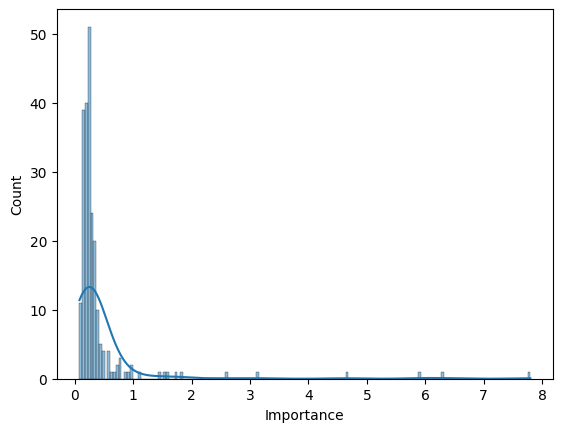

In [331]:
sns.histplot(catboost_importance_df['Importance'], kde=True)

In [332]:
unimportant_df = catboost_importance_df[catboost_importance_df['Importance'] <= catboost_importance_df['Importance'].quantile(0.5)]

<Axes: xlabel='Importance', ylabel='Count'>

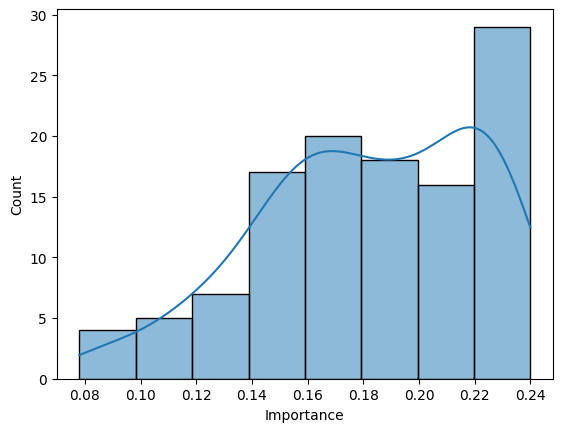

In [333]:
sns.histplot(unimportant_df['Importance'], kde=True)

In [334]:
unimportance_cols = unimportant_df['Feature'].tolist()
selected_df4 = selected_df3.drop(unimportance_cols, axis=1)
print(selected_df4.shape)
selected_df4.head()

(2736, 117)


id  Basic_Demos-Age  CGAS-CGAS_Score  Physical-BMI  Physical-Height  \
0  00008ff9              5.0             51.0     16.877316             46.0   
1  000fd460              9.0             63.2     14.035590             48.0   
2  00105258             10.0             71.0     16.648696             56.5   
3  00115b9f              9.0             71.0     18.292347             56.0   
4  001f3379             13.0             50.0     22.279952             59.5   

   Physical-Weight  Physical-Waist_Circumference  Physical-HeartRate  \
0             50.8                          24.0                80.6   
1             46.0                          22.0                70.0   
2             75.6                          26.6                94.0   
3             81.6                          27.6                97.0   
4            112.2                          28.8                73.0   

   FGC-FGC_CU  FGC-FGC_GSND  FGC-FGC_GSD  FGC-FGC_PU  FGC-FGC_SRR  \
0         0.0         22.04        23.22         0.0          6.0   
1         3.0         21.86        23.60         5.0         11.0   
2        20.0         10.20        14.70         7.0         10.0   
3        18.0         15.10        16.38         5.0          7.0   
4        12.0         16.50        17.90         6.0         11.0   

   BIA-BIA_BMC  BIA-BIA_BMR  BIA-BIA_DEE  BIA-BIA_FFM  BIA-BIA_ICW  \
0      2.66855     932.4980      1492.00     41.58620     24.43490   
1      2.57949     936.6560      1498.65     42.02910     21.03520   
2      5.41788    1467.2444      2453.97     98.54372     42.82784   
3      3.84191    1131.4300      1923.44     62.77570     30.40410   
4      4.33036    1330.9700      1996.45     84.02850     32.91410   

   BIA-BIA_LDM  BIA-BIA_SMM  SDS-SDS_Total_Raw  SDS-SDS_Total_T  \
0      8.89536     19.54130               41.6             58.6   
1     14.97400     15.41070               46.0             64.0   
2     26.80338     58.78814               38.0             54.0   
3     16.77900     26.47980               31.0             45.0   
4     20.90200     35.38040               40.0             56.0   

   PreInt_EduHx-computerinternet_hoursday  Physical-Waist_Circumference_isnan  \
0                                     3.0                                 1.0   
1                                     0.0                                 0.0   
2                                     2.0                                 1.0   
3                                     0.0                                 1.0   
4                                     0.0                                 1.0   

   enmo_99%  anglez_95%  anglez_97%  X_weekday_3_min  Y_weekday_2_70%  \
0  0.435339   61.945976   68.108751        -1.181594         0.228419   
1  0.607297   69.131664   74.714546        -1.175764         0.351217   
2  0.688840   61.211522   68.894517        -1.384442         0.177141   
3  0.485119   74.499702   83.422098        -0.973490         0.584620   
4  0.176236   69.333694   75.295980        -1.015088         0.099477   

   enmo_weekday_2_70%  enmo_weekday_7_35%  anglez_weekday_1_45%  \
0            0.034239            0.009148             -1.073907   
1            0.029046            0.009175              9.273277   
2            0.029672            0.005300            -28.723628   
3            0.030776            0.014524            -14.873286   
4            0.017020            0.001606             15.318235   

   anglez_weekday_4_3%  anglez_weekday_4_99%  light_weekday_4_std  \
0           -69.067759             74.487629            35.396480   
1           -67.381481             78.130621            62.724818   
2           -77.913436             79.615344           154.635794   
3           -69.362376             88.299083           125.539703   
4           -86.888733             79.856454           242.715576   

   light_weekday_4_99%  light_weekday_4_max  light_weekday_5_99%  \
0            82.129353           929.050000 

In [335]:
catboost_params = {
    'learning_rate': 0.02,
    'depth': 9,
    'iterations': 2000,
    'random_seed': SEED,
    'verbose': 0,
    'l2_leaf_reg': 50,  # Increase this value
    'task_type': 'GPU',
    'use_best_model': True,
    'early_stopping_rounds': 30,
    #'subsample': 0.8,
    'boosting_type': 'Ordered'
}

CatBoost_Model = CatBoostRegressor(
    **catboost_params
)

catboost_models_list4 = TrainML(CatBoost_Model, selected_df4)#, test_final)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

----> || Train Optimized QWK SCORE ::  0.820
----> || Val Optimized QWK SCORE ::  0.529
----> || Train Optimized Val QWK SCORE ::  0.516
----> || Val Optimized Train QWK SCORE ::  0.802
Fold 1 - Rounded Train QWK: 0.7654, Rounded Validation QWK: 0.4268


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

----> || Train Optimized QWK SCORE ::  0.745
----> || Val Optimized QWK SCORE ::  0.546
----> || Train Optimized Val QWK SCORE ::  0.520
----> || Val Optimized Train QWK SCORE ::  0.741
Fold 2 - Rounded Train QWK: 0.6788, Rounded Validation QWK: 0.4594


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

----> || Train Optimized QWK SCORE ::  0.758
----> || Val Optimized QWK SCORE ::  0.530
----> || Train Optimized Val QWK SCORE ::  0.512
----> || Val Optimized Train QWK SCORE ::  0.743
Fold 3 - Rounded Train QWK: 0.6935, Rounded Validation QWK: 0.4340


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

----> || Train Optimized QWK SCORE ::  0.620
----> || Val Optimized QWK SCORE ::  0.455
----> || Train Optimized Val QWK SCORE ::  0.436
----> || Val Optimized Train QWK SCORE ::  0.610
Fold 4 - Rounded Train QWK: 0.5424, Rounded Validation QWK: 0.3538


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

----> || Train Optimized QWK SCORE ::  0.745
----> || Val Optimized QWK SCORE ::  0.411
----> || Train Optimized Val QWK SCORE ::  0.433
----> || Val Optimized Train QWK SCORE ::  0.680
Fold 5 - Rounded Train QWK: 0.6833, Rounded Validation QWK: 0.4089
Mean Train QWK --> 0.7377
Mean Validation QWK ---> 0.4943
----> || Optimized QWK SCORE ::  0.491


In [336]:
catboost_importance_df = feature_importance(catboost_models_list4, selected_df4.drop(['id', 'sii'], axis=1))
print(catboost_importance_df.shape)
catboost_importance_df

(115, 2)


Feature  Importance
19                                      SDS-SDS_Total_Raw    7.865694
108                                    Internet_Hours_Age    6.876609
20                                        SDS-SDS_Total_T    6.643491
0                                         Basic_Demos-Age    4.024189
3                                         Physical-Height    3.471984
109                                    BMI_Internet_Hours    2.319670
106                                     Basic_Demos-Sex_1    1.915178
107                                               BMI_Age    1.815817
21                 PreInt_EduHx-computerinternet_hoursday    1.747801
17                                            BIA-BIA_LDM    1.674504
105                                     Basic_Demos-Sex_0    1.666839
10                                             FGC-FGC_PU    1.390091
76                    enmo_time_of_day_hour_window_13_99%    1.164897
14                                            BIA-BIA_DEE    1.100287
110                                               FMI_BFP    1.053563
51                       Y_time_of_day_hour_window_15_min    1.042884
7                                              FGC-FGC_CU    1.025681
35                                    light_weekday_4_max    1.016575
16                                            BIA-BIA_ICW    1.014875
114                                            SMM_Height    0.975052
100                  light_time_of_day_hour_window_17_35%    0.852873
88                  anglez_time_of_day_hour_window_11_15%    0.829713
67                       Z_time_of_day_hour_window_23_min    0.825175
92                   light_time_of_day_hour_window_8_mean    0.823663
22                     Physical-Waist_Circumference_isnan    0.822255
55                       Y_time_of_day_hour_window_20_15%    0.804190
1                                         CGAS-CGAS_Score    0.788265
24                                             anglez_95%    0.783145
80                    enmo_time_of_day_hour_window_17_50%    0.767294
18                                            BIA-BIA_SMM    0.746303
112                                            BMR_Weight    0.735084
53                       Y_time_of_day_hour_window_19_90%    0.729144
45                        Y_time_of_day_hour_window_4_65%    0.725619
95                   light_time_of_day_hour_window_10_max    0.715911
42                       X_time_of_day_hour_window_15_max    0.699363
99                   light_time_of_day_hour_window_15_max    0.690965
86                   anglez_time_of_day_hour_window_8_99%    0.687276
38                   battery_use_since_wear_weekday_5_max    0.660200
13                                            BIA-BIA_BMR    0.658174
8                                            FGC-FGC_GSND    0.651404
78                    enmo_time_of_day_hour_window_15_20%    0.645214
72                    enmo_time_of_day_hour_window_10_60%    0.640360
85                   anglez_time_of_day_hour_window_3_90%    0.607420
103  battery_use_since_wear_time_of_day_hour_window_1_25%    0.606906
4                                         Physical-Weight    0.604869
73                    enmo_time_of_day_hour_window_10_65%    0.604173
49                        Y_time_of_day_hour_window_8_25%    0.603426
87                  anglez_time_of_day_hour_window_11_10%    0.597448
82                    enmo_time_of_day_hour_window_18_max    0.593561
104  battery_use_since_wear_time_of_day_hour_window_4_15%    0.588421
30                                   anglez_weekday_1_45%    0.579787
81                    enmo_time_of_day_hour_window_18_80%    0.576590
93                    light_time_of_day_hour_window_8_std    0.569673
28                                     enmo_weekday_2_70%    0.565145
70                     enmo_time_of_day_hour_window_8_60%    0.558561
32                                   anglez_weekday_4_99%    0.554765
113                                            DEE_Weight   

<Axes: xlabel='Importance', ylabel='Count'>

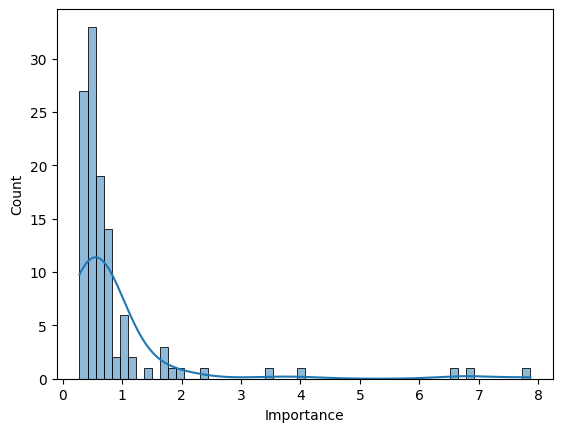

In [337]:
sns.histplot(catboost_importance_df['Importance'], kde=True)

In [350]:
unimportant_df = catboost_importance_df[catboost_importance_df['Importance'] <= catboost_importance_df['Importance'].quantile(0.1)]

<Axes: xlabel='Importance', ylabel='Count'>

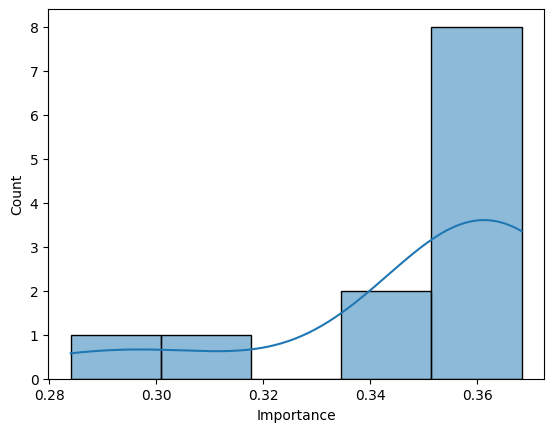

In [351]:
sns.histplot(unimportant_df['Importance'], kde=True)

In [352]:
unimportance_cols = unimportant_df['Feature'].tolist()
selected_df5 = selected_df4.drop(unimportance_cols, axis=1)
print(selected_df5.shape)
selected_df5.head()

(2736, 105)


id  Basic_Demos-Age  CGAS-CGAS_Score  Physical-BMI  Physical-Height  \
0  00008ff9              5.0             51.0     16.877316             46.0   
1  000fd460              9.0             63.2     14.035590             48.0   
2  00105258             10.0             71.0     16.648696             56.5   
3  00115b9f              9.0             71.0     18.292347             56.0   
4  001f3379             13.0             50.0     22.279952             59.5   

   Physical-Weight  Physical-Waist_Circumference  Physical-HeartRate  \
0             50.8                          24.0                80.6   
1             46.0                          22.0                70.0   
2             75.6                          26.6                94.0   
3             81.6                          27.6                97.0   
4            112.2                          28.8                73.0   

   FGC-FGC_CU  FGC-FGC_GSND  FGC-FGC_GSD  FGC-FGC_PU  FGC-FGC_SRR  \
0         0.0         22.04        23.22         0.0          6.0   
1         3.0         21.86        23.60         5.0         11.0   
2        20.0         10.20        14.70         7.0         10.0   
3        18.0         15.10        16.38         5.0          7.0   
4        12.0         16.50        17.90         6.0         11.0   

   BIA-BIA_BMR  BIA-BIA_DEE  BIA-BIA_ICW  BIA-BIA_LDM  BIA-BIA_SMM  \
0     932.4980      1492.00     24.43490      8.89536     19.54130   
1     936.6560      1498.65     21.03520     14.97400     15.41070   
2    1467.2444      2453.97     42.82784     26.80338     58.78814   
3    1131.4300      1923.44     30.40410     16.77900     26.47980   
4    1330.9700      1996.45     32.91410     20.90200     35.38040   

   SDS-SDS_Total_Raw  SDS-SDS_Total_T  PreInt_EduHx-computerinternet_hoursday  \
0               41.6             58.6                                     3.0   
1               46.0             64.0                                     0.0   
2               38.0             54.0                                     2.0   
3               31.0             45.0                                     0.0   
4               40.0             56.0                                     0.0   

   Physical-Waist_Circumference_isnan  anglez_95%  anglez_97%  \
0                                 1.0   61.945976   68.108751   
1                                 0.0   69.131664   74.714546   
2                                 1.0   61.211522   68.894517   
3                                 1.0   74.499702   83.422098   
4                                 1.0   69.333694   75.295980   

   X_weekday_3_min  Y_weekday_2_70%  enmo_weekday_2_70%  enmo_weekday_7_35%  \
0        -1.181594         0.228419            0.034239            0.009148   
1        -1.175764         0.351217            0.029046            0.009175   
2        -1.384442         0.177141            0.029672            0.005300   
3        -0.973490         0.584620            0.030776            0.014524   
4        -1.015088         0.099477            0.017020            0.001606   

   anglez_weekday_1_45%  anglez_weekday_4_3%  anglez_weekday_4_99%  \
0             -1.073907           -69.067759             74.487629   
1              9.273277           -67.381481             78.130621   
2            -28.723628           -77.913436             79.615344   
3            -14.873286           -69.362376             88.299083   
4             15.318235           -86.888733             79.856454   

   light_weekday_4_std  light_weekday_4_99%  light_weekday_4_max  \
0            35.396480            82.129353           929.050000   
1            62.724818           267.659249          1148.777557   
2           154.635794           863.702639          2174.520020   
3           125.539703           512.280000          2318.199951   
4           242.715576          1522.253988          2578.000000   

   light_weekday_5_99%  battery_use_since_wear_weekday_3_35%  \
0           

In [353]:
catboost_params = {
    'learning_rate': 0.02,
    'depth': 9,
    'iterations': 2000,
    'random_seed': SEED,
    'verbose': 0,
    'l2_leaf_reg': 50,  # Increase this value
    'task_type': 'GPU',
    'use_best_model': True,
    'early_stopping_rounds': 30,
    #'subsample': 0.8,
    'boosting_type': 'Ordered'
}

CatBoost_Model = CatBoostRegressor(
    **catboost_params
)

catboost_models_list5 = TrainML(CatBoost_Model, selected_df5)#, test_final)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

----> || Train Optimized QWK SCORE ::  0.767
----> || Val Optimized QWK SCORE ::  0.521
----> || Train Optimized Val QWK SCORE ::  0.505
----> || Val Optimized Train QWK SCORE ::  0.762
Fold 1 - Rounded Train QWK: 0.7190, Rounded Validation QWK: 0.4241


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

----> || Train Optimized QWK SCORE ::  0.739
----> || Val Optimized QWK SCORE ::  0.474
----> || Train Optimized Val QWK SCORE ::  0.538
----> || Val Optimized Train QWK SCORE ::  0.673
Fold 2 - Rounded Train QWK: 0.6730, Rounded Validation QWK: 0.4693


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

----> || Train Optimized QWK SCORE ::  0.675
----> || Val Optimized QWK SCORE ::  0.515
----> || Train Optimized Val QWK SCORE ::  0.499
----> || Val Optimized Train QWK SCORE ::  0.669
Fold 3 - Rounded Train QWK: 0.6080, Rounded Validation QWK: 0.4255


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

----> || Train Optimized QWK SCORE ::  0.748
----> || Val Optimized QWK SCORE ::  0.446
----> || Train Optimized Val QWK SCORE ::  0.466
----> || Val Optimized Train QWK SCORE ::  0.710
Fold 4 - Rounded Train QWK: 0.6972, Rounded Validation QWK: 0.4050


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

----> || Train Optimized QWK SCORE ::  0.775
----> || Val Optimized QWK SCORE ::  0.436
----> || Train Optimized Val QWK SCORE ::  0.459
----> || Val Optimized Train QWK SCORE ::  0.732
Fold 5 - Rounded Train QWK: 0.7115, Rounded Validation QWK: 0.4132
Mean Train QWK --> 0.7407
Mean Validation QWK ---> 0.4783
----> || Optimized QWK SCORE ::  0.499


In [354]:
catboost_importance_df = feature_importance(catboost_models_list5, selected_df5.drop(['id', 'sii'], axis=1))
print(catboost_importance_df.shape)
catboost_importance_df

(103, 2)


Feature  Importance
17                                      SDS-SDS_Total_Raw    7.625278
18                                        SDS-SDS_Total_T    6.504466
96                                     Internet_Hours_Age    6.454428
0                                         Basic_Demos-Age    3.823885
3                                         Physical-Height    3.149394
97                                     BMI_Internet_Hours    2.522479
94                                      Basic_Demos-Sex_1    1.930893
95                                                BMI_Age    1.794572
93                                      Basic_Demos-Sex_0    1.777391
19                 PreInt_EduHx-computerinternet_hoursday    1.700256
65                    enmo_time_of_day_hour_window_13_99%    1.524329
16                                            BIA-BIA_SMM    1.459137
10                                             FGC-FGC_PU    1.435375
15                                            BIA-BIA_LDM    1.291257
98                                                FMI_BFP    1.251730
32                                    light_weekday_4_max    1.218361
13                                            BIA-BIA_DEE    1.205085
7                                              FGC-FGC_CU    1.180662
81                   light_time_of_day_hour_window_8_mean    1.112865
100                                            BMR_Weight    1.080380
102                                            SMM_Height    1.038077
38                       X_time_of_day_hour_window_15_max    1.029066
45                       Y_time_of_day_hour_window_19_90%    1.015213
88                   light_time_of_day_hour_window_17_35%    0.984987
47                       Y_time_of_day_hour_window_20_15%    0.903942
1                                         CGAS-CGAS_Score    0.886981
75                   anglez_time_of_day_hour_window_8_99%    0.885533
40                        Y_time_of_day_hour_window_4_65%    0.863610
69                    enmo_time_of_day_hour_window_17_50%    0.830455
20                     Physical-Waist_Circumference_isnan    0.820261
56                       Z_time_of_day_hour_window_23_min    0.802448
83                   light_time_of_day_hour_window_10_max    0.786087
4                                         Physical-Weight    0.760734
14                                            BIA-BIA_ICW    0.759421
61                    enmo_time_of_day_hour_window_10_60%    0.754695
87                   light_time_of_day_hour_window_15_max    0.744489
91   battery_use_since_wear_time_of_day_hour_window_1_25%    0.717538
101                                            DEE_Weight    0.709578
67                    enmo_time_of_day_hour_window_15_20%    0.707742
71                    enmo_time_of_day_hour_window_18_max    0.707225
77                  anglez_time_of_day_hour_window_11_15%    0.692530
22                                             anglez_97%    0.679172
74                   anglez_time_of_day_hour_window_3_90%    0.672990
80                    light_time_of_day_hour_window_7_max    0.672826
92   battery_use_since_wear_time_of_day_hour_window_4_15%    0.643396
35                   battery_use_since_wear_weekday_5_max    0.639942
29                                   anglez_weekday_4_99%    0.635538
23                                        X_weekday_3_min    0.631239
82                    light_time_of_day_hour_window_8_std    0.616685
44                       Y_time_of_day_hour_window_15_min    0.612210
70                    enmo_time_of_day_hour_window_18_80%    0.610381
21                                             anglez_95%    0.609743
58                    enmo_time_of_day_hour_window_8_mean    0.605259
85                   light_time_of_day_hour_window_15_std    0.602102
73                   anglez_time_of_day_hour_window_2_90%    0.601467
76                  anglez_time_of_day_hour_window_11_10%    0.591085
78                  anglez_time_of_day_hour_window_22_min   

<Axes: xlabel='Importance', ylabel='Count'>

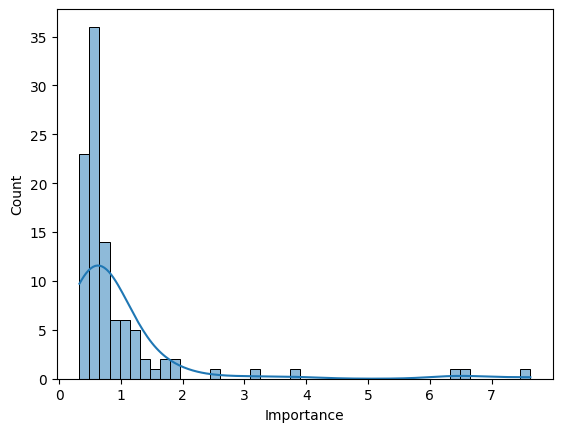

In [355]:
sns.histplot(catboost_importance_df['Importance'], kde=True)

In [356]:
unimportant_df = catboost_importance_df[catboost_importance_df['Importance'] <= catboost_importance_df['Importance'].quantile(0.1)]

<Axes: xlabel='Importance', ylabel='Count'>

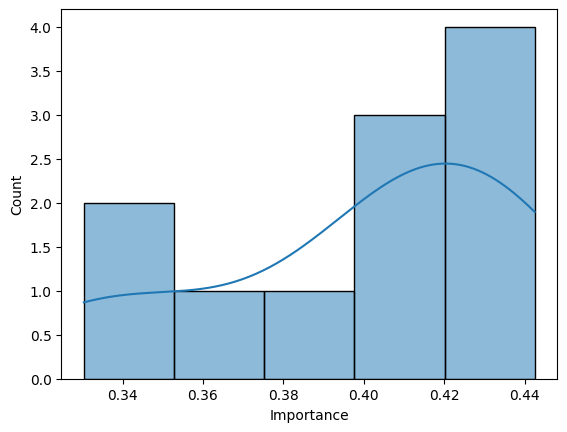

In [357]:
sns.histplot(unimportant_df['Importance'], kde=True)

In [358]:
unimportance_cols = unimportant_df['Feature'].tolist()
selected_df6 = selected_df5.drop(unimportance_cols, axis=1)
print(selected_df6.shape)
selected_df6.head()

(2736, 94)


id  Basic_Demos-Age  CGAS-CGAS_Score  Physical-Height  \
0  00008ff9              5.0             51.0             46.0   
1  000fd460              9.0             63.2             48.0   
2  00105258             10.0             71.0             56.5   
3  00115b9f              9.0             71.0             56.0   
4  001f3379             13.0             50.0             59.5   

   Physical-Weight  Physical-Waist_Circumference  FGC-FGC_CU  FGC-FGC_GSND  \
0             50.8                          24.0         0.0         22.04   
1             46.0                          22.0         3.0         21.86   
2             75.6                          26.6        20.0         10.20   
3             81.6                          27.6        18.0         15.10   
4            112.2                          28.8        12.0         16.50   

   FGC-FGC_PU  FGC-FGC_SRR  BIA-BIA_DEE  BIA-BIA_ICW  BIA-BIA_LDM  \
0         0.0          6.0      1492.00     24.43490      8.89536   
1         5.0         11.0      1498.65     21.03520     14.97400   
2         7.0         10.0      2453.97     42.82784     26.80338   
3         5.0          7.0      1923.44     30.40410     16.77900   
4         6.0         11.0      1996.45     32.91410     20.90200   

   BIA-BIA_SMM  SDS-SDS_Total_Raw  SDS-SDS_Total_T  \
0     19.54130               41.6             58.6   
1     15.41070               46.0             64.0   
2     58.78814               38.0             54.0   
3     26.47980               31.0             45.0   
4     35.38040               40.0             56.0   

   PreInt_EduHx-computerinternet_hoursday  Physical-Waist_Circumference_isnan  \
0                                     3.0                                 1.0   
1                                     0.0                                 0.0   
2                                     2.0                                 1.0   
3                                     0.0                                 1.0   
4                                     0.0                                 1.0   

   anglez_95%  anglez_97%  X_weekday_3_min  Y_weekday_2_70%  \
0   61.945976   68.108751        -1.181594         0.228419   
1   69.131664   74.714546        -1.175764         0.351217   
2   61.211522   68.894517        -1.384442         0.177141   
3   74.499702   83.422098        -0.973490         0.584620   
4   69.333694   75.295980        -1.015088         0.099477   

   enmo_weekday_2_70%  enmo_weekday_7_35%  anglez_weekday_1_45%  \
0            0.034239            0.009148             -1.073907   
1            0.029046            0.009175              9.273277   
2            0.029672            0.005300            -28.723628   
3            0.030776            0.014524            -14.873286   
4            0.017020            0.001606             15.318235   

   anglez_weekday_4_3%  anglez_weekday_4_99%  light_weekday_4_max  \
0           -69.067759             74.487629           929.050000   
1           -67.381481             78.130621          1148.777557   
2           -77.913436             79.615344          2174.520020   
3           -69.362376             88.299083          2318.199951   
4           -86.888733             79.856454          2578.000000   

   battery_use_since_wear_weekday_5_max  X_time_of_day_hour_window_6_65%  \
0                             696.71665                         0.194470   
1                             507.16665                         0.322972   
2                             475.76665                         0.198023   
3                             359.00000                         0.060635   
4                             432.00000                         0.390880   

   X_time_of_day_hour_window_10_50%  X_time_of_day_hour_window_15_max  \
0                          0.001905                          1.140360   
1                          0.074481                          1.058457   
2                          0.051309        

In [359]:
catboost_params = {
    'learning_rate': 0.02,
    'depth': 9,
    'iterations': 2000,
    'random_seed': SEED,
    'verbose': 0,
    'l2_leaf_reg': 50,  # Increase this value
    'task_type': 'GPU',
    'use_best_model': True,
    'early_stopping_rounds': 30,
    #'subsample': 0.8,
    'boosting_type': 'Ordered'
}

CatBoost_Model = CatBoostRegressor(
    **catboost_params
)

catboost_models_list6 = TrainML(CatBoost_Model, selected_df6)#, test_final)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

----> || Train Optimized QWK SCORE ::  0.793
----> || Val Optimized QWK SCORE ::  0.531
----> || Train Optimized Val QWK SCORE ::  0.518
----> || Val Optimized Train QWK SCORE ::  0.794
Fold 1 - Rounded Train QWK: 0.7511, Rounded Validation QWK: 0.4425


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

----> || Train Optimized QWK SCORE ::  0.745
----> || Val Optimized QWK SCORE ::  0.493
----> || Train Optimized Val QWK SCORE ::  0.546
----> || Val Optimized Train QWK SCORE ::  0.669
Fold 2 - Rounded Train QWK: 0.6790, Rounded Validation QWK: 0.4750


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

----> || Train Optimized QWK SCORE ::  0.724
----> || Val Optimized QWK SCORE ::  0.522
----> || Train Optimized Val QWK SCORE ::  0.510
----> || Val Optimized Train QWK SCORE ::  0.709
Fold 3 - Rounded Train QWK: 0.6578, Rounded Validation QWK: 0.4467


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

----> || Train Optimized QWK SCORE ::  0.713
----> || Val Optimized QWK SCORE ::  0.485
----> || Train Optimized Val QWK SCORE ::  0.454
----> || Val Optimized Train QWK SCORE ::  0.702
Fold 4 - Rounded Train QWK: 0.6588, Rounded Validation QWK: 0.3980


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

----> || Train Optimized QWK SCORE ::  0.773
----> || Val Optimized QWK SCORE ::  0.438
----> || Train Optimized Val QWK SCORE ::  0.430
----> || Val Optimized Train QWK SCORE ::  0.713
Fold 5 - Rounded Train QWK: 0.7078, Rounded Validation QWK: 0.4266
Mean Train QWK --> 0.7497
Mean Validation QWK ---> 0.4935
----> || Optimized QWK SCORE ::  0.501


In [363]:
feature_cols_df = pd.DataFrame({'selected_features': selected_df6.columns.tolist()})
print(feature_cols_df.shape)
feature_cols_df

(94, 1)


selected_features
0                                                     id
1                                        Basic_Demos-Age
2                                        CGAS-CGAS_Score
3                                        Physical-Height
4                                        Physical-Weight
5                           Physical-Waist_Circumference
6                                             FGC-FGC_CU
7                                           FGC-FGC_GSND
8                                             FGC-FGC_PU
9                                            FGC-FGC_SRR
10                                           BIA-BIA_DEE
11                                           BIA-BIA_ICW
12                                           BIA-BIA_LDM
13                                           BIA-BIA_SMM
14                                     SDS-SDS_Total_Raw
15                                       SDS-SDS_Total_T
16                PreInt_EduHx-computerinternet_hoursday
17                    Physical-Waist_Circumference_isnan
18                                            anglez_95%
19                                            anglez_97%
20                                       X_weekday_3_min
21                                       Y_weekday_2_70%
22                                    enmo_weekday_2_70%
23                                    enmo_weekday_7_35%
24                                  anglez_weekday_1_45%
25                                   anglez_weekday_4_3%
26                                  anglez_weekday_4_99%
27                                   light_weekday_4_max
28                  battery_use_since_wear_weekday_5_max
29                       X_time_of_day_hour_window_6_65%
30                      X_time_of_day_hour_window_10_50%
31                      X_time_of_day_hour_window_15_max
32                       Y_time_of_day_hour_window_2_60%
33                       Y_time_of_day_hour_window_4_65%
34                       Y_time_of_day_hour_window_4_75%
35                       Y_time_of_day_hour_window_8_25%
36                       Y_time_of_day_hour_window_13_5%
37                      Y_time_of_day_hour_window_15_min
38                      Y_time_of_day_hour_window_19_90%
39                      Y_time_of_day_hour_window_19_97%
40                      Y_time_of_day_hour_window_20_15%
41                       Z_time_of_day_hour_window_5_55%
42                       Z_time_of_day_hour_window_5_sum
43                      Z_time_of_day_hour_window_11_std
44                  Z_time_of_day_hour_window_11_entropy
45                      Z_time_of_day_hour_window_12_97%
46                      Z_time_of_day_hour_window_16_max
47                       Z_time_of_day_hour_window_21_1%
48                      Z_time_of_day_hour_window_23_min
49                    enmo_time_of_day_hour_window_5_15%
50                   enmo_time_of_day_hour_window_8_mean
51                    enmo_time_of_day_hour_window_8_60%
52                    enmo_time_of_day_hour_window_8_97%
53                   enmo_time_of_day_hour_window_10_60%
54                   enmo_time_of_day_hour_window_10_65%
55                   enmo_time_of_day_hour_window_10_70%
56                   enmo_time_of_day_hour_window_11_55%
57                   enmo_time_of_day_hour_window_13_99%
58                  enmo_time_of_day_hour_window_15_mean
59                   enmo_time_of_day_hour_window_15_20%
60                   enmo_time_of_day_hour_window_15_max
61                   enmo_time_of_day_hour_window_17_50%
62                   enmo_time_of_day_hour_window_18_80%
63                   enmo_time_of_day_hour_window_18_max
64                  anglez_time_of_day_hour_window_2_85%
65                  anglez_time_of_day_hour_window_2_90%
66                  anglez_time_of_day_hour_window_3_90%
67                  anglez_time_of_day_hour_window_8_99%
68                 anglez_time_of_day_hour_window_11_10%
69                 anglez_time_of_day_hour_window

In [364]:
feature_cols_df.to_csv(path + 'selected_features.csv', index=False)

In [360]:
catboost_importance_df = feature_importance(catboost_models_list6, selected_df6.drop(['id', 'sii'], axis=1))
unimportant_df = catboost_importance_df[catboost_importance_df['Importance'] <= catboost_importance_df['Importance'].quantile(0.1)]
unimportance_cols = unimportant_df['Feature'].tolist()
selected_df7 = selected_df6.drop(unimportance_cols, axis=1)
print(selected_df7.shape)
selected_df7.head()

(2736, 84)


id  Basic_Demos-Age  CGAS-CGAS_Score  Physical-Height  \
0  00008ff9              5.0             51.0             46.0   
1  000fd460              9.0             63.2             48.0   
2  00105258             10.0             71.0             56.5   
3  00115b9f              9.0             71.0             56.0   
4  001f3379             13.0             50.0             59.5   

   Physical-Weight  Physical-Waist_Circumference  FGC-FGC_CU  FGC-FGC_GSND  \
0             50.8                          24.0         0.0         22.04   
1             46.0                          22.0         3.0         21.86   
2             75.6                          26.6        20.0         10.20   
3             81.6                          27.6        18.0         15.10   
4            112.2                          28.8        12.0         16.50   

   FGC-FGC_PU  BIA-BIA_DEE  BIA-BIA_ICW  BIA-BIA_LDM  BIA-BIA_SMM  \
0         0.0      1492.00     24.43490      8.89536     19.54130   
1         5.0      1498.65     21.03520     14.97400     15.41070   
2         7.0      2453.97     42.82784     26.80338     58.78814   
3         5.0      1923.44     30.40410     16.77900     26.47980   
4         6.0      1996.45     32.91410     20.90200     35.38040   

   SDS-SDS_Total_Raw  SDS-SDS_Total_T  PreInt_EduHx-computerinternet_hoursday  \
0               41.6             58.6                                     3.0   
1               46.0             64.0                                     0.0   
2               38.0             54.0                                     2.0   
3               31.0             45.0                                     0.0   
4               40.0             56.0                                     0.0   

   Physical-Waist_Circumference_isnan  anglez_95%  anglez_97%  \
0                                 1.0   61.945976   68.108751   
1                                 0.0   69.131664   74.714546   
2                                 1.0   61.211522   68.894517   
3                                 1.0   74.499702   83.422098   
4                                 1.0   69.333694   75.295980   

   X_weekday_3_min  Y_weekday_2_70%  enmo_weekday_2_70%  enmo_weekday_7_35%  \
0        -1.181594         0.228419            0.034239            0.009148   
1        -1.175764         0.351217            0.029046            0.009175   
2        -1.384442         0.177141            0.029672            0.005300   
3        -0.973490         0.584620            0.030776            0.014524   
4        -1.015088         0.099477            0.017020            0.001606   

   anglez_weekday_4_99%  light_weekday_4_max  \
0             74.487629           929.050000   
1             78.130621          1148.777557   
2             79.615344          2174.520020   
3             88.299083          2318.199951   
4             79.856454          2578.000000   

   battery_use_since_wear_weekday_5_max  X_time_of_day_hour_window_10_50%  \
0                             696.71665                          0.001905   
1                             507.16665                          0.074481   
2                             475.76665                          0.051309   
3                             359.00000                         -0.646016   
4                             432.00000                          0.096015   

   X_time_of_day_hour_window_15_max  Y_time_of_day_hour_window_2_60%  \
0                          1.140360                         0.127024   
1                          1.058457                        -0.073225   
2                          1.251344                         0.020276   
3                          1.023125                         0.036979   
4                          1.006678                         0.041193   

   Y_time_of_day_hour_window_4_65%  Y_time_of_day_hour_window_4_75%  \
0                         0.227895                         0.320175   
1                        -0.012252              

In [361]:
catboost_params = {
    'learning_rate': 0.02,
    'depth': 9,
    'iterations': 2000,
    'random_seed': SEED,
    'verbose': 0,
    'l2_leaf_reg': 50,  # Increase this value
    'task_type': 'GPU',
    'use_best_model': True,
    'early_stopping_rounds': 30,
    #'subsample': 0.8,
    'boosting_type': 'Ordered'
}

CatBoost_Model = CatBoostRegressor(
    **catboost_params
)

catboost_models_list7 = TrainML(CatBoost_Model, selected_df7)#, test_final)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

----> || Train Optimized QWK SCORE ::  0.797
----> || Val Optimized QWK SCORE ::  0.524
----> || Train Optimized Val QWK SCORE ::  0.523
----> || Val Optimized Train QWK SCORE ::  0.779
Fold 1 - Rounded Train QWK: 0.7498, Rounded Validation QWK: 0.4509


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

----> || Train Optimized QWK SCORE ::  0.738
----> || Val Optimized QWK SCORE ::  0.485
----> || Train Optimized Val QWK SCORE ::  0.533
----> || Val Optimized Train QWK SCORE ::  0.663
Fold 2 - Rounded Train QWK: 0.6785, Rounded Validation QWK: 0.4703


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

----> || Train Optimized QWK SCORE ::  0.715
----> || Val Optimized QWK SCORE ::  0.490
----> || Train Optimized Val QWK SCORE ::  0.513
----> || Val Optimized Train QWK SCORE ::  0.692
Fold 3 - Rounded Train QWK: 0.6460, Rounded Validation QWK: 0.4424


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

----> || Train Optimized QWK SCORE ::  0.731
----> || Val Optimized QWK SCORE ::  0.441
----> || Train Optimized Val QWK SCORE ::  0.467
----> || Val Optimized Train QWK SCORE ::  0.704
Fold 4 - Rounded Train QWK: 0.6764, Rounded Validation QWK: 0.3946


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

----> || Train Optimized QWK SCORE ::  0.718
----> || Val Optimized QWK SCORE ::  0.425
----> || Train Optimized Val QWK SCORE ::  0.433
----> || Val Optimized Train QWK SCORE ::  0.628
Fold 5 - Rounded Train QWK: 0.6437, Rounded Validation QWK: 0.4140
Mean Train QWK --> 0.7400
Mean Validation QWK ---> 0.4731
----> || Optimized QWK SCORE ::  0.497


In [ ]:
catboost_importance_df = feature_importance(catboost_models_list[0], train_final_df.drop(['id', 'sii'], axis=1))
print(catboost_importance_df.shape)
catboost_importance_df.head()

In [ ]:
catboost_importance_df

In [ ]:
unimportant_features_df = catboost_importance_df[catboost_importance_df['Importance'] == 0]

In [ ]:
unimportant_features = unimportant_features_df['Feature'].tolist()
print(len(unimportant_features))
unimportant_features[:5]

In [ ]:
selected_train_df = train_final_df.drop(unimportant_features, axis=1)
print(selected_train_df.shape)
selected_train_df.head()

In [ ]:
catboost_models_list = TrainML(CatBoost_Model, selected_train_df)#, test_final)

In [ ]:
catboost_importance_df = feature_importance(catboost_models_list[0], selected_train_df.drop(['id', 'sii'], axis=1))
print(catboost_importance_df.shape)
catboost_importance_df

In [ ]:
unimportant_features_df = catboost_importance_df[catboost_importance_df['Importance'] == 0]
unimportant_features = unimportant_features_df['Feature'].tolist()
print(len(unimportant_features))
unimportant_features[:5]

In [ ]:
selected_train_df = selected_train_df.drop(unimportant_features, axis=1)
print(selected_train_df.shape)
selected_train_df.head()

In [ ]:
catboost_models_list = TrainML(CatBoost_Model, selected_train_df)#, test_final)

In [ ]:
catboost_importance_df = feature_importance(catboost_models_list[0], selected_train_df.drop(['id', 'sii'], axis=1))
print(catboost_importance_df.shape)
catboost_importance_df

In [ ]:
unimportant_features_df = catboost_importance_df[catboost_importance_df['Importance'] == 0]
unimportant_features = unimportant_features_df['Feature'].tolist()
print(len(unimportant_features))
unimportant_features[:5]

In [ ]:
selected_train_df = selected_train_df.drop(unimportant_features, axis=1)
print(selected_train_df.shape)
selected_train_df.head()

In [ ]:
CatBoost_Params = {
    'learning_rate': 0.003,
    'depth': 8,
    'iterations': 200,
    'random_seed': SEED,
    'verbose': 1,
    'l2_leaf_reg': 10,  # Increase this value
    'task_type': 'GPU'
}

CatBoost_Model = CatBoostRegressor(
    **CatBoost_Params,
    use_best_model=True
    #custom_metric=[quadratic_weighted_kappa]#,  # Use custom QWK as an additional metric
    #eval_metric=qwk_wrapper       # Optionally use it as the primary evaluation metric
)

catboost_models_list = TrainML(CatBoost_Model, selected_train_df)#, test_final)

In [ ]:
catboost_importance_df = feature_importance(catboost_models_list[0], selected_train_df.drop(['id', 'sii'], axis=1))
print(catboost_importance_df.shape)
catboost_importance_df

In [ ]:
unimportant_features_df = catboost_importance_df[catboost_importance_df['Importance'] == 0]
unimportant_features = unimportant_features_df['Feature'].tolist()
print(len(unimportant_features))
unimportant_features[:5]

In [ ]:
selected_train_df = selected_train_df.drop(unimportant_features, axis=1)
print(selected_train_df.shape)
selected_train_df.head()

In [ ]:
CatBoost_Params = {
    'learning_rate': 0.001,
    'depth': 10,
    'iterations': 1000,
    'random_seed': SEED,
    'verbose': 1,
    'l2_leaf_reg': 10,  # Increase this value
    'task_type': 'GPU'
}

CatBoost_Model = CatBoostRegressor(
    **CatBoost_Params,
    use_best_model=True
    #custom_metric=[quadratic_weighted_kappa]#,  # Use custom QWK as an additional metric
    #eval_metric=qwk_wrapper       # Optionally use it as the primary evaluation metric
)

catboost_models_list = TrainML(CatBoost_Model, selected_train_df)#, test_final)

In [ ]:
train_one_hot = train_nonan.copy()
test_one_hot = test_merge.copy()

In [ ]:
for col in cat_cols:
    if 'PCIAT' not in col:
        train_sr = train_one_hot[col].fillna('Missing').apply(str)        
        test_sr = test_one_hot[col].fillna('Missing').apply(str)
        train_one_hot[col] = train_sr
        test_one_hot[col] = test_sr
        concat_sr = pd.concat([train_sr, test_sr])
        unique_list = sorted(concat_sr.unique().tolist())

        for v in unique_list:
            new_col_name = col + '_' + v
            train_one_hot[new_col_name] = pd.Series(train_one_hot[col] == v).astype(int)
            test_one_hot[new_col_name] = pd.Series(test_one_hot[col] == v).astype(int)
    else:
        train_sr = train_one_hot[col].fillna('Missing').apply(str)
        train_one_hot[col] = train_sr
        unique_list = sorted(train_sr.unique().tolist())

        for v in unique_list:
            new_col_name = col + '_' + v
            train_one_hot[new_col_name] = pd.Series(train_one_hot[col] == v).astype(int)

train_one_hot.drop(cat_cols, axis=1, inplace=True)
test_one_hot.drop([col for col in cat_cols if 'PCIAT' not in col], axis=1, inplace=True)

In [ ]:
print(train_ts.shape)
train_ts.head()

In [ ]:
print(train_one_hot.shape)
train_one_hot.head()

In [ ]:
print(test_one_hot.shape)
test_one_hot.head()

In [ ]:
train_one_hot.drop('id', axis=1, inplace=True)
test_one_hot.drop('id', axis=1, inplace=True)

In [ ]:
train = train_one_hot[test_one_hot.columns.tolist() + ['sii']].copy()
test = test_one_hot.copy()

In [ ]:
print(train.shape)
train.head()

In [ ]:
print(test.shape)
test.head()

In [ ]:
concat_df = pd.concat([train[test.columns], test], ignore_index=True)
print(concat_df.shape)
concat_df.head()

In [ ]:
imputer = KNNImputer(n_neighbors=5)
imputed_data_concat = imputer.fit_transform(concat_df)

In [ ]:
concat_imputed = pd.DataFrame(imputed_data_concat, columns=concat_df.columns)
print(concat_imputed.shape)
concat_imputed.head()

In [ ]:
concat_imputed.isna().sum().sum()

In [ ]:
concat_imputed = feature_engineering(concat_imputed)
print(concat_imputed.shape)
concat_imputed.head()

In [ ]:
if np.any(np.isinf(concat_imputed)):
    print('inf in data')
    concat_imputed = concat_imputed.replace([np.inf, -np.inf], np.nan)

In [ ]:
imputer = KNNImputer(n_neighbors=5)
imputed_data = imputer.fit_transform(concat_imputed)

In [ ]:
concat_imputed = pd.DataFrame(imputed_data, columns=concat_imputed.columns)
print(concat_imputed.shape)
concat_imputed.head()

In [ ]:
concat_imputed.isna().sum().sum()

In [ ]:
train_imputed = concat_imputed.head(train.shape[0]).reset_index(drop=True)
test_imputed = concat_imputed.tail(test.shape[0]).reset_index(drop=True)

In [ ]:
train_imputed['sii'] = train['sii']

In [ ]:
train_final = train_imputed.copy()
test_final = test_imputed.copy()

In [ ]:
print(train_final.shape)
print(test_final.shape)

# Model Training and Evaluation

- **Model Types**: Various models are used, including:
  - **LightGBM**: A gradient-boosting framework known for its speed and efficiency with large datasets.
  - **XGBoost**: Another powerful gradient-boosting model used for structured data.
  - **CatBoost**: Optimized for categorical features without the need for extensive preprocessing.
  - **Voting Regressor**: An ensemble model that combines the predictions of LightGBM, XGBoost, and CatBoost for better accuracy.
- **Cross-Validation**: Stratified K-Folds cross-validation is employed to split the data into training and validation sets, ensuring balanced class distribution in each fold.
- **Quadratic Weighted Kappa (QWK)**: The performance of the models is evaluated using QWK, which measures the agreement between predicted and actual values, taking into account the ordinal nature of the target variable.
- **Threshold Optimization**: The `minimize` function from `scipy.optimize` is used to fine-tune decision thresholds that map continuous predictions to discrete categories (None, Mild, Moderate, Severe).


In [ ]:
def TrainML(model_class, train_data, test_data):
    X = train_data.drop(['sii'], axis=1)
    y = train_data['sii']

    SKF = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    
    train_S = []
    test_S = []
    
    oof_non_rounded = np.zeros(len(y), dtype=float) 
    oof_rounded = np.zeros(len(y), dtype=int) 
    test_preds = np.zeros((len(test_data), n_splits))

    for fold, (train_idx, test_idx) in enumerate(tqdm(SKF.split(X, y), desc="Training Folds", total=n_splits)):
        X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]

        model = clone(model_class)
        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)

        oof_non_rounded[test_idx] = y_val_pred
        y_val_pred_rounded = y_val_pred.round(0).astype(int)
        oof_rounded[test_idx] = y_val_pred_rounded

        train_kappa = quadratic_weighted_kappa(y_train, y_train_pred.round(0).astype(int))
        val_kappa = quadratic_weighted_kappa(y_val, y_val_pred_rounded)

        train_S.append(train_kappa)
        test_S.append(val_kappa)
        
        test_preds[:, fold] = model.predict(test_data)
        
        print(f"Fold {fold+1} - Train QWK: {train_kappa:.4f}, Validation QWK: {val_kappa:.4f}")
        clear_output(wait=True)

    print(f"Mean Train QWK --> {np.mean(train_S):.4f}")
    print(f"Mean Validation QWK ---> {np.mean(test_S):.4f}")

    KappaOPtimizer = minimize(evaluate_predictions,
                              x0=[0.5, 1.5, 2.5], args=(y, oof_non_rounded), 
                              method='Nelder-Mead')
    assert KappaOPtimizer.success, "Optimization did not converge."
    
    oof_tuned = threshold_Rounder(oof_non_rounded, KappaOPtimizer.x)
    tKappa = quadratic_weighted_kappa(y, oof_tuned)

    print(f"----> || Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {tKappa:.3f}{Style.RESET_ALL}")

    tpm = test_preds.mean(axis=1)
    tpTuned = threshold_Rounder(tpm, KappaOPtimizer.x)
    
    submission = pd.DataFrame({
        'id': sample['id'],
        'sii': tpTuned
    })

    return submission


# Hyperparameter Tuning

- **LightGBM Parameters**: Hyperparameters such as `learning_rate`, `max_depth`, `num_leaves`, and `feature_fraction` are tuned to improve the performance of the LightGBM model. These parameters control the complexity of the model and its ability to generalize to new data.
- **XGBoost and CatBoost Parameters**: Similar tuning is applied for XGBoost and CatBoost, adjusting parameters such as `n_estimators`, `max_depth`, `learning_rate`, `subsample`, and `regularization` terms (`reg_alpha`, `reg_lambda`). These help in controlling overfitting and ensuring the model's robustness.

In [ ]:
Params7 = {
    'learning_rate': 0.03884249148676395,
    'max_depth': 12,
    'num_leaves': 413,
    'min_data_in_leaf': 14,
    'feature_fraction': 0.7987976913702801,
    'bagging_fraction': 0.7602261703576205,
    'bagging_freq': 2,
    'lambda_l1': 4.735462555910575,
    'lambda_l2': 4.735028557007343e-06
} # CV : 0.4094 | LB : 0.471

In [ ]:
Light = LGBMRegressor(**Params7, random_state=SEED, verbose=-1, n_estimators=200)

In [ ]:
Submission1 = TrainML(Light, train_final, test_final)
Submission1.to_csv('submission.csv', index=False)

Submission1